# Data loading and Preprocessing

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import os
#print(os.listdir("../input"))

In [3]:
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

#from fastai.imports import *
#from fastai.structured import *

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
from sklearn import metrics
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import gc
import seaborn as sns
import warnings
import scipy.signal as sg
warnings.filterwarnings("ignore")

from scipy import stats

In [5]:
import gc
from itertools import product
import random
import pickle

In [6]:
from xgboost import XGBRegressor
from xgboost import plot_importance

In [7]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max: #and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [8]:
def merge_dataset(df):
    
    df = pd.merge(df, shops, on=['shop_id'], how='left')
    df = pd.merge(df, item, on=['item_id'], how='left')
    df = pd.merge(df, item_cat, on=['item_category_id'], how='left')
    df['city_code'] = df['city_code'].astype(np.int8)
    df['item_category_id'] = df['item_category_id'].astype(np.int8)
    df['type_code'] = df['type_code'].astype(np.int8)
    df['subtype_code'] = df['subtype_code'].astype(np.int8)
        
    return df

In [9]:
def target_generate(df):
    df = pd.merge(df, sales_group[['date_block_num','shop_id','item_id','revenue_month','item_cnt_month']], on=cols, how='left')
    df['item_cnt_month'] = (df['item_cnt_month']
                                    .fillna(0)
                                    .clip(0,20) # NB clip target here
                                    .astype(np.float32))
    
    df['revenue_month'] = (df['revenue_month']
                                    .fillna(0)
                                    #.clip(0,20) # NB clip target here
                                    .astype(np.float32))
    return df

In [10]:
lags = np.arange(12) + 1
def lag_feature(df, lags, col = 'item_cnt_month', fillna = '0'):
    tmp = df[['date_block_num', 'shop_id', 'item_id', col]]
    
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        
        if fillna == 'median':
            df[f'{col}_lag_{i}'].fillna(df[f'{col}_lag_{i}'].median(), inplace = True)
        elif fillna == 'mean':
            df[f'{col}_lag_{i}'].fillna(df[f'{col}_lag_{i}'].mean(), inplace = True)
        elif fillna == '0':
            df.fillna(0, inplace = True)
        del shifted
        gc.collect()    
        
    del tmp
    
    return df

In [49]:
sales_train = pd.read_csv('./input/sales_train_v2.csv')
test = pd.read_csv('./input/test.csv')

In [12]:
item_cat = pd.read_csv('./input/item_categories.csv')
item = pd.read_csv('./input/items.csv')
shops = pd.read_csv('./input/shops.csv')

In [13]:
def remove_duplicate():
    # Якутск Орджоникидзе, 56
    sales_train.loc[sales_train.shop_id == 0, 'shop_id'] = 57
    test.loc[test.shop_id == 0, 'shop_id'] = 57
    # Якутск ТЦ "Центральный"
    sales_train.loc[sales_train.shop_id == 1, 'shop_id'] = 58
    test.loc[test.shop_id == 1, 'shop_id'] = 58
    # Жуковский ул. Чкалова 39м²
    sales_train.loc[sales_train.shop_id == 10, 'shop_id'] = 11
    test.loc[test.shop_id == 10, 'shop_id'] = 11
    #
    sales_train.loc[sales_train.shop_id == 39, 'shop_id'] = 40
    test.loc[test.shop_id == 39, 'shop_id'] = 40
    
remove_duplicate()

In [14]:
def preprocess_sales_train(df):
    df = df[df['item_cnt_day'] < 1000]
    df = df[df['item_price'] < 100000]
    return df

In [15]:
sales_train = preprocess_sales_train(sales_train)
median = sales_train[(sales_train.shop_id==32)&(sales_train.item_id==2973)&(sales_train.date_block_num==4)&(sales_train.item_price>0)].item_price.median()
sales_train.loc[sales_train.item_price<0, 'item_price'] = median

In [16]:
#def subcategory_generation():
shops['shop_name'] = shops['shop_name'].apply(lambda x: x.lower()).str.replace('[^\w\s]', '').str.replace('\d+','').str.strip()
shops['shop_city'] = shops['shop_name'].str.partition(' ')[0]
shops['shop_type'] = shops['shop_name'].apply(lambda x: 'мтрц' if 'мтрц' in x else 'трц' if 'трц' in x else 'трк' if 'трк' in x else 'тц' if 'тц' in x else 'тк' if 'тк' in x else 'NO_DATA')
shops.head()

#shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
#shops = shops[['shop_id','city_code']]

shop_name  shop_id shop_city shop_type
0    якутск орджоникидзе  фран        0    якутск   NO_DATA
1   якутск тц центральный фран        1    якутск        тц
2               адыгея тц мега        2    адыгея        тц
3  балашиха трк октябрькиномир        3  балашиха       трк
4       волжский тц волга молл        4  волжский        тц

In [17]:
shops['shop_type'].unique()

array(['NO_DATA', 'тц', 'трк', 'трц', 'мтрц', 'тк'], dtype=object)

In [18]:
item['name_1'], item['name_2'] = item['item_name'].str.split('[', 1).str
item['name_1'], item['name_3'] = item['item_name'].str.split('(', 1).str

item['name_2'] = item['name_2'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
item['name_3'] = item['name_3'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
item = item.fillna('0')

In [19]:
item_cat['split'] = item_cat['item_category_name'].str.split('-')
item_cat['type'] = item_cat['split'].map(lambda x: x[0].strip())
item_cat['type_code'] = LabelEncoder().fit_transform(item_cat['type'])
# if subtype is nan then type
item_cat['subtype'] = item_cat['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_cat['subtype_code'] = LabelEncoder().fit_transform(item_cat['subtype'])
item_cat = item_cat[['item_category_id','type_code', 'subtype_code']]
#subcategory_generation()

In [20]:
l_cat = list(item_cat.item_category_id)

In [21]:
for ind in range(0,1):

     l_cat[ind] = 'PC Headsets / Headphones'

for ind in range(1,8):

     l_cat[ind] = 'Access'

l_cat[8] = 'Tickets (figure)'

l_cat[9] = 'Delivery of goods'

for ind in range(10,18):

    l_cat[ind] = 'Consoles'

for ind in range(18,25):

    l_cat[ind] = 'Consoles Games'

l_cat[25] = 'Accessories for games'

for ind in range(26,28):

    l_cat[ind] = 'phone games'

for ind in range(28,32):

    l_cat[ind] = 'CD games'

for ind in range(32,37):

    l_cat[ind] = 'Card'

for ind in range(37,43):

    l_cat[ind] = 'Movie'

for ind in range(43,55):

    l_cat[ind] = 'Books'

for ind in range(55,61):

    l_cat[ind] = 'Music'

for ind in range(61,73):

    l_cat[ind] = 'Gifts'

for ind in range(73,79):

    l_cat[ind] = 'Soft'

for ind in range(79,81):

    l_cat[ind] = 'Office'

for ind in range(81,83):

    l_cat[ind] = 'Clean'

l_cat[83] = 'Elements of a food'

In [22]:
from sklearn import preprocessing

lb = preprocessing.LabelEncoder()
item_cat['item_cat_id_fix'] = lb.fit_transform(l_cat)

In [23]:
item_cat.head()

item_category_id  type_code  subtype_code  item_cat_id_fix
0                 0          0            29               14
1                 1          1             9                0
2                 2          1            10                0
3                 3          1            11                0
4                 4          1            13                0

In [24]:
# label encoding shop
shops['city_code'] = LabelEncoder().fit_transform(shops['shop_city'])
shops['shop_type_code'] = LabelEncoder().fit_transform(shops['shop_type'])

In [25]:
shops.head()

shop_name  shop_id shop_city shop_type  city_code  \
0    якутск орджоникидзе  фран        0    якутск   NO_DATA         29   
1   якутск тц центральный фран        1    якутск        тц         29   
2               адыгея тц мега        2    адыгея        тц          0   
3  балашиха трк октябрькиномир        3  балашиха       трк          1   
4       волжский тц волга молл        4  волжский        тц          2   

   shop_type_code  
0               0  
1               5  
2               5  
3               3  
4               5

In [26]:
# label encoding item
item['name_1_code'] = LabelEncoder().fit_transform(item['name_1'])
item['name_2_code'] = LabelEncoder().fit_transform(item['name_2'])
item['name_3_code'] = LabelEncoder().fit_transform(item['name_3'])

In [27]:
len(item['name_1'].unique()), len(item['name_1_code'].unique())

(20611, 20611)

In [28]:
item.head()

item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id                                             name_1  \
0                40                            ! ВО ВЛАСТИ НАВАЖДЕНИЯ    
1                76  !ABBYY FineReader 12 Professional Edition Full...   
2                40                                ***В ЛУЧАХ СЛАВЫ      
3                40                                 ***ГОЛУБАЯ ВОЛНА     
4                40                                        ***КОРОБКА    

                name_2    name_3  name_1_code  name_2_code  name_3_code  
0                    0   пласт d            0            4         1331  
1  pc цифровая версия          0            1           64           42  
2                    0     unv d            2            4         1011  
3                    0    univ d            3            4         1010  
4                    0  стекло d            4            4         1572

In [29]:
item.drop(['item_name'], axis=1, inplace=True)

In [30]:
sales_train['revenue'] = sales_train['item_price'] *  sales_train['item_cnt_day']

In [31]:
gc.collect()

35

In [32]:
sales_train = reduce_mem_usage(sales_train)

Mem. usage decreased to 89.59 Mb (50.0% reduction)


# Categorize test and validation data set

In [33]:
cols = ['date_block_num','shop_id','item_id']

In [34]:
test['date_block_num']= 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
test = test[cols]

In [35]:
sales_group = sales_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({
                                    'item_cnt_day': ['sum'],
                                    'revenue': ['sum']
})

In [36]:
sales_group.columns = ['_'.join(col).strip() for col in sales_group.columns.values]
sales_group.rename(columns = {
                            'revenue_sum': 'revenue_month',
                            'item_cnt_day_sum': 'item_cnt_month',
                            },
                 inplace = True) 
sales_group.reset_index(inplace=True)

In [37]:
# Initialize category column, 4 means haven't assigned any tag
test['category'] = 4

In [38]:
shop_train = sales_group.loc[sales_group['date_block_num']<=33]['shop_id'].unique()
item_lst = sales_group.loc[sales_group['date_block_num']<=33]['item_id'].unique()
shop_test = test.loc[test['category']==0]['shop_id'].unique()

In [39]:
sales_group['date_block_num'].max()

33

Normal items with shop/item in sale history

In [40]:
for shop in shop_train:
    item_lst_shop = sales_group.loc[(sales_group['date_block_num']<=33)&(sales_group['shop_id'] == shop)]['item_id'].unique()
    test.loc[(test['shop_id'] == shop) & (test['item_id'].isin(item_lst_shop)), 'category'] = 0

Items w/o sale history

In [41]:
test.loc[~(test['item_id'].isin(item_lst)), 'category'] = 2

Items w sale history but no good shop/item pair

In [42]:
test.loc[test['category'] == 4, 'category'] = 1

In [43]:
len(test.loc[test['category']==0]), len(test.loc[test['category']==1]), len(test.loc[test['category']==2])

(111511, 87443, 15246)

In [44]:
with open('df_prediction_20191031.pickle', 'wb') as handle:
    pickle.dump(test, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('df_prediction_20191031.pickle', 'rb') as handle:
    test = pickle.load(handle)

# Normal Items PipeLine

In [44]:
cols = ['date_block_num','shop_id','item_id']

In [45]:
train_normal = []
date_blocks = np.arange(34)
for date in date_blocks:
    for shop in shop_train:
        item_shop = sales_group.loc[sales_group['shop_id'] == shop]['item_id'].unique()
        item_date = sales_group.loc[sales_group.date_block_num==date]['item_id'].unique()
        item_use = list(set(item_shop).intersection(set(item_date)))
        if len(item_use) == 0:
            continue
        train_normal.append(np.array(list(product([date], [shop], item_use)), dtype='int16'))
        gc.collect()
    
train_normal = pd.DataFrame(np.vstack(train_normal), columns=cols)
train_normal['date_block_num'] = train_normal['date_block_num'].astype(np.int8)
train_normal['shop_id'] = train_normal['shop_id'].astype(np.int8)
train_normal['item_id'] = train_normal['item_id'].astype(np.int16)
train_normal.sort_values(cols,inplace=True)

In [46]:
train_normal['category'] = 4

In [47]:
del train_normal
gc.collect()

28

In [253]:
len(train_normal)

6700914

Categorize validation set

In [254]:
gc.collect()

7

In [522]:
train_normal = pd.concat([train_normal, test[cols + ['category']]], ignore_index=True, sort=False, keys=cols)
train_normal.fillna(0, inplace=True) # 34 month

In [523]:
train_normal.loc[train_normal['date_block_num'] == 34].tail()

date_block_num  shop_id  item_id  category
6902190              34       45    18454         0
6902191              34       45    16188         1
6902192              34       45    15757         0
6902193              34       45    19648         1
6902194              34       45      969         0

In [525]:
train_normal = target_generate(train_normal)

In [526]:
ts = time.time()
train_normal = lag_feature(train_normal, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts

31.299809217453003

In [527]:
train_normal = merge_dataset(train_normal)

In [528]:
train_normal = pd.merge(train_normal, item_cat[['item_cat_id_fix', 'item_category_id']], on = ['item_category_id'], how = 'left')

Need to check the generated train dataset makes sense

In [261]:
len(train_normal.loc[(train_normal['date_block_num'] < 34) & (train_normal['item_cnt_month']==0)])/len(train_normal.loc[(train_normal['date_block_num'] < 34)])

0.7603873143275679

In [53]:
len(sales_group.loc[sales_group['item_cnt_month']==0])/len(sales_group)

0.0016052232211106428

In [529]:
def aggregate_features(df, group_features, main_feature, lag_months, fillna = '0'):
    group = df.groupby(group_features).agg({main_feature: ['mean']})
    group.columns = [f'{group_features}_avg_{main_feature}']
    group.reset_index(inplace = True)
    
    df = pd.merge(df, group, on = group_features, how = 'left')
    df[f'{group_features}_avg_{main_feature}'] = df[f'{group_features}_avg_{main_feature}'].astype(np.float16)
    df = lag_feature(df, lag_months, f'{group_features}_avg_{main_feature}', fillna)
    df.drop([f'{group_features}_avg_{main_feature}'], axis=1, inplace = True)
    
    df.columns = df.columns.str.replace(" ", "_").str.replace(",", "").str.replace("[", "").str.replace("]", "")
    
    del group
    gc.collect()
    
    return df

# Old FE code

In [262]:
ts = time.time()
group = train_normal.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

train_normal = pd.merge(train_normal, group, on=['date_block_num'], how='left')
train_normal['date_avg_item_cnt'] = train_normal['date_avg_item_cnt'].astype(np.float16)
train_normal = lag_feature(train_normal, [1], 'date_avg_item_cnt')
train_normal.drop(['date_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

del group
gc.collect()

28

In [263]:
ts = time.time()
group = train_normal.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

train_normal = pd.merge(train_normal, group, on=['date_block_num','item_id'], how='left')
train_normal['date_item_avg_item_cnt'] = train_normal['date_item_avg_item_cnt'].astype(np.float16)
train_normal = lag_feature(train_normal, [1,2,3,6,12], 'date_item_avg_item_cnt')
train_normal.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

45.72343564033508

In [265]:
ts = time.time()
group = train_normal.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

train_normal = pd.merge(train_normal, group, on=['date_block_num','shop_id'], how='left')
train_normal['date_shop_avg_item_cnt'] = train_normal['date_shop_avg_item_cnt'].astype(np.float16)
train_normal = lag_feature(train_normal, [1,2,3,6,12], 'date_shop_avg_item_cnt')
train_normal.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

49.684043645858765

In [267]:
ts = time.time()
group = train_normal.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

train_normal = pd.merge(train_normal, group, on=['date_block_num','item_category_id'], how='left')
train_normal['date_cat_avg_item_cnt'] = train_normal['date_cat_avg_item_cnt'].astype(np.float16)
train_normal = lag_feature(train_normal, [1], 'date_cat_avg_item_cnt')
train_normal.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

18.92020606994629

In [269]:
ts = time.time()
group = train_normal.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

train_normal = pd.merge(train_normal, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
train_normal['date_shop_cat_avg_item_cnt'] = train_normal['date_shop_cat_avg_item_cnt'].astype(np.float16)
train_normal = lag_feature(train_normal, [1], 'date_shop_cat_avg_item_cnt')
train_normal.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

19.030096769332886

In [270]:
ts = time.time()
group = train_normal.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

train_normal = pd.merge(train_normal, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
train_normal['date_shop_type_avg_item_cnt'] = train_normal['date_shop_type_avg_item_cnt'].astype(np.float16)
train_normal = lag_feature(train_normal, [1], 'date_shop_type_avg_item_cnt')
train_normal.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

19.20756196975708

In [272]:
ts = time.time()
group = train_normal.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

train_normal = pd.merge(train_normal, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
train_normal['date_shop_subtype_avg_item_cnt'] = train_normal['date_shop_subtype_avg_item_cnt'].astype(np.float16)
train_normal = lag_feature(train_normal, [1], 'date_shop_subtype_avg_item_cnt')
train_normal.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

19.4787175655365

In [273]:
ts = time.time()
group = train_normal.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

train_normal = pd.merge(train_normal, group, on=['date_block_num', 'city_code'], how='left')
train_normal['date_city_avg_item_cnt'] = train_normal['date_city_avg_item_cnt'].astype(np.float16)
train_normal = lag_feature(train_normal, [1], 'date_city_avg_item_cnt')
train_normal.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

19.191490173339844

In [274]:
ts = time.time()
group = train_normal.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

train_normal = pd.merge(train_normal, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
train_normal['date_item_city_avg_item_cnt'] = train_normal['date_item_city_avg_item_cnt'].astype(np.float16)
train_normal = lag_feature(train_normal, [1], 'date_item_city_avg_item_cnt')
train_normal.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

26.41192126274109

In [276]:
ts = time.time()
group = train_normal.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

train_normal = pd.merge(train_normal, group, on=['date_block_num', 'type_code'], how='left')
train_normal['date_type_avg_item_cnt'] = train_normal['date_type_avg_item_cnt'].astype(np.float16)
train_normal = lag_feature(train_normal, [1], 'date_type_avg_item_cnt')
train_normal.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

17.391998052597046

In [277]:
ts = time.time()
group = train_normal.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

train_normal = pd.merge(train_normal, group, on=['date_block_num', 'subtype_code'], how='left')
train_normal['date_subtype_avg_item_cnt'] = train_normal['date_subtype_avg_item_cnt'].astype(np.float16)
train_normal = lag_feature(train_normal, [1], 'date_subtype_avg_item_cnt')
train_normal.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

19.85810875892639

# New FE code

In [530]:
ts = time.time()
train_normal = aggregate_features(train_normal, ['date_block_num'], 'item_cnt_month', [1])
time.time() - ts

12.530921936035156

In [531]:
ts = time.time()
train_normal = aggregate_features(train_normal, ['date_block_num', 'item_id'], 'item_cnt_month', [1,2,3,6,12])
time.time() - ts

48.771629095077515

In [533]:
gc.collect()

8

In [534]:
ts = time.time()
train_normal = aggregate_features(train_normal, ['date_block_num', 'shop_id'], 'item_cnt_month', [1,2,3,6,12])
time.time() - ts

51.06210780143738

In [535]:
gc.collect()

0

In [536]:
ts = time.time()
train_normal = aggregate_features(train_normal, ['date_block_num', 'item_category_id'], 'item_cnt_month', [1])
time.time() - ts

15.976694822311401

In [537]:
gc.collect()

0

In [538]:
ts = time.time()
train_normal = aggregate_features(train_normal, ['date_block_num', 'shop_id', 'item_category_id'], 'item_cnt_month', [1])
time.time() - ts

17.151748418807983

In [539]:
ts = time.time()
train_normal = aggregate_features(train_normal, ['date_block_num', 'shop_id', 'type_code'], 'item_cnt_month', [1])
time.time() - ts

17.79300284385681

In [540]:
gc.collect()

0

In [541]:
ts = time.time()
train_normal = aggregate_features(train_normal, ['date_block_num', 'shop_id', 'subtype_code'], 'item_cnt_month', [1])
time.time() - ts

18.240251302719116

In [542]:
ts = time.time()
train_normal = aggregate_features(train_normal, ['date_block_num', 'city_code'], 'item_cnt_month', [1])
time.time() - ts

17.03626012802124

In [543]:
ts = time.time()
train_normal = aggregate_features(train_normal, ['date_block_num', 'item_id', 'city_code'], 'item_cnt_month', [1])
time.time() - ts

25.326092004776

In [544]:
ts = time.time()
train_normal = aggregate_features(train_normal, ['date_block_num', 'city_code', 'item_category_id'], 'item_cnt_month', [1])
time.time() - ts

18.596647024154663

In [545]:
ts = time.time()
train_normal = aggregate_features(train_normal, ['date_block_num', 'city_code', 'type_code'], 'item_cnt_month', [1])
time.time() - ts

19.145827054977417

In [546]:
ts = time.time()
train_normal = aggregate_features(train_normal, ['date_block_num', 'city_code', 'subtype_code'], 'item_cnt_month', [1])
time.time() - ts

18.684386491775513

In [547]:
gc.collect()

0

In [548]:
ts = time.time()
train_normal = aggregate_features(train_normal, ['date_block_num', 'type_code'], 'item_cnt_month', [1])
time.time() - ts

20.39875292778015

In [549]:
ts = time.time()
train_normal = aggregate_features(train_normal, ['date_block_num', 'subtype_code'], 'item_cnt_month', [1])
time.time() - ts

20.541935682296753

In [ ]:
train_normal.head()

In [550]:
ts = time.time()
group = sales_train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

train_normal = pd.merge(train_normal, group, on=['item_id'], how='left')
train_normal['item_avg_item_price'] = train_normal['item_avg_item_price'].astype(np.float16)

group = sales_train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

train_normal = pd.merge(train_normal, group, on=['date_block_num','item_id'], how='left')
train_normal['date_item_avg_item_price'] = train_normal['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
train_normal = lag_feature(train_normal, lags, 'date_item_avg_item_price')

for i in lags:
    train_normal['delta_price_lag_'+str(i)] = \
        (train_normal['date_item_avg_item_price_lag_'+str(i)] - train_normal['item_avg_item_price']) / train_normal['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
train_normal['delta_price_lag'] = train_normal.apply(select_trend, axis=1)
train_normal['delta_price_lag'] = train_normal['delta_price_lag'].astype(np.float16)
train_normal['delta_price_lag'].fillna(0, inplace=True)

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

train_normal.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

228.82556438446045

In [551]:
del group
gc.collect()

0

In [552]:
ts = time.time()
group = sales_train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

train_normal = pd.merge(train_normal, group, on=['date_block_num','shop_id'], how='left')
train_normal['date_shop_revenue'] = train_normal['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

train_normal = pd.merge(train_normal, group, on=['shop_id'], how='left')
train_normal['shop_avg_revenue'] = train_normal['shop_avg_revenue'].astype(np.float32)

train_normal['delta_revenue'] = (train_normal['date_shop_revenue'] - train_normal['shop_avg_revenue']) / train_normal['shop_avg_revenue']
train_normal['delta_revenue'] = train_normal['delta_revenue'].astype(np.float16)

train_normal = lag_feature(train_normal, [1], 'delta_revenue')

train_normal.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts

15.893253326416016

In [553]:
train_normal['month'] = train_normal['date_block_num'] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
train_normal['days'] = train_normal['month'].map(days).astype(np.int8)

In [554]:
ts = time.time()
cache = {}
train_normal['item_shop_last_sale'] = -1
train_normal['item_shop_last_sale'] = train_normal['item_shop_last_sale'].astype(np.int8)
for idx, row in train_normal.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        train_normal.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         
time.time() - ts

902.541481256485

In [555]:
del group
gc.collect()

0

In [556]:
ts = time.time()
cache = {}
train_normal['item_last_sale'] = -1
train_normal['item_last_sale'] = train_normal['item_last_sale'].astype(np.int8)
for idx, row in train_normal.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            train_normal.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         
time.time() - ts

549.8435094356537

In [557]:
ts = time.time()
train_normal['item_shop_first_sale'] = train_normal['date_block_num'] - train_normal.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
train_normal['item_first_sale'] = train_normal['date_block_num'] - train_normal.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

1.6934130191802979

In [558]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

train_normal = fill_na(train_normal)
time.time() - ts

0.5161826610565186

In [559]:
with open('train_normal_clip_0_20.pickle', 'wb') as handle:
    pickle.dump(train_normal, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [674]:
#with open('train_normal_20191102_clip_0_20.pickle', 'rb') as handle:
#    train_normal = pickle.load(handle)

In [669]:
features = [
    'date_block_num',
    'shop_id',
    'item_id',
    #'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]

# xgb model

In [560]:
features = [feature for feature in train_normal.columns.values if feature not in
           [ 'category', 'revenue_month', 'prediction', 'prediction_0', 'prediction_1', 'item_cnt_month', 'delta_revenue_lag_1',
            'date_shop_type_avg_item_cnt_lag_1', 'date_shop_subtype_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1', 'date_subtype_avg_item_cnt_lag_1',
           ]
           ]

In [680]:
#list(set(train_normal.columns.values) - set(features))

In [561]:
date = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]

In [562]:
train_use = train_normal.loc[train_normal['date_block_num'].isin(date)]

In [563]:
X_train = train_use.loc[(train_use.date_block_num < 33)][features]
Y_train = train_use.loc[(train_use.date_block_num < 33)]['item_cnt_month']
X_valid = train_use.loc[train_use.date_block_num == 33][features]
Y_valid = train_use.loc[train_use.date_block_num == 33]['item_cnt_month']
X_test = train_use.loc[(train_use.date_block_num == 34) & (train_use['category']==0)][features]

In [564]:
gc.collect()

0

In [ ]:
# 1.0835   1.0848   1.08797

In [565]:
ts = time.time()

model_0 = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300,                     # initial 300           best: 128
    colsample_bytree=0.8,                     # initial 0.8           best: 0.9
    subsample=0.8,                            # initial 0.8
    eta=0.3,                                  # initial 0.3    
    seed=42)

model_0.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 5)

time.time() - ts

[20:42:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.37112	validation_1-rmse:1.37255
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 5 rounds.
[1]	validation_0-rmse:1.31953	validation_1-rmse:1.32681
[2]	validation_0-rmse:1.27766	validation_1-rmse:1.28972
[3]	validation_0-rmse:1.23654	validation_1-rmse:1.25705
[4]	validation_0-rmse:1.1989	validation_1-rmse:1.2287
[5]	validation_0-rmse:1.17214	validation_1-rmse:1.20605
[6]	validation_0-rmse:1.14823	validation_1-rmse:1.18647
[7]	validation_0-rmse:1.12885	validation_1-rmse:1.16989
[8]	validation_0-rmse:1.10855	validation_1-rmse:1.15672
[9]	validation_0-rmse:1.09342	validation_1-rmse:1.14434
[10]	validation_0-rmse:1.08165	validation_1-rmse:1.13584
[11]	validation_0-rmse:1.07073	validation_1-rmse:1.12758
[12]	validation_0-rmse:1.06121	validation_1-rmse:1.119

573.4519555568695

In [659]:
Y_pred_0 = model_0.predict(X_valid)
Y_test_0 = model_0.predict(X_test)

In [296]:
test['prediction_0'] = 0.5
test.head()

date_block_num  shop_id  item_id  category  prediction_0  prediction_1  \
0              34        5     5037         0           0.5    0.58035946   
1              34        5     5320         2           0.5    0.35893393   
2              34        5     5233         0           0.5    1.19984460   
3              34        5     5232         0           0.5    0.46978160   
4              34        5     5268         2           0.5    3.86263370   

          prediction  
0  0.604759235158981  
1  0.358933930000000  
2  1.174603063974991  
3  0.483080270196381  
4  3.862633700000000

In [660]:
Y_pred_0.max(), Y_pred_0.min(), Y_pred_0.mean(), Y_pred_0.std()

(19.356083, -0.00936234, 0.3881799, 0.8919975)

In [661]:
Y_test_0.max(), Y_test_0.min(), Y_test_0.mean(), Y_test_0.std()

(19.064524, 0.028870642, 0.41487512, 0.91861826)

In [580]:
tmp_0 = test.loc[test['category']==0]
tmp_0['prediction_1'].max(), tmp_0['prediction_1'].min(), tmp_0['prediction_1'].mean(), tmp_0['prediction_1'].std()

(20.292133, 0.014987558, 0.4191232454771465, 0.9659582341699007)

In [211]:
len(train_normal.loc[train_normal['date_block_num']==3])

418908

# NN model

In [1524]:
#train_normal.drop('item_id_copy', axis = 1, inplace = True)
#train_normal.rename(columns = {'item_cat_id_fix_x': 'item_cat_id_fix'}, inplace = True)
#train_normal['item_id_copy'] = train_normal['item_id']
train_normal['date_block_num_cp'] = train_normal['date_block_num']
#train_normal.head()

In [1525]:
features = [feature for feature in train_normal.columns.values if feature not in
           [ 'category', 'revenue_month', 'prediction', 'prediction_0', 'prediction_1', 'item_cnt_month', 'delta_revenue_lag_1',
            'date_shop_type_avg_item_cnt_lag_1', 'date_shop_subtype_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1', 'date_subtype_avg_item_cnt_lag_1',
           ]
           ]

In [1526]:
bad_cols = [
            "'date_block_num'_'item_category_id'_avg_item_cnt_month_lag_1",       # not so good
            "'date_block_num'_'shop_id'_avg_item_cnt_month_lag_12",
            "'date_block_num'_'subtype_code'_avg_item_cnt_month_lag_1",
            "'date_block_num'_'shop_id'_avg_item_cnt_month_lag_3",
            "'date_block_num'_'shop_id'_'type_code'_avg_item_cnt_month_lag_1",
            "'date_block_num'_'shop_id'_avg_item_cnt_month_lag_2",
            "'date_block_num'_avg_item_cnt_month_lag_1",
            #"'date_block_num'_'item_id'_avg_item_cnt_month_lag_1",                # good
            "'date_block_num'_'city_code'_avg_item_cnt_month_lag_1",
            #"'date_block_num'_'shop_id'_'item_category_id'_avg_item_cnt_month_lag_1",     # good
            "'date_block_num'_'shop_id'_avg_item_cnt_month_lag_6",
            "'date_block_num'_'city_code'_'subtype_code'_avg_item_cnt_month_lag_1",
            #"'date_block_num'_'item_id'_avg_item_cnt_month_lag_3",
            "'date_block_num'_'item_id'_avg_item_cnt_month_lag_12",
            "'date_block_num'_'shop_id'_'subtype_code'_avg_item_cnt_month_lag_1",
            "'date_block_num'_'type_code'_avg_item_cnt_month_lag_1",
            "'date_block_num'_'item_id'_'city_code'_avg_item_cnt_month_lag_1",
            #"'date_block_num'_'item_id'_avg_item_cnt_month_lag_2",
            "'date_block_num'_'city_code'_'item_category_id'_avg_item_cnt_month_lag_1",
            #"'date_block_num'_'item_id'_avg_item_cnt_month_lag_6",
            "'date_block_num'_'city_code'_'type_code'_avg_item_cnt_month_lag_1",
            "'date_block_num'_'shop_id'_avg_item_cnt_month_lag_1",
           ]
features = list(set(features).difference(bad_cols))

In [1527]:
features

['month',
 'item_cnt_month_lag_3',
 'shop_id',
 'item_last_sale',
 'item_cnt_month_lag_6',
 'item_category_id',
 'item_shop_last_sale',
 'item_cnt_month_lag_2',
 'subtype_code',
 "'date_block_num'_'item_id'_avg_item_cnt_month_lag_1",
 "'date_block_num'_'shop_id'_'item_category_id'_avg_item_cnt_month_lag_1",
 'days',
 'item_shop_first_sale',
 'delta_price_lag',
 'item_cnt_month_lag_1',
 'type_code',
 "'date_block_num'_'item_id'_avg_item_cnt_month_lag_3",
 'item_cat_id_fix',
 'item_cnt_month_lag_12',
 "'date_block_num'_'item_id'_avg_item_cnt_month_lag_2",
 'city_code',
 'item_first_sale',
 "'date_block_num'_'item_id'_avg_item_cnt_month_lag_6",
 'date_block_num',
 'item_id']

In [1528]:
feature_norm = list(set(features).difference(['shop_id', 
                                              #'item_id', 
                                              'item_category_id', 
                                              #'item_cat_id_fix', 
                                              'type_code', 
                                              'subtype_code', 
                                              'city_code', 
                                              'month', 
                                              'date_block_num']))

In [1529]:
feature_norm

['item_cnt_month_lag_1',
 'item_cnt_month_lag_3',
 "'date_block_num'_'item_id'_avg_item_cnt_month_lag_3",
 'item_last_sale',
 'item_shop_last_sale',
 'item_cnt_month_lag_6',
 'item_cat_id_fix',
 'item_cnt_month_lag_2',
 'item_cnt_month_lag_12',
 "'date_block_num'_'item_id'_avg_item_cnt_month_lag_1",
 "'date_block_num'_'item_id'_avg_item_cnt_month_lag_2",
 "'date_block_num'_'shop_id'_'item_category_id'_avg_item_cnt_month_lag_1",
 'item_first_sale',
 "'date_block_num'_'item_id'_avg_item_cnt_month_lag_6",
 'days',
 'item_shop_first_sale',
 'item_id',
 'delta_price_lag']

In [1532]:
date = [
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 
    12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34
]
train_use = train_normal.loc[train_normal['date_block_num'].isin(date)]
from sklearn.preprocessing import StandardScaler
Train = train_use[train_use['date_block_num']!= train_use['date_block_num'].max()]
Test = train_use[(train_use['date_block_num']== train_use['date_block_num'].max())&(train_use['category']==0)]
sc = StandardScaler()

In [694]:
#to_drop_cols = ['date_block_num']
#feature_columns = list(set(features).difference(to_drop_cols))

Normalize columns. Very important. And model can converge more quickly

In [1533]:
Train[feature_norm] = sc.fit_transform(Train[feature_norm])
Test[feature_norm] = sc.transform(Test[feature_norm])

shop_min = train_use['shop_id'].min()
#item_min = train_use['item_id'].min()
item_cat_min = train_use['item_category_id'].min()
#item_cat_id_fix_min = train_use['item_cat_id_fix'].min()
type_code_min = train_use['type_code'].min()
subtype_code_min = train_use['subtype_code'].min()
city_code_min = train_use['city_code'].min()
month_min = train_use['month'].min()

Train['shop_id'] = Train['shop_id'] - shop_min
#Train['item_id'] = Train['item_id'] - item_min
Train['item_category_id'] = Train['item_category_id'] - item_cat_min
#Train['item_cat_id_fix'] = Train['item_cat_id_fix'] - item_cat_id_fix_min
Train['type_code'] = Train['type_code'] - type_code_min
Train['subtype_code'] = Train['subtype_code'] - subtype_code_min
Train['city_code'] = Train['city_code'] - city_code_min
Train['month'] = Train['month'] - month_min

Test['shop_id'] = Test['shop_id'] - shop_min
#Test['item_id'] = Test['item_id'] - item_min
Test['item_category_id'] = Test['item_category_id'] - item_cat_min
#Test['item_cat_id_fix'] = Test['item_cat_id_fix'] - item_cat_id_fix_min
Test['type_code'] = Test['type_code'] - type_code_min
Test['subtype_code'] = Test['subtype_code'] - subtype_code_min
Test['city_code'] = Test['city_code'] - city_code_min
Test['month'] = Test['month'] - month_min

In [1454]:
Train['item_id'].min(), len(Train['item_id'].unique())

(-1.837313943621349, 17054)

In [1534]:
X_train = Train.loc[Train.date_block_num < 33][features].drop('date_block_num', axis = 1)
Y_train = Train.loc[Train.date_block_num < 33]['item_cnt_month']
X_valid = Train.loc[Train.date_block_num == 33][features].drop('date_block_num', axis = 1)
Y_valid = Train.loc[Train.date_block_num == 33]['item_cnt_month']
X_test = Test.loc[(Test['category']==0)][features].drop('date_block_num', axis = 1)
gc.collect()

In [1536]:
shop_NN = train_use['shop_id'].unique() - train_use['shop_id'].min()
#item_NN = train_use['item_id'].unique() - train_use['item_id'].min()
item_cat_NN = train_use['item_category_id'].unique() - train_use['item_category_id'].min()
#item_cat_fix_NN = train_use['item_cat_id_fix'].unique() - train_use['item_cat_id_fix'].min()
type_NN = train_use['type_code'].unique() - train_use['type_code'].min()
subtype_NN = train_use['subtype_code'].unique() - train_use['subtype_code'].min()
city_NN = train_use['city_code'].unique() - train_use['city_code'].min()
month_NN = train_use['month'].unique() - train_use['month'].min()

In [1139]:
shop_NN.min(), shop_NN.max(), len(shop_NN)

(0, 57, 56)

In [1141]:
Test['shop_id'].min(), Test['shop_id'].max()

(0, 57)

In [1044]:
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout
from keras.layers import ReLU
from keras.layers import Add
from keras.layers import Embedding, concatenate, Reshape
from keras.optimizers import RMSprop, Adam
from keras import backend as K
import tensorflow as tf
import keras

In [1538]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

In [1542]:
initializer = keras.initializers.RandomUniform(seed=None)
def NN_layers(n_features = 30, drop_out = 0.05):
    
    shop_input = Input(shape = (1,))
    #item_input = Input(shape = (1,))
    item_cat_input = Input(shape = (1,))
    #item_cat_fix_input = Input(shape = (1,))
    type_input = Input(shape = (1,))
    subtype_input = Input(shape = (1,))
    city_input = Input(shape = (1,))
    month_input = Input(shape = (1,))
    
    layer_input = Input(shape = (X_train.shape[1] - 7,))
    
    #n_features = 20
    embedding_shop = Embedding(shop_NN.max() + 1, n_features)
    #embedding_item = Embedding(item_NN.max() + 1, n_features)
    embedding_item_cat = Embedding(item_cat_NN.max() + 1, n_features)
    #embedding_item_cat_fix = Embedding(item_cat_fix_NN.max() + 1, n_features)
    embedding_type = Embedding(type_NN.max() + 1, n_features)
    embedding_subtype = Embedding(subtype_NN.max() + 1, n_features)
    embedding_city = Embedding(city_NN.max() + 1, n_features)
    embedding_month = Embedding(month_NN.max() + 1, n_features)
    
    shop = Reshape((-1,))(embedding_shop(shop_input))
    #item = Reshape((-1,))(embedding_item(item_input))
    item_cat = Reshape((-1,))(embedding_item_cat(item_cat_input))
    #item_cat_fix = Reshape((-1,))(embedding_item_cat_fix(item_cat_fix_input))
    Type = Reshape((-1,))(embedding_type(type_input))
    subtype = Reshape((-1,))(embedding_subtype(subtype_input))
    city = Reshape((-1,))(embedding_city(city_input))
    month = Reshape((-1,))(embedding_month(month_input))
    
    x = concatenate([shop, 
                     #item, 
                     item_cat, 
                     #item_cat_fix, 
                     Type, 
                     subtype, 
                     city, 
                     month, 
                     layer_input], axis = -1)
    
    x = Dense(80, input_dim=X_train.shape[1], kernel_initializer=initializer, activation='relu')(x)
    #x = Dropout(drop_out)(x)
    
    x = Dense(80, kernel_initializer=initializer)(x)
    x = ReLU(negative_slope=0.1)(x)
    #x = Dropout(drop_out)(x)
    x = Add()([Dense(80, kernel_initializer=initializer)(x), x])
    x = ReLU(negative_slope=0.1)(x)
    x = Dropout(drop_out)(x)
    x = Dense(80, kernel_initializer=initializer)(x)
    x = ReLU(negative_slope=0.1)(x)
    #x = Dropout(drop_out)(x)
    x = Add()([Dense(80, kernel_initializer=initializer)(x), x])
    x = ReLU(negative_slope=0.1)(x)
    x = Dropout(drop_out)(x)
    x = Dense(80, kernel_initializer=initializer)(x)
    x = ReLU(negative_slope=0.1)(x)
    #x = Dropout(drop_out)(x)
    x = Add()([Dense(80, kernel_initializer=initializer)(x), x])
    x = ReLU(negative_slope=0.1)(x)
    x = Dropout(drop_out)(x)
    x = Dense(80, kernel_initializer=initializer)(x)
    x = ReLU(negative_slope=0.1)(x)
    #x = Dropout(drop_out)(x)
    x = Add()([Dense(80, kernel_initializer=initializer)(x), x])
    x = ReLU(negative_slope=0.1)(x)
    x = Dropout(drop_out)(x)
    x = Dense(80, kernel_initializer=initializer)(x) 
    x = ReLU(negative_slope=0.1)(x)
    #x = Dropout(drop_out)(x)
    x = Dense(80, kernel_initializer=initializer)(x)
    x = ReLU(negative_slope=0.1)(x)
    x = Dropout(drop_out)(x)

    x = Dense(1, kernel_initializer='uniform')(x)
    
    return shop_input, item_cat_input, type_input, subtype_input, city_input, month_input, layer_input, x

In [1543]:
# n_features = 25 looks good
shop_input, item_cat_input, type_input, subtype_input, city_input, month_input, layer_input, layer_output = NN_layers(25, 0.2)
model_NN = Model([shop_input, item_cat_input, type_input, subtype_input, city_input, month_input, layer_input], layer_output)

In [1544]:
lr = 0.00001      # old 0.00005
beta_1 = 0.9
beta_2 = 0.999
#Adam(lr = lr, beta_1 = beta_1, beta_2 = beta_2)
#RMSprop(learning_rate=0.001, rho=0.9)
model_NN.compile(loss='mse', optimizer=Adam(lr = lr, beta_1 = beta_1, beta_2 = beta_2), metrics=['mse'])
checkpointer = ModelCheckpoint(filepath='./models/bestmodel_embedding_normal_2.hdf5', verbose=1, save_best_only=True)

In [ ]:
Batch_size =  128                         #best: 1024
Num_Epoch = 20
model_NN.fit([X_train['shop_id'][::10],
              X_train['item_id'][::10],
              X_train['item_category_id'][::10],
              #X_train['item_cat_id_fix'],
              X_train['type_code'][::10],
              X_train['subtype_code'][::10],
              X_train['city_code'][::10],
              X_train['month'][::10],
              X_train[feature_norm][::10]
             ],
         Y_train[::10],
          batch_size = Batch_size,
          epochs = Num_Epoch,
          validation_data=([X_valid['shop_id'],
                            X_valid['item_id'],
                            X_valid['item_category_id'],
                            #X_valid['item_cat_id_fix'],
                            X_valid['type_code'],
                            X_valid['subtype_code'],
                            X_valid['city_code'],
                            X_valid['month'],
                            X_valid[feature_norm]
                           ], 
                           Y_valid),
          verbose = 2,
         callbacks = [checkpointer]
         )

In [ ]:
# better to keep item_category_id
# 1.078   1.1700   1.1692   1.1707

In [1052]:
model_NN.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_27 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           (None, 1)            0                                            
____________________________________________________________________________________________

In [1388]:
model_NN.load_weights('./models/bestmodel_embedding_normal_1.hdf5')

In [1389]:
Y_test_NN = model_NN.predict([X_test['shop_id'],
                              X_test['item_category_id'],
                              #X_test['item_cat_id_fix'],
                              X_test['type_code'],
                              X_test['subtype_code'],
                              X_test['city_code'],
                              X_test['month'],
                              X_test[feature_norm]
             ])
Y_valid_NN = model_NN.predict([X_valid['shop_id'],
                                X_valid['item_category_id'],
                                #X_valid['item_cat_id_fix'],
                                X_valid['type_code'],
                                X_valid['subtype_code'],
                                X_valid['city_code'],
                                X_valid['month'],
                                X_valid[feature_norm]
                           ])

In [1414]:
Y_test_NN.max(), Y_test_NN.min(), Y_test_NN.mean(), Y_test_NN.std()

(18.274483, 0.038300604, 0.46938816, 0.8419943)

In [1415]:
Y_valid_NN.max(), Y_valid_NN.min(), Y_valid_NN.mean(), Y_valid_NN.std()

(19.78065, -0.018511072, 0.44706887, 0.94656295)

In [1392]:
Y_valid_NN = np.squeeze(Y_valid_NN, -1)

In [1393]:
np.sqrt(((Y_valid_NN - Y_valid.values)*(Y_valid_NN - Y_valid.values)).mean())

1.0317512

In [1555]:
K.clear_session()
gc.collect()

192

In [1196]:
del train, test
gc.collect()

0

In [1416]:
test_submission['prediction_NN_normal_1'] = 0.5
test_submission.loc[test_submission['category']==0, 'prediction_NN_normal_1'] = Y_test_NN

In [1417]:
test_submission.head()

category  prediction_NN_normal  prediction_baseline  \
6687995         0     0.790480017662048          0.566644396   
6687996         2     0.500000000000000          0.352983250   
6687997         0     1.621537446975708          1.000393480   
6687998         0     0.732897758483887          0.464569952   
6687999         2     0.500000000000000          3.475030700   

                prediction  prediction_NN_normal_1  
6687995  0.656178644664819       0.500841438770294  
6687996  0.352983250000000       0.500000000000000  
6687997  1.248851066790283       1.267776966094971  
6687998  0.571901074593555       0.587960302829742  
6687999  3.475030700000000       0.500000000000000

In [1419]:
with open('test_submission.pickle', 'wb') as handle:
    pickle.dump(test_submission, handle, protocol = pickle.HIGHEST_PROTOCOL)

# Items w sale history w/o shop PipeLine

Method 1: Train together with type 1

In [45]:
cols = ['date_block_num','shop_id','item_id']

In [46]:
train_mix = []
for i in range(34):
    sales = sales_train[sales_train.date_block_num==i]
    train_mix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
train_mix = pd.DataFrame(np.vstack(train_mix), columns=cols)
train_mix['date_block_num'] = train_mix['date_block_num'].astype(np.int8)
train_mix['shop_id'] = train_mix['shop_id'].astype(np.int8)
train_mix['item_id'] = train_mix['item_id'].astype(np.int16)
train_mix.sort_values(cols,inplace=True)

In [47]:
train_mix = []
for i in range(34):
    sales = sales_train[sales_train.date_block_num==i]
    item_date = sales.item_id.unique()
    item_test = test.loc[test['category']!=2].item_id.unique()
    item_use = list(set(item_date).union(set(item_test)))
    train_mix.append(np.array(list(product([i], sales.shop_id.unique(), item_use)), dtype='int16'))
    
train_mix = pd.DataFrame(np.vstack(train_mix), columns=cols)
train_mix['date_block_num'] = train_mix['date_block_num'].astype(np.int8)
train_mix['shop_id'] = train_mix['shop_id'].astype(np.int8)
train_mix['item_id'] = train_mix['item_id'].astype(np.int16)
train_mix.sort_values(cols,inplace=True)

In [48]:
train_mix['category'] = 4

In [49]:
train_mix = pd.concat([train_mix, test], ignore_index=True, sort=False, keys=cols)
train_mix.fillna(0, inplace=True) # 34 month

In [50]:
train_mix = target_generate(train_mix)

In [59]:
def merge_dataset(df):
    
    df = pd.merge(df, shops[['shop_id','city_code','shop_type_code']], on=['shop_id'], how='left')
    df = pd.merge(df, item[['item_id','item_category_id','name_1_code','name_2_code','name_3_code']], on=['item_id'], how='left')
    df = pd.merge(df, item_cat[['item_category_id','type_code','subtype_code','item_cat_id_fix']], on=['item_category_id'], how='left')
      
    return df

In [52]:
train_mix = merge_dataset(train_mix)

In [53]:
#train_mix = train_mix[::10]
gc.collect()

140

In [107]:
#ts = time.time()
#train_mix = lag_feature(train_mix, [1,2,3,6,12], 'item_cnt_month')
#time.time() - ts

In [54]:
ts = time.time()
train_mix = lag_feature(train_mix, np.arange(0,24)+1, 'item_cnt_month')
time.time() - ts

369.29586005210876

In [53]:
#ts = time.time()
#train_mix = lag_feature(train_mix, [1,2,3,6,12], 'revenue_month')
#time.time() - ts

67.42231893539429

In [ ]:
ts = time.time()
train_mix = lag_feature(train_mix, np.arange(0,34)+1, 'revenue_month')
time.time() - ts

In [54]:
len(train_mix.loc[(train_mix['date_block_num'] < 34) & (train_mix['item_cnt_month']==0)])/len(train_mix.loc[(train_mix['date_block_num'] < 34)])

0.8936571886908932

Categorize data in trainmix

In [55]:
for shop in shop_train:
    item_lst_shop = sales_group.loc[(sales_group['date_block_num']<=33)&(sales_group['shop_id'] == shop)]['item_id'].unique()
    train_mix.loc[(train_mix['shop_id'] == shop) & (train_mix['item_id'].isin(item_lst_shop)), 'category'] = 0

In [56]:
train_mix.loc[~(train_mix['item_id'].isin(item_lst)), 'category'] = 2

In [57]:
train_mix.loc[train_mix['category'] == 4, 'category'] = 1

In [98]:
len(train_mix)

15304764

In [57]:
len(train_mix)

20844871

In [58]:
train_mix.columns.to_series()[np.isinf(train_mix).any()]

Series([], dtype: object)

Maybe come up with a better way to fit. 
1. Mix with category 0 or category 2? 
2. Create a train dataset to figure out when a new sale can begin

# Feature Engineering

In [ ]:
#with open('df_shift_date_cnt.pickle', 'wb') as handle:
#    pickle.dump(train_mix, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [9]:
with open('df_shift_date_cnt.pickle', 'rb') as handle:
    df_shift_date_cnt = pickle.load(handle)

In [10]:
cols = ['date_block_num','shop_id','item_id','1st_pre_cnt_testing','1st_pre_interval','2nd_pre_cnt_testing','2nd_pre_interval']
train_mix = pd.merge(train_mix, df_shift_date_cnt[cols], how = 'left', on = ['date_block_num', 'shop_id', 'item_id'])

del df_shift_date_cnt
gc.collect()

25

In [ ]:
#with open('df_shift_revenue.pickle', 'wb') as handle:
#    pickle.dump(train_mix, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [11]:
with open('df_shift_revenue.pickle', 'rb') as handle:
    df_shift_revenue = pickle.load(handle)

In [12]:
cols = ['date_block_num','shop_id','item_id','1st_pre_revenue','2nd_pre_revenue']
train_mix = pd.merge(train_mix, df_shift_revenue[cols], how = 'left', on = ['date_block_num', 'shop_id', 'item_id'])

del df_shift_revenue
gc.collect()

21

In [13]:
# some additional features based on the last two steps
# For example, sale interval, difference between last two sales, change ratio between last two sales
# Possibly include last three sales

train_mix['1st_2nd_interval_diff'] = train_mix['1st_pre_interval'] - train_mix['2nd_pre_interval']
train_mix['interval_ratio'] = train_mix['1st_pre_interval'] / train_mix['2nd_pre_interval']

train_mix['1st_2nd_cnt_diff'] = train_mix['1st_pre_cnt_testing'] - train_mix['2nd_pre_cnt_testing']
train_mix['1st_2nd_cnt_diff_ratio'] = train_mix['1st_2nd_cnt_diff'] / train_mix['1st_pre_cnt_testing']

train_mix['1st_2nd_revenue_diff'] = train_mix['1st_pre_revenue'] - train_mix['2nd_pre_revenue']
train_mix['1st_2nd_revenue_diff_ratio'] = train_mix['1st_2nd_revenue_diff'] / train_mix['1st_pre_revenue']

#train_mix['1st_pre_cnt_per_month'] = train_mix['1st_pre_cnt_testing']/train_mix['1st_pre_interval']
#train_mix['2nd_pre_cnt_per_month'] = train_mix['2nd_pre_cnt_testing']/train_mix['2nd_pre_interval']

#train_mix.fillna(0, inplace = True)
#train_mix.replace([np.inf, -np.inf],-999,inplace=True)

In [14]:
train_mix[['1st_2nd_revenue_diff','1st_2nd_revenue_diff_ratio']].replace([np.inf, -np.inf],0,inplace=True)

In [15]:
train_mix[['1st_2nd_cnt_diff_ratio','1st_2nd_revenue_diff_ratio']].fillna(0, inplace = True)

In [75]:
# Add some date related feature

['1st_2nd_cnt_diff_ratio',
 '1st_2nd_revenue_diff',
 '1st_2nd_revenue_diff_ratio']

In [16]:
gc.collect()

0

In [17]:
with open('df_shift_shop_item_price.pickle', 'rb') as handle:
    df_shift_shop_item_price = pickle.load(handle)

In [18]:
cols = ['date_block_num','shop_id','item_id','1st_pre_shop_item_avg_price','2nd_pre_shop_item_avg_price']
train_mix = pd.merge(train_mix, df_shift_shop_item_price[cols], how = 'left', on = ['date_block_num', 'shop_id', 'item_id'])

del df_shift_shop_item_price
gc.collect()

21

In [56]:
with open('df_shift_item_price.pickle', 'rb') as handle:
    df_shift_item_price = pickle.load(handle)

In [48]:
train_mix.loc[train_mix['date_block_num']>12].head()

date_block_num  shop_id  item_id  category  revenue_month  \
4836056              13        2       30         0            0.0   
4836057              13        2       31         0            0.0   
4836058              13        2       32         0            0.0   
4836059              13        2       33         0            0.0   
4836060              13        2       34         1            0.0   

         item_cnt_month  city_code  shop_type_code  item_category_id  \
4836056             0.0          0               5                40   
4836057             0.0          0               5                37   
4836058             0.0          0               5                40   
4836059             0.0          0               5                37   
4836060             0.0          0               5                40   

         name_1_code  ...  1st_2nd_cnt_diff  1st_2nd_cnt_diff_ratio  \
4836056           30  ...               0.0                     0.0   
4836057           31  ...               0.0                     0.0   
4836058           32  ...               1.0                     1.0   
4836059           33  ...               0.0                     0.0   
4836060           34  ...               0.0                     NaN   

         1st_2nd_revenue_diff  1st_2nd_revenue_diff_ratio  \
4836056                  40.0           0.100280761718750   
4836057                   0.5           0.000715255737305   
4836058                 119.0           1.000000000000000   
4836059                   0.0           0.000000000000000   
4836060                   0.0                         NaN   

         1st_pre_cnt_per_month  2nd_pre_cnt_per_month  \
4836056        0.1250000000000       0.09088134765625   
4836057        0.0999755859375       0.09088134765625   
4836058        1.0000000000000      -0.00000000000000   
4836059        1.0000000000000       0.50000000000000   
4836060       -0.0000000000000      -0.00000000000000   

         1st_pre_shop_item_avg_price  2nd_pre_shop_item_avg_price  \
4836056                        399.0                        359.0   
4836057                        699.0                        698.5   
4836058                        119.0                       -999.0   
4836059                        199.0                        199.0   
4836060                       -999.0                       -999.0   

         1st_pre_item_avg_price  2nd_pre_item_avg_price  
4836056                  169.00                 167.250  
4836057                  499.00                 499.000  
4836058                  144.75                 148.000  
4836059                  197.50                 195.875  
4836060                  149.00                 134.375  

[5 rows x 115 columns]

In [57]:
cols = ['date_block_num','shop_id','item_id','1st_pre_item_avg_price','2nd_pre_item_avg_price']
train_mix = pd.merge(train_mix, df_shift_item_price[cols], how = 'left', on = ['date_block_num', 'shop_id', 'item_id'])

del df_shift_item_price
gc.collect()

21

In [58]:
len(train_mix.loc[train_mix['2nd_pre_item_avg_price'].isnull()])/len(train_mix)

0.2813962602420326

In [59]:
# For fillna, has to change data type to np.float32 first...
#train_mix[['1st_pre_item_avg_price','2nd_pre_item_avg_price']] = train_mix[['1st_pre_item_avg_price','2nd_pre_item_avg_price']].astype(np.float32)
#train_mix['1st_pre_item_avg_price'] = train_mix.groupby('item_id')['1st_pre_item_avg_price'].transform(lambda x: x.ffill())
#train_mix['2nd_pre_item_avg_price'] = train_mix.groupby('item_id')['2nd_pre_item_avg_price'].transform(lambda x: x.ffill())

In [60]:
# price diff feature
train_mix['1st_2nd_shop_item_price_diff'] = train_mix['1st_pre_shop_item_avg_price'] - train_mix['2nd_pre_shop_item_avg_price']
train_mix['1st_2nd_shop_item_price_diff_ratio'] = train_mix['1st_2nd_shop_item_price_diff'] / train_mix['1st_pre_shop_item_avg_price']

train_mix['1st_2nd_item_price_diff'] = train_mix['1st_pre_item_avg_price'] - train_mix['2nd_pre_item_avg_price']
train_mix['1st_2nd_item_price_diff_ratio'] = train_mix['1st_2nd_item_price_diff'] / train_mix['1st_pre_item_avg_price']

In [62]:
train_mix['1st_pre_interval'].min()

-1.0

In [63]:
#train_mix[['1st_2nd_shop_item_price_diff_ratio','1st_2nd_item_price_diff_ratio']].fillna(-999, inplace = True)
train_mix.fillna(0, inplace = True)

In [54]:
gc.collect()

0

In [59]:
ts = time.time()
group = train_mix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num'], how='left')
train_mix['date_avg_item_cnt'] = train_mix['date_avg_item_cnt'].astype(np.float16)
train_mix = lag_feature(train_mix, [1], 'date_avg_item_cnt')
train_mix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

del group
gc.collect()

21

In [60]:
ts = time.time()
group = train_mix.groupby(['date_block_num']).agg({'revenue_month': ['mean']})
group.columns = [ 'date_avg_revenue' ]
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num'], how='left')
train_mix['date_avg_revenue'] = train_mix['date_avg_revenue'].astype(np.float32)
train_mix = lag_feature(train_mix, [1], 'date_avg_revenue')
train_mix.drop(['date_avg_revenue'], axis=1, inplace=True)
time.time() - ts

del group
gc.collect()

21

In [61]:
ts = time.time()
group = train_mix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num','item_id'], how='left')
train_mix['date_item_avg_item_cnt'] = train_mix['date_item_avg_item_cnt'].astype(np.float16)
train_mix = lag_feature(train_mix, [1,2,3,6,12], 'date_item_avg_item_cnt')
train_mix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

94.86241459846497

In [62]:
ts = time.time()
group = train_mix.groupby(['date_block_num', 'item_id']).agg({'revenue_month': ['mean']})
group.columns = [ 'date_item_avg_revenue' ]
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num', 'item_id'], how='left')
train_mix['date_item_avg_revenue'] = train_mix['date_item_avg_revenue'].astype(np.float32)
train_mix = lag_feature(train_mix, [1, 2, 3, 6, 12], 'date_item_avg_revenue')
train_mix.drop(['date_item_avg_revenue'], axis=1, inplace=True)
time.time() - ts

del group
gc.collect()

time.time() - ts

114.70212364196777

In [63]:
ts = time.time()
group = train_mix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num','shop_id'], how='left')
train_mix['date_shop_avg_item_cnt'] = train_mix['date_shop_avg_item_cnt'].astype(np.float16)
train_mix = lag_feature(train_mix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
train_mix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

135.98214197158813

In [64]:
ts = time.time()
group = train_mix.groupby(['date_block_num', 'shop_id']).agg({'revenue_month': ['mean']})
group.columns = [ 'date_shop_avg_revenue' ]
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num','shop_id'], how='left')
train_mix['date_shop_avg_revenue'] = train_mix['date_shop_avg_revenue'].astype(np.float32)
train_mix = lag_feature(train_mix, [1,2,3,6,12], 'date_shop_avg_revenue')
train_mix.drop(['date_shop_avg_revenue'], axis=1, inplace=True)
time.time() - ts

162.74105834960938

In [65]:
ts = time.time()
group = train_mix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num','item_category_id'], how='left')
train_mix['date_cat_avg_item_cnt'] = train_mix['date_cat_avg_item_cnt'].astype(np.float16)
train_mix = lag_feature(train_mix, [1], 'date_cat_avg_item_cnt')
train_mix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

73.16800355911255

In [66]:
ts = time.time()
group = train_mix.groupby(['date_block_num', 'item_category_id']).agg({'revenue_month': ['mean']})
group.columns = [ 'date_cat_avg_revenue' ]
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num','item_category_id'], how='left')
train_mix['date_cat_avg_revenue'] = train_mix['date_cat_avg_revenue'].astype(np.float32)
train_mix = lag_feature(train_mix, [1], 'date_cat_avg_revenue')
train_mix.drop(['date_cat_avg_revenue'], axis=1, inplace=True)
time.time() - ts

71.22383260726929

In [67]:
ts = time.time()
group = train_mix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
train_mix['date_shop_cat_avg_item_cnt'] = train_mix['date_shop_cat_avg_item_cnt'].astype(np.float16)
train_mix = lag_feature(train_mix, [1], 'date_shop_cat_avg_item_cnt')
train_mix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

72.2074339389801

In [68]:
ts = time.time()
group = train_mix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'revenue_month': ['mean']})
group.columns = ['date_shop_cat_avg_revenue']
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
train_mix['date_shop_cat_avg_revenue'] = train_mix['date_shop_cat_avg_revenue'].astype(np.float32)
train_mix = lag_feature(train_mix, [1], 'date_shop_cat_avg_revenue')
train_mix.drop(['date_shop_cat_avg_revenue'], axis=1, inplace=True)
time.time() - ts

77.01667404174805

In [69]:
ts = time.time()
group = train_mix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
train_mix['date_shop_type_avg_item_cnt'] = train_mix['date_shop_type_avg_item_cnt'].astype(np.float16)
train_mix = lag_feature(train_mix, [1], 'date_shop_type_avg_item_cnt')
train_mix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

76.66693568229675

In [70]:
ts = time.time()
group = train_mix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'revenue_month': ['mean']})
group.columns = ['date_shop_type_avg_revenue']
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
train_mix['date_shop_type_avg_revenue'] = train_mix['date_shop_type_avg_revenue'].astype(np.float32)
train_mix = lag_feature(train_mix, [1], 'date_shop_type_avg_revenue')
train_mix.drop(['date_shop_type_avg_revenue'], axis=1, inplace=True)
time.time() - ts

113.33849167823792

In [71]:
ts = time.time()
group = train_mix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
train_mix['date_shop_subtype_avg_item_cnt'] = train_mix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
train_mix = lag_feature(train_mix, [1], 'date_shop_subtype_avg_item_cnt')
train_mix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

94.67558670043945

In [72]:
ts = time.time()
group = train_mix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'revenue_month': ['mean']})
group.columns = ['date_shop_subtype_avg_revenue']
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
train_mix['date_shop_subtype_avg_revenue'] = train_mix['date_shop_subtype_avg_revenue'].astype(np.float32)
train_mix = lag_feature(train_mix, [1], 'date_shop_subtype_avg_revenue')
train_mix.drop(['date_shop_subtype_avg_revenue'], axis=1, inplace=True)
time.time() - ts

100.66519379615784

In [73]:
ts = time.time()
group = train_mix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num', 'city_code'], how='left')
train_mix['date_city_avg_item_cnt'] = train_mix['date_city_avg_item_cnt'].astype(np.float16)
train_mix = lag_feature(train_mix, [1], 'date_city_avg_item_cnt')
train_mix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

111.10905027389526

In [74]:
ts = time.time()
group = train_mix.groupby(['date_block_num', 'city_code']).agg({'revenue_month': ['mean']})
group.columns = [ 'date_city_avg_revenue' ]
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num', 'city_code'], how='left')
train_mix['date_city_avg_revenue'] = train_mix['date_city_avg_revenue'].astype(np.float32)
train_mix = lag_feature(train_mix, [1], 'date_city_avg_revenue')
train_mix.drop(['date_city_avg_revenue'], axis=1, inplace=True)
time.time() - ts

155.31621384620667

In [75]:
ts = time.time()
group = train_mix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
train_mix['date_item_city_avg_item_cnt'] = train_mix['date_item_city_avg_item_cnt'].astype(np.float16)
train_mix = lag_feature(train_mix, [1], 'date_item_city_avg_item_cnt')
train_mix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

127.13466048240662

In [76]:
ts = time.time()
group = train_mix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num', 'type_code'], how='left')
train_mix['date_type_avg_item_cnt'] = train_mix['date_type_avg_item_cnt'].astype(np.float16)
train_mix = lag_feature(train_mix, [1], 'date_type_avg_item_cnt')
train_mix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
gc.collect()
time.time() - ts

120.34049606323242

In [77]:
ts = time.time()
group = train_mix.groupby(['date_block_num', 'type_code']).agg({'revenue_month': ['mean']})
group.columns = [ 'date_type_avg_revenue' ]
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num', 'type_code'], how='left')
train_mix['date_type_avg_revenue'] = train_mix['date_type_avg_revenue'].astype(np.float32)
train_mix = lag_feature(train_mix, [1], 'date_type_avg_revenue')
train_mix.drop(['date_type_avg_revenue'], axis=1, inplace=True)
gc.collect()
time.time() - ts

191.4913251399994

In [78]:
ts = time.time()
group = train_mix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num', 'subtype_code'], how='left')
train_mix['date_subtype_avg_item_cnt'] = train_mix['date_subtype_avg_item_cnt'].astype(np.float16)
train_mix = lag_feature(train_mix, [1], 'date_subtype_avg_item_cnt')
train_mix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

130.25738668441772

In [79]:
ts = time.time()
group = train_mix.groupby(['date_block_num', 'subtype_code']).agg({'revenue_month': ['mean']})
group.columns = [ 'date_subtype_avg_revenue' ]
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num', 'subtype_code'], how='left')
train_mix['date_subtype_avg_revenue'] = train_mix['date_subtype_avg_revenue'].astype(np.float32)
train_mix = lag_feature(train_mix, [1], 'date_subtype_avg_revenue')
train_mix.drop(['date_subtype_avg_revenue'], axis=1, inplace=True)
time.time() - ts

186.74770331382751

In [80]:
ts = time.time()
group = train_mix.groupby(['date_block_num', 'name_1_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_n1_avg_item_cnt' ]
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num', 'name_1_code'], how='left')
train_mix['date_n1_avg_item_cnt'] = train_mix['date_n1_avg_item_cnt'].astype(np.float16)
train_mix = lag_feature(train_mix, [1], 'date_n1_avg_item_cnt')
train_mix.drop(['date_n1_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

152.0738968849182

In [81]:
ts = time.time()
group = train_mix.groupby(['date_block_num', 'name_1_code']).agg({'revenue_month': ['mean']})
group.columns = [ 'date_n1_avg_revenue' ]
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num', 'name_1_code'], how='left')
train_mix['date_n1_avg_revenue'] = train_mix['date_n1_avg_revenue'].astype(np.float32)
train_mix = lag_feature(train_mix, [1], 'date_n1_avg_revenue')
train_mix.drop(['date_n1_avg_revenue'], axis=1, inplace=True)
time.time() - ts

164.48631858825684

In [82]:
ts = time.time()
group = train_mix.groupby(['date_block_num', 'name_2_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_n2_avg_item_cnt' ]
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num', 'name_2_code'], how='left')
train_mix['date_n2_avg_item_cnt'] = train_mix['date_n2_avg_item_cnt'].astype(np.float16)
train_mix = lag_feature(train_mix, [1], 'date_n2_avg_item_cnt')
train_mix.drop(['date_n2_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

167.97184896469116

In [83]:
ts = time.time()
group = train_mix.groupby(['date_block_num', 'name_2_code']).agg({'revenue_month': ['mean']})
group.columns = [ 'date_n2_avg_revenue' ]
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num', 'name_2_code'], how='left')
train_mix['date_n2_avg_revenue'] = train_mix['date_n2_avg_revenue'].astype(np.float32)
train_mix = lag_feature(train_mix, [1], 'date_n2_avg_revenue')
train_mix.drop(['date_n2_avg_revenue'], axis=1, inplace=True)
time.time() - ts

199.82579731941223

In [84]:
gc.collect()

14

In [85]:
ts = time.time()
group = train_mix.groupby(['date_block_num', 'name_3_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_n3_avg_item_cnt' ]
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num', 'name_3_code'], how='left')
train_mix['date_n3_avg_item_cnt'] = train_mix['date_n3_avg_item_cnt'].astype(np.float16)
train_mix = lag_feature(train_mix, [1], 'date_n3_avg_item_cnt')
train_mix.drop(['date_n3_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

202.7880618572235

In [86]:
ts = time.time()
group = train_mix.groupby(['date_block_num', 'name_3_code']).agg({'revenue_month': ['mean']})
group.columns = [ 'date_n3_avg_revenue' ]
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num', 'name_3_code'], how='left')
train_mix['date_n3_avg_revenue'] = train_mix['date_n3_avg_revenue'].astype(np.float32)
train_mix = lag_feature(train_mix, [1], 'date_n3_avg_revenue')
train_mix.drop(['date_n3_avg_revenue'], axis=1, inplace=True)
time.time() - ts

217.9705593585968

Follow the idea and do more item_price feature engineering

In [ ]:
def select_value(row, feature, lags):
    for i in lags:
        if row[f'{feature}_lag_{i}']:
            return row[f'{feature}_lag_{i}']
    return 0

In [87]:
ts = time.time()
group = sales_train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['item_id'], how='left')
train_mix['item_avg_item_price'] = train_mix['item_avg_item_price'].astype(np.float16)

group = sales_train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num','item_id'], how='left')
train_mix['date_item_avg_item_price'] = train_mix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
train_mix = lag_feature(train_mix, lags, 'date_item_avg_item_price')

for i in lags:
    train_mix['delta_price_lag_'+str(i)] = \
        (train_mix['date_item_avg_item_price_lag_'+str(i)] - train_mix['item_avg_item_price']) / train_mix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if np.isnan(row['delta_price_lag_'+str(i)]):
            continue
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
train_mix['delta_price_lag'] = train_mix.apply(select_trend, axis=1)
train_mix['delta_price_lag'] = train_mix['delta_price_lag'].astype(np.float16)
train_mix['delta_price_lag'].fillna(0, inplace=True)

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

train_mix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

2345.9244327545166

In [56]:
ts = time.time()

group = sales_train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_price']
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num','item_id'], how='left')
train_mix['date_item_avg_price'] = train_mix['date_item_avg_price'].astype(np.float16)

lags = [1,2,3,4,5,6,7,8,9,10,11,12]
train_mix = lag_feature(train_mix, lags, 'date_item_avg_price', 'no')

def select_value(row):
    for i in lags:
        if np.isnan(row['date_item_avg_price_lag_'+str(i)]):
            continue
        if row['date_item_avg_price_lag_'+str(i)]:
            return row['date_item_avg_price_lag_'+str(i)]
    return 0

train_mix['last_item_avg_price'] = train_mix.apply(select_value, axis=1)
train_mix['last_item_avg_price'] = train_mix['last_item_avg_price'].astype(np.float16)
train_mix['last_item_avg_price'].fillna(0, inplace=True)

gc.collect()

fetures_to_drop = ['date_item_avg_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_price_lag_'+str(i)]
    #fetures_to_drop += ['date_shop_item_avg_price_lag_'+str(i)]
train_mix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

776.0573081970215

In [57]:
ts = time.time()

group = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_shop_item_avg_price']
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num','shop_id','item_id'], how='left')
train_mix['date_shop_item_avg_price'] = train_mix['date_shop_item_avg_price'].astype(np.float16)

lags = [1,2,3,4,5,6,7,8,9,10,11,12]
train_mix = lag_feature(train_mix, lags, 'date_shop_item_avg_price', 'no')

def select_value(row):
    for i in lags:
        if np.isnan(row['date_shop_item_avg_price_lag_'+str(i)]):
            continue
        if row['date_shop_item_avg_price_lag_'+str(i)]:
            return row['date_shop_item_avg_price_lag_'+str(i)]
    return 0

train_mix['last_shop_item_avg_price'] = train_mix.apply(select_value, axis=1)
train_mix['last_shop_item_avg_price'] = train_mix['last_shop_item_avg_price'].astype(np.float16)
train_mix['last_shop_item_avg_price'].fillna(0, inplace=True)

gc.collect()

fetures_to_drop = ['date_shop_item_avg_price']
for i in lags:
    #fetures_to_drop += ['date_item_avg_price_lag_'+str(i)]
    fetures_to_drop += ['date_shop_item_avg_price_lag_'+str(i)]
train_mix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

1226.5593123435974

In [58]:
train_mix['last_price_diff'] = train_mix['last_shop_item_avg_price'] - train_mix['last_item_avg_price']
train_mix['last_price_ratio'] = train_mix['last_shop_item_avg_price'] / train_mix['last_item_avg_price']
train_mix['last_price_ratio'].replace([np.inf, -np.inf], 0, inplace = True)

In [91]:
# Maybe perform this step without using 0 values
#train_mix['last_shop_item_avg_price_norm'] = train_mix['last_shop_item_avg_price'] / train_mix.groupby(['date_block_num','item_id'])['last_shop_item_avg_price'].transform('mean')

In [46]:
del sales_train
gc.collect()

70

In [47]:
def merge_dataset(df):
    
    df = pd.merge(df, shops[['shop_id','city_code','shop_type_code']], on=['shop_id'], how='left')
    df = pd.merge(df, item[['item_id','item_category_id','name_1_code','name_2_code','name_3_code']], on=['item_id'], how='left')
    df = pd.merge(df, item_cat[['item_category_id','type_code','subtype_code','item_cat_id_fix']], on=['item_category_id'], how='left')
      
    return df

In [50]:
sales_train = merge_dataset(sales_train)
sales_train.head()

date  date_block_num  shop_id  item_id            item_price  \
0  02.01.2013               0       59    22154   999.000000000000000   
1  03.01.2013               0       25     2552   899.000000000000000   
2  05.01.2013               0       25     2552   899.000000000000000   
3  06.01.2013               0       25     2554  1709.049999999999955   
4  15.01.2013               0       25     2555  1099.000000000000000   

   item_cnt_day  city_code  shop_type_code  item_category_id  name_1_code  \
0           1.0         30               5                37        20597   
1           1.0         13               3                58         2473   
2          -1.0         13               3                58         2473   
3           1.0         13               3                58         2475   
4           1.0         13               3                56         2476   

   name_2_code  name_3_code  type_code  subtype_code  item_cat_id_fix  
0            4          562         11             1               11  
1            4           42         13            27               12  
2            4           42         13            27               12  
3            4           42         13            27               12  
4            4         1632         13             3               12

In [51]:
ts = time.time()

group = sales_train.groupby(['date_block_num','item_category_id']).agg({'item_price': ['mean']})
group.columns = ['date_cat_avg_price']
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num','item_category_id'], how='left')
train_mix['date_cat_avg_price'] = train_mix['date_cat_avg_price'].astype(np.float16)

del group
gc.collect()

lags = [1,2,3,4,5,6,7,8,9,10,11,12]
train_mix = lag_feature(train_mix, lags, 'date_cat_avg_price','no')

def select_value(row):
    for i in lags:
        if np.isnan(row['date_cat_avg_price_lag_'+str(i)]):
            continue
        if row['date_cat_avg_price_lag_'+str(i)]:
            return row['date_cat_avg_price_lag_'+str(i)]
    return 0

train_mix['last_cat_avg_price'] = train_mix.apply(select_value, axis=1)
train_mix['last_cat_avg_price'] = train_mix['last_cat_avg_price'].astype(np.float16)
train_mix['last_cat_avg_price'].fillna(0, inplace=True)

fetures_to_drop = ['date_cat_avg_price']
for i in lags:
    fetures_to_drop += ['date_cat_avg_price_lag_'+str(i)]

train_mix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

813.0187904834747

In [53]:
ts = time.time()

group = sales_train.groupby(['date_block_num','shop_id']).agg({'item_price': ['mean']})
group.columns = ['date_shop_avg_price']
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num','shop_id'], how='left')
train_mix['date_shop_avg_price'] = train_mix['date_shop_avg_price'].astype(np.float16)

del group
gc.collect()

lags = [1,2,3,4,5,6,7,8,9,10,11,12]
train_mix = lag_feature(train_mix, lags, 'date_shop_avg_price','no')

def select_value(row):
    for i in lags:
        if np.isnan(row['date_shop_avg_price_lag_'+str(i)]):
            continue
        if row['date_shop_avg_price_lag_'+str(i)]:
            return row['date_shop_avg_price_lag_'+str(i)]
    return 0

train_mix['last_shop_avg_price'] = train_mix.apply(select_value, axis=1)
train_mix['last_shop_avg_price'] = train_mix['last_shop_avg_price'].astype(np.float16)
train_mix['last_shop_avg_price'].fillna(0, inplace=True)

fetures_to_drop = ['date_shop_avg_price']
for i in lags:
    fetures_to_drop += ['date_shop_avg_price_lag_'+str(i)]

train_mix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

794.9838168621063

In [54]:
ts = time.time()

group = sales_train.groupby(['date_block_num','city_code']).agg({'item_price': ['mean']})
group.columns = ['date_city_avg_price']
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num','city_code'], how='left')
train_mix['date_city_avg_price'] = train_mix['date_city_avg_price'].astype(np.float16)

del group
gc.collect()

lags = [1,2,3,4,5,6,7,8,9,10,11,12]
train_mix = lag_feature(train_mix, lags, 'date_city_avg_price','no')

def select_value(row):
    for i in lags:
        if np.isnan(row['date_city_avg_price_lag_'+str(i)]):
            continue
        if row['date_city_avg_price_lag_'+str(i)]:
            return row['date_city_avg_price_lag_'+str(i)]
    return 0

train_mix['last_city_avg_price'] = train_mix.apply(select_value, axis=1)
train_mix['last_city_avg_price'] = train_mix['last_city_avg_price'].astype(np.float16)
train_mix['last_city_avg_price'].fillna(0, inplace=True)

fetures_to_drop = ['date_city_avg_price']
for i in lags:
    fetures_to_drop += ['date_city_avg_price_lag_'+str(i)]

train_mix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

779.1049997806549

In [55]:
ts = time.time()

group = sales_train.groupby(['date_block_num','shop_id','item_category_id']).agg({'item_price': ['mean']})
group.columns = ['date_shop_cat_avg_price']
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num','shop_id','item_category_id'], how='left')
train_mix['date_shop_cat_avg_price'] = train_mix['date_shop_cat_avg_price'].astype(np.float16)

lags = [1,2,3,4,5,6,7,8,9,10,11,12]
train_mix = lag_feature(train_mix, lags, 'date_shop_cat_avg_price','no')

def select_value(row):
    for i in lags:
        if np.isnan(row['date_shop_cat_avg_price_lag_'+str(i)]):
            continue
        if row['date_shop_cat_avg_price_lag_'+str(i)]:
            return row['date_shop_cat_avg_price_lag_'+str(i)]
    return 0

train_mix['last_shop_cat_avg_price'] = train_mix.apply(select_value, axis=1)
train_mix['last_shop_cat_avg_price'] = train_mix['last_shop_cat_avg_price'].astype(np.float16)
train_mix['last_shop_cat_avg_price'].fillna(0, inplace=True)

fetures_to_drop = ['date_shop_cat_avg_price']
for i in lags:
    fetures_to_drop += ['date_shop_cat_avg_price_lag_'+str(i)]

train_mix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

901.2890791893005

In [56]:
ts = time.time()

group = sales_train.groupby(['date_block_num','city_code','item_category_id']).agg({'item_price': ['mean']})
group.columns = ['date_city_cat_avg_price']
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num','city_code','item_category_id'], how='left')
train_mix['date_city_cat_avg_price'] = train_mix['date_city_cat_avg_price'].astype(np.float16)

lags = [1,2,3,4,5,6,7,8,9,10,11,12]
train_mix = lag_feature(train_mix, lags, 'date_city_cat_avg_price','no')

def select_value(row):
    for i in lags:
        if np.isnan(row['date_city_cat_avg_price_lag_'+str(i)]):
            continue
        if row['date_city_cat_avg_price_lag_'+str(i)]:
            return row['date_city_cat_avg_price_lag_'+str(i)]
    return 0

train_mix['last_city_cat_avg_price'] = train_mix.apply(select_value, axis=1)
train_mix['last_city_cat_avg_price'] = train_mix['last_city_cat_avg_price'].astype(np.float16)
train_mix['last_city_cat_avg_price'].fillna(0, inplace=True)

fetures_to_drop = ['date_city_cat_avg_price']
for i in lags:
    fetures_to_drop += ['date_city_cat_avg_price_lag_'+str(i)]

train_mix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

843.483270406723

In [57]:
ts = time.time()

group = sales_train.groupby(['date_block_num','city_code','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_city_item_avg_price']
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num','city_code','item_id'], how='left')
train_mix['date_city_item_avg_price'] = train_mix['date_city_item_avg_price'].astype(np.float16)

lags = [1,2,3,4,5,6,7,8,9,10,11,12]
train_mix = lag_feature(train_mix, lags, 'date_city_item_avg_price','no')

def select_value(row):
    for i in lags:
        if np.isnan(row['date_city_item_avg_price_lag_'+str(i)]):
            continue
        if row['date_city_item_avg_price_lag_'+str(i)]:
            return row['date_city_item_avg_price_lag_'+str(i)]
    return 0

train_mix['last_city_item_avg_price'] = train_mix.apply(select_value, axis=1)
train_mix['last_city_item_avg_price'] = train_mix['last_city_item_avg_price'].astype(np.float16)
train_mix['last_city_item_avg_price'].fillna(0, inplace=True)

fetures_to_drop = ['date_city_item_avg_price']
for i in lags:
    fetures_to_drop += ['date_city_item_avg_price_lag_'+str(i)]

train_mix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

1133.827287197113

In [58]:
train_mix['last_shop_item_city_item_price_ratio'] = train_mix['last_shop_item_avg_price'] / train_mix['last_city_item_avg_price']
train_mix['last_shop_item_city_item_price_ratio'].replace([np.inf, -np.inf], 0, inplace = True)

train_mix['last_shop_item_cat_price_ratio'] = train_mix['last_shop_item_avg_price'] / train_mix['last_cat_avg_price']
train_mix['last_shop_item_cat_price_ratio'].replace([np.inf, -np.inf], 0, inplace = True)

train_mix['last_shop_item_city_cat_price_ratio'] = train_mix['last_shop_item_avg_price'] / train_mix['last_city_cat_avg_price']
train_mix['last_shop_item_city_cat_price_ratio'].replace([np.inf, -np.inf], 0, inplace = True)

train_mix['last_shop_item_shop_cat_price_ratio'] = train_mix['last_shop_item_avg_price'] / train_mix['last_shop_cat_avg_price']
train_mix['last_shop_item_shop_cat_price_ratio'].replace([np.inf, -np.inf], 0, inplace = True)

train_mix['last_item_cat_price_ratio'] = train_mix['last_item_avg_price'] / train_mix['last_cat_avg_price']
train_mix['last_item_cat_price_ratio'].replace([np.inf, -np.inf], 0, inplace = True)

train_mix['last_item_shop_cat_price_ratio'] = train_mix['last_item_avg_price'] / train_mix['last_shop_cat_avg_price']
train_mix['last_item_shop_cat_price_ratio'].replace([np.inf, -np.inf], 0, inplace = True)

train_mix['last_item_city_cat_price_ratio'] = train_mix['last_item_avg_price'] / train_mix['last_city_cat_avg_price']
train_mix['last_item_city_cat_price_ratio'].replace([np.inf, -np.inf], 0, inplace = True)

train_mix['last_item_city_item_price_ratio'] = train_mix['last_item_avg_price'] / train_mix['last_city_item_avg_price']
train_mix['last_item_city_item_price_ratio'].replace([np.inf, -np.inf], 0, inplace = True)

train_mix['last_shop_cat_city_cat_price_ratio'] = train_mix['last_shop_cat_avg_price'] / train_mix['last_city_cat_avg_price']
train_mix['last_shop_cat_city_cat_price_ratio'].replace([np.inf, -np.inf], 0, inplace = True)

In [62]:
# replace nan with -999, replace inf with 0
train_mix.fillna(-999, inplace = True)

In [61]:
train_mix['last_shop_item_city_item_price_ratio'].min()

0.0

1. Create a dateframe of item's price
2. Neighor feature

In [92]:
ts = time.time()
group = sales_train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['date_block_num','shop_id'], how='left')
train_mix['date_shop_revenue'] = train_mix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['shop_id'], how='left')
train_mix['shop_avg_revenue'] = train_mix['shop_avg_revenue'].astype(np.float32)

train_mix['delta_revenue'] = (train_mix['date_shop_revenue'] - train_mix['shop_avg_revenue']) / train_mix['shop_avg_revenue']
train_mix['delta_revenue'] = train_mix['delta_revenue'].astype(np.float16)

train_mix = lag_feature(train_mix, [1], 'delta_revenue')

train_mix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts

301.6545524597168

In [93]:
del group
gc.collect()

21

In [94]:
train_mix['month'] = train_mix['date_block_num'] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
train_mix['days'] = train_mix['month'].map(days).astype(np.int8)

In [95]:
ts = time.time()
cache = {}
train_mix['item_shop_last_sale'] = -1
train_mix['item_shop_last_sale'] = train_mix['item_shop_last_sale'].astype(np.int8)
for idx, row in train_mix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        train_mix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         
time.time() - ts

1707.6589198112488

In [96]:
ts = time.time()
cache = {}
train_mix['item_last_sale'] = -1
train_mix['item_last_sale'] = train_mix['item_last_sale'].astype(np.int8)
for idx, row in train_mix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            train_mix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         
time.time() - ts

1243.3589689731598

In [97]:
ts = time.time()
train_mix['item_shop_first_sale'] = train_mix['date_block_num'] - train_mix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
train_mix['item_first_sale'] = train_mix['date_block_num'] - train_mix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

4.370036840438843

Shop open date

In [98]:
ts = time.time()

train_mix['shop_since_open'] = train_mix['date_block_num'] - train_mix.groupby(['shop_id'])['date_block_num'].transform('min')
#train_mix['shop_before_close'] = train_mix['date_block_num'] - train_mix.loc[train_mix['date_block_num']<=33].groupby(['shop_id'])['date_block_num'].transform('max')

time.time() - ts

0.7369797229766846

In [99]:
group = train_mix.loc[train_mix['date_block_num']<=33].groupby(['shop_id']).agg({'date_block_num':'max'})
group.columns = ['max_date']
group.reset_index(inplace=True)

train_mix = pd.merge(train_mix, group, on=['shop_id'], how='left')
train_mix['max_date'] = train_mix['max_date'].astype(np.int64)

In [100]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

train_mix = fill_na(train_mix)
time.time() - ts

16.190441608428955

In [101]:
train_mix.loc[train_mix['delta_price_lag']==-1, 'delta_price_lag'] = 0

Previous sale

In [ ]:
def previous_sale(df):
    group = df.loc[df['item_cnt_month']!=0].groupby(['shop_id','item_id'])

In [125]:
def neighbor_feature(df, nearst, col = 'item_cnt_month', fillna = '0'):
    tmp = df[['date_block_num', 'shop_id', 'item_id', col]]
    
    nearst_lst = np.arange(-nearst, nearst+1)
    nearst_lst = list(set(nearst_lst).difference(set([0])))
    for i in nearst_lst:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_nearst_'+str(i)]
        shifted['item_id'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        
        if fillna == 'median':
            df[f'{col}_nearst_{i}'].fillna(df[f'{col}_nearst_{i}'].median(), inplace = True)
        elif fillna == 'mean':
            df[f'{col}_nearst_{i}'].fillna(df[f'{col}_nearst_{i}'].mean(), inplace = True)
        elif fillna == '0':
            df.fillna(0, inplace = True)
            
        
    del tmp
    gc.collect()
    return df

Think about a different way to generate neighbor feature

In [18]:
gc.collect()

4

In [33]:
with open('df_price_01.pickle', 'rb') as handle:
    df_price_01 = pickle.load(handle)
    
#with open('df_price_2.pickle', 'rb') as handle:
#    df_price_2 = pickle.load(handle)
    

There are around 20% rows in df_price_01 with inf values

In [127]:
len(df_price_01.index[np.isinf(df_price_01).any(1)]),# len(df_price_2.index[np.isinf(df_price_2).any(1)])

(0,)

In [128]:
df_price_01.columns[df_price_01.isna().any()].tolist(),# df_price_2.columns[df_price_2.isna().any()].tolist()

([],)

In [83]:
#df_price_2.rename(columns = {'mean_price_avg_nearst_1': 'mean_price'}, inplace = True)

There are around 10% rows in df_price_2 'mean_price' colum with nan values

# target encoding feature

In [10]:
date = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
train_use = train_mix.loc[train_mix['date_block_num'].isin(date)]

del train_mix
gc.collect()

4

In [11]:
n_splits = 5
folds = KFold(n_splits)    

In [14]:
def K_Fold_target_encoding(df, GCol, folds):

    colName = f'{GCol}_target_enc'
    df_train = df.loc[df['date_block_num']<34]
    df_test = df.loc[df['date_block_num']==34]
    mean_of_target = df_train['item_cnt_month'].mean()
    
    df[colName] = np.nan
    
    for tr_ind, val_ind in folds.split(df_train):
        X_tr, X_val = df_train.iloc[tr_ind], df_train.iloc[val_ind]
        df.loc[df.index[val_ind], colName] = X_val[GCol].map(X_tr.groupby(GCol)['item_cnt_month'].mean())
    
    group_mean = df_train.groupby(GCol).agg({'item_cnt_month': ['mean']})
    group_mean.columns = [f'{colName}_2']
    group_mean.reset_index(inplace=True)
    
    df = pd.merge(df, group_mean, how = 'left', on = GCol)
    df.loc[df['date_block_num']==34,colName] = df.loc[df['date_block_num']==34,f'{colName}_2']

    df.drop(f'{colName}_2', axis = 1, inplace = True)
    
    del group_mean
    gc.collect()
    
    df[colName].fillna(mean_of_target, inplace = True)
    return df

In [15]:
train_use = K_Fold_target_encoding(train_use, 'item_id', folds)

In [16]:
train_use = K_Fold_target_encoding(train_use, 'shop_id', folds)

In [17]:
train_use = K_Fold_target_encoding(train_use, 'item_category_id', folds)

In [22]:
train_use.loc[train_use['date_block_num']==34].head()

date_block_num  shop_id  item_id  category  revenue_month  \
6353367              34        5     5037         0            0.0   
6353368              34        5     5320         2            0.0   
6353369              34        5     5233         0            0.0   
6353370              34        5     5232         0            0.0   
6353371              34        5     5268         2            0.0   

         item_cnt_month  city_code  shop_type_code  item_category_id  \
6353367             0.0          3               4                19   
6353368             0.0          3               4                55   
6353369             0.0          3               4                19   
6353370             0.0          3               4                23   
6353371             0.0          3               4                20   

         name_1_code  ...  1st_2nd_revenue_diff_ratio  1st_pre_cnt_per_month  \
6353367         4868  ...               -3.0000000000         0.500000000000   
6353368         5135  ...                0.0000000000        -0.000000000000   
6353369         5060  ...               -1.4990234375         1.000000000000   
6353370         5060  ...                1.0000000000         0.333251953125   
6353371         5090  ...                0.0000000000        -0.000000000000   

         2nd_pre_cnt_per_month  1st_pre_shop_item_avg_price  \
6353367                    1.0                        749.5   
6353368                   -0.0                       -999.0   
6353369                    1.5                       1199.0   
6353370                   -0.0                        599.0   
6353371                   -0.0                       -999.0   

         2nd_pre_shop_item_avg_price  1st_2nd_shop_item_price_diff  \
6353367                        999.0                        -249.5   
6353368                       -999.0                           0.0   
6353369                        999.0                         200.0   
6353370                       -999.0                        1598.0   
6353371                       -999.0                           0.0   

         1st_2nd_shop_item_price_diff_ratio  item_id_target_enc  \
6353367                     -0.333007812500   1.964396238327026   
6353368                     -0.000000000000   0.290926218032837   
6353369                      0.166748046875   1.656862735748291   
6353370                      2.667968750000   1.093023300170898   
6353371                     -0.000000000000   0.290926218032837   

         shop_id_target_enc  item_category_id_target_enc  
6353367    0.19536954164505            0.597447633743286  
6353368    0.19536954164505            0.227311447262764  
6353369    0.19536954164505            0.597447633743286  
6353370    0.19536954164505            0.609098255634308  
6353371    0.19536954164505            1.517269372940063  

[5 rows x 119 columns]

In [23]:
train_use.loc[train_use['item_id']==5232].head()

date_block_num  shop_id  item_id  category  revenue_month  \
5683210              31        2     5232         0         1798.0   
5688318              31        3     5232         1            0.0   
5693426              31        4     5232         0          599.0   
5698534              31        5     5232         0          599.0   
5703642              31        6     5232         0         1198.5   

         item_cnt_month  city_code  shop_type_code  item_category_id  \
5683210             3.0          0               5                23   
5688318             0.0          1               3                23   
5693426             1.0          2               5                23   
5698534             1.0          3               4                23   
5703642             2.0          4               0                23   

         name_1_code  ...  1st_2nd_revenue_diff_ratio  1st_pre_cnt_per_month  \
5683210         5060  ...                         0.0                   -0.0   
5688318         5060  ...                         0.0                   -0.0   
5693426         5060  ...                         0.0                   -0.0   
5698534         5060  ...                         0.0                   -0.0   
5703642         5060  ...                         0.0                   -0.0   

         2nd_pre_cnt_per_month  1st_pre_shop_item_avg_price  \
5683210                   -0.0                       -999.0   
5688318                   -0.0                       -999.0   
5693426                   -0.0                       -999.0   
5698534                   -0.0                       -999.0   
5703642                   -0.0                       -999.0   

         2nd_pre_shop_item_avg_price  1st_2nd_shop_item_price_diff  \
5683210                       -999.0                           0.0   
5688318                       -999.0                           0.0   
5693426                       -999.0                           0.0   
5698534                       -999.0                           0.0   
5703642                       -999.0                           0.0   

         1st_2nd_shop_item_price_diff_ratio  item_id_target_enc  \
5683210                                -0.0   0.290926218032837   
5688318                                -0.0   0.290926218032837   
5693426                                -0.0   0.290926218032837   
5698534                                -0.0   0.290926218032837   
5703642                                -0.0   0.290926218032837   

         shop_id_target_enc  item_category_id_target_enc  
5683210   0.139727011322975            0.650796175003052  
5688318   0.130834534764290            0.650796175003052  
5693426   0.173833087086678            0.650796175003052  
5698534   0.194353461265564            0.650796175003052  
5703642   0.375487178564072            0.650796175003052  

[5 rows x 119 columns]

# Save data

In [54]:
with open('train_mix_20191218_clip_0_20.pickle', 'wb') as handle:
    pickle.dump(train_mix, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [9]:
with open('train_mix_20191218_clip_0_20.pickle', 'rb') as handle:
    train_mix = pickle.load(handle)

In [81]:
train_mix.head()

date_block_num  shop_id  item_id  category  revenue_month  item_cnt_month  \
0               0        2       19         1            0.0             0.0   
1               0        2       27         0         2499.0             1.0   
2               0        2       28         1            0.0             0.0   
3               0        2       29         1            0.0             0.0   
4               0        2       32         0            0.0             0.0   

   city_code  shop_type_code  item_category_id  name_1_code  ...  \
0          0               5                40           19  ...   
1          0               5                19           27  ...   
2          0               5                30           28  ...   
3          0               5                23           29  ...   
4          0               5                40           32  ...   

   last_cat_avg_price  last_shop_item_city_item_ratio  \
0                 0.0                             NaN   
1                 0.0                             NaN   
2                 0.0                             NaN   
3                 0.0                             NaN   
4                 0.0                             NaN   

   last_shop_item_cat_ratio  last_shop_item_city_cat_ratio  \
0                       NaN                            NaN   
1                       NaN                            NaN   
2                       NaN                            NaN   
3                       NaN                            NaN   
4                       NaN                            NaN   

   last_shop_item_shop_cat_ratio  last_item_cat_ratio  \
0                            NaN                  NaN   
1                            NaN                  NaN   
2                            NaN                  NaN   
3                            NaN                  NaN   
4                            NaN                  NaN   

   last_item_shop_cat_ratio  last_item_city_cat_ratio  \
0                       NaN                       NaN   
1                       NaN                       NaN   
2                       NaN                       NaN   
3                       NaN                       NaN   
4                       NaN                       NaN   

   last_item_city_item_ratio  last_shop_cat_city_cat_ratio  
0                        NaN                           NaN  
1                        NaN                           NaN  
2                        NaN                           NaN  
3                        NaN                           NaN  
4                        NaN                           NaN  

[5 rows x 98 columns]

In [51]:
#cols_drop = train_mix.columns.values[-15:]
#train_mix.drop(cols_drop, axis = 1, inplace = True)
#gc.collect()

7

In [54]:
cols_drop = ['last_item_avg_price','last_shop_item_avg_price','last_price_diff', 'last_price_ratio','last_shop_item_avg_price_norm',]
train_mix.drop(cols_drop, axis = 1, inplace = True)
gc.collect()

7

In [ ]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

train_mix = fill_na(train_mix)
time.time() - ts

In [ ]:
train_mix.loc[train_mix['delta_price_lag']==-1, 'delta_price_lag'] = 0

# One fold xgb

In [1058]:
features = [
    'date_block_num',
    'shop_id',
    'item_id',
    #'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]

In [23]:
features = [feature for feature in train_mix.columns.values if feature not in
           ['item_cnt_month', 'revenue_month', 'category', 
            #'delta_revenue_lag_1'
           ]
           ]

In [24]:
date = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]

In [25]:
train_use = train_mix.loc[train_mix['date_block_num'].isin(date)]

In [26]:
X_train = train_use.loc[(train_use.date_block_num < 33)][features]
Y_train = train_use.loc[(train_use.date_block_num < 33)]['item_cnt_month']
X_valid = train_use.loc[train_use.date_block_num == 33][features]
Y_valid = train_use.loc[train_use.date_block_num == 33]['item_cnt_month']
X_test = train_use.loc[(train_use.date_block_num == 34)][features]

In [1371]:
#train_mix.head()

In [144]:
ts = time.time()

model_1 = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300,                     # initial 300           best: 128
    colsample_bytree=0.8,                     # initial 0.8           best: 0.9
    subsample=0.8,                            # initial 0.8
    eta=0.3,                                  # initial 0.3    
    seed=42)

model_1.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[22:50:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:50:46] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.13145	validation_1-rmse:1.11752
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.09236	validation_1-rmse:1.0836
[2]	validation_0-rmse:1.05993	validation_1-rmse:1.05351
[3]	validation_0-rmse:1.01951	validation_1-rmse:1.02799
[4]	validation_0-rmse:0.988618	validation_1-rmse:1.00574
[5]	validation_0-rmse:0.96481	validation_1-rmse:0.988117
[6]	validation_0-rmse:0.944731	validation_1-rmse:0.973089
[7]	validation_0-rmse:0.926295	validation_1-rmse:0.961402
[8]	validation_0-rmse:0.913251	validation_1-rmse:0.953508
[9]	validat

1704.1763870716095

In [145]:
Y_pred_1 = model_1.predict(X_valid)
Y_test_1 = model_1.predict(X_test)

In [272]:
test['prediction_xgb'] = 0.5
test.head()

date_block_num  shop_id  item_id  category         prediction  \
0              34        5     5037         0  0.714864552021027   
1              34        5     5320         2  0.339282542467117   
2              34        5     5233         0  1.109419465065002   
3              34        5     5232         0  0.482143819332123   
4              34        5     5268         2  0.643118381500244   

       prediction_NN  prediction_xgb  
0  0.714864552021027             0.5  
1  0.339282542467117             0.5  
2  1.109419465065002             0.5  
3  0.482143819332123             0.5  
4  0.643118381500244             0.5

# Lgb

In [24]:
from math import sqrt
def root_mean_squared_error(y_true, y_pred):
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    return rmse

In [25]:
def train_model_regression(X, X_test, y, params, folds, model_type='lgb', eval_metric='mae', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000):
    """
    A function to train a variety of regression models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'sklearn_scoring_function': metrics.mean_absolute_error},
                    #'group_mae': {'lgb_metric_name': 'mae',
                    #    'catboost_metric_name': 'MAE',
                    #    'scoring_function': group_mean_log_mae},
                    'mse': {'lgb_metric_name': 'mse',
                        'catboost_metric_name': 'MSE',
                        'sklearn_scoring_function': metrics.mean_squared_error},
                    'rmse': {'lgb_metric_name': 'rmse',
                        'catboost_metric_name': 'RMSE',
                        'sklearn_scoring_function': root_mean_squared_error}
                    }

    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros(len(X))
    
    # averaged predictions on train data
    prediction = np.zeros(len(X_test))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = n_estimators, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        if eval_metric != 'group_mae':
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
        else:
            scores.append(metrics_dict[eval_metric]['scoring_function'](y_valid, y_pred_valid, X_valid['type']))

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= folds.n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict

In [94]:
params = {'num_leaves': 1024,                        #  1024   512   256            
          'min_data_in_leaf': 50,                  #  50     100   200           
          'objective': 'huber',                     # huber is the best                        
          'max_depth': -1,                          # 10           
          'learning_rate': 0.02,                    #  0.03   0.3    0.02                     
          "boosting": "gbdt",             
          "bagging_freq": 1,                                    
          "bagging_fraction": 0.9,                  # best: 0.9           0.7                              
          'feature_fraction': 0.8,                  # best: 0.8           0.5
          "bagging_seed": 11,                                    
          "metric": 'rmse',                                       
          "verbosity": -1,                                       
          #'reg_alpha': 0.1,                                    
          #'reg_lambda': 0.05,
          'alpha': 0.5                             # 0.5
         }

In [89]:
n_splits = 5
#folds = TimeSeriesSplit(n_splits=n_splits)
folds = KFold(n_splits)

In [68]:
date = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
train_use = train_mix.loc[train_mix['date_block_num'].isin(date)]

In [90]:
features = [feature for feature in train_use.columns.values if feature not in 
           ['date_block_num', 'revenue_month', 'item_cnt_month', 'mean_price', 'missing',
            'category', 
            '1st_pre_cnt_per_month', '2nd_pre_cnt_per_month',
            '1st_pre_item_avg_price','2nd_pre_item_avg_price','1st_2nd_item_price_diff','1st_2nd_item_price_diff_ratio',
            'item_id_target_enc', 'shop_id_target_enc', 'item_category_id_target_enc'
           ]
           ]

In [75]:
#features

In [91]:
gc.collect()

14

In [92]:
X_train = train_use.loc[(train_use.date_block_num <= 33)][features]
Y_train = train_use.loc[(train_use.date_block_num <= 33)]['item_cnt_month']
X_test = train_use.loc[(train_use.date_block_num == 34)][features]

In [93]:
gc.collect()

21

In [63]:
#1/5 data, 5 timeseries splits # 0.8794 0.92209   # 0.8641 0.92233 # 0.8244 0.92240
#1/5 data, 5 unshuffled splits  # 0.8555 0.92005 # 0.8548 0.91942 # 0.8541 0.91909  # 0.8736 0.91745
# All data 5 timeseries splits  # 0.8613 LB: 0.92164 # 0.8559 LB: 0.91801 
# All data 5 unshuffled splits  # 0.8294  LB: 0.91360

# 1/5 category 0 data 5, unshuffled splits # 1.0567 LB: 0.92033  # 1.0748 LB: 0.91528

In [ ]:
ts = time.time()

result_dict_lgb = train_model_regression(X=X_train, X_test=X_test, y=Y_train, 
                                             params=params, folds=folds, model_type='lgb', eval_metric='rmse', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=20000)

time.time()-ts

Fold 1 started at Thu Dec 26 00:18:36 2019
Training until validation scores don't improve for 200 rounds.


In [35]:
#del train_mix
gc.collect()

11468

In [52]:
feature_importance = result_dict_lgb['feature_importance']
feature_importance["importance"] /= folds.n_splits
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[-40:]


In [53]:
cols

importance
feature                                                
date_subtype_avg_revenue_lag_1      110.544000000000011
last_item_shop_cat_ratio            107.599999999999994
1st_2nd_revenue_diff_ratio          107.511999999999986
date_type_avg_revenue_lag_1         106.344000000000008
last_city_item_avg_price            104.575999999999993
name_3_code                         102.855999999999995
date_shop_avg_item_cnt_lag_12       102.056000000000012
interval_ratio                       95.392000000000010
date_shop_avg_revenue_lag_12         94.759999999999991
city_code                            92.407999999999987
last_cat_avg_price                   89.759999999999991
2nd_pre_shop_item_avg_price          87.703999999999994
last_shop_item_shop_cat_ratio        86.992000000000004
shop_type_code                       86.103999999999999
item_cnt_month_lag_2                 84.024000000000001
date_avg_revenue_lag_1               79.735999999999990
date_avg_item_cnt_lag_1              76.568000000000012
1st_pre_cnt_testing                  75.983999999999995
item_cnt_month_lag_3                 75.063999999999993
1st_2nd_shop_item_price_diff_ratio   74.256000000000000
last_shop_item_avg_price             71.591999999999999
revenue_month_lag_12                 71.328000000000003
name_2_code                          69.984000000000009
1st_2nd_cnt_diff                     68.864000000000004
1st_2nd_shop_item_price_diff         61.991999999999997
2nd_pre_interval                     61.440000000000012
1st_pre_shop_item_avg_price          58.887999999999998
item_cnt_month_lag_6                 56.992000000000004
2nd_pre_cnt_testing                  51.152000000000001
1st_2nd_cnt_diff_ratio               49.440000000000005
1st_2nd_interval_diff                45.567999999999998
1st_pre_interval                     45.184000000000005
days                                 41.096000000000011
item_cnt_month_lag_12                35.192000000000007
last_shop_item_city_item_ratio       32.512000000000000
item_cat_id_fix                      30.911999999999999
type_code                            24.816000000000003
max_date                             21.568000000000005
item_shop_last_sale                   7.176000000000002
item_last_sale                        0.224000000000000

# Neural network

In [203]:
with open('train_mix_20191108_clip_0_20.pickle', 'rb') as handle:
    train_mix = pickle.load(handle)

In [204]:
train_mix['date_block_num_cp'] = train_mix['date_block_num']

In [205]:
def train_mix_generate_full(df_input):

    df = df_input.copy()
    df_use = df.loc[df['date_block_num'].isin(date)]
    Train_df = df_use[df_use['date_block_num']!= df_use['date_block_num'].max()]
    Test_df = df_use[(df_use['date_block_num']== df_use['date_block_num'].max())&(df_use['category']!=2)]
    
    Train_df[feature_norm] = sc.fit_transform(Train_df[feature_norm])
    Test_df[feature_norm] = sc.transform(Test_df[feature_norm])
    
    Train_df['shop_id'] = Train_df['shop_id'] - shop_min
    #Train['item_id'] = Train['item_id'] - item_min
    Train_df['item_category_id'] = Train_df['item_category_id'] - item_cat_min
    #Train['item_cat_id_fix'] = Train['item_cat_id_fix'] - item_cat_id_fix_min
    Train_df['type_code'] = Train_df['type_code'] - type_code_min
    Train_df['subtype_code'] = Train_df['subtype_code'] - subtype_code_min
    Train_df['city_code'] = Train_df['city_code'] - city_code_min
    Train_df['month'] = Train_df['month'] - month_min

    Test_df['shop_id'] = Test_df['shop_id'] - shop_min
    #Test['item_id'] = Test['item_id'] - item_min
    Test_df['item_category_id'] = Test_df['item_category_id'] - item_cat_min
    #Test['item_cat_id_fix'] = Test['item_cat_id_fix'] - item_cat_id_fix_min
    Test_df['type_code'] = Test_df['type_code'] - type_code_min
    Test_df['subtype_code'] = Test_df['subtype_code'] - subtype_code_min
    Test_df['city_code'] = Test_df['city_code'] - city_code_min
    Test_df['month'] = Test_df['month'] - month_min
    
    X_train = Train_df.loc[Train_df.date_block_num < 33][features]
    Y_train = Train_df.loc[Train_df.date_block_num < 33]['item_cnt_month']
    X_valid = Train_df.loc[Train_df.date_block_num == 33][features]
    Y_valid = Train_df.loc[Train_df.date_block_num == 33]['item_cnt_month']
    X_test = Test_df.loc[Test_df['category']!=2][features]
    
    del Train_df, Test_df
    gc.collect()
    
    return X_train, Y_train, X_valid, Y_valid, X_test, df

In [206]:
X_train, Y_train, X_valid, Y_valid, X_test, train_mix_old = train_mix_generate_full(train_mix)

In [134]:
#del train_normal
gc.collect()

0

In [150]:
train_mix_month = train_mix_0.loc[(train_mix_0['date_block_num'] == 34)&(train_mix_0['category']!=2)]
ratio_1 = len(train_mix_month.loc[train_mix_month["date_shop_cat_avg_item_cnt_lag_1"]==0])/len(train_mix_month)

train_mix_month = train_mix_0.loc[(train_mix_0['date_block_num'] == 34)&(train_mix_0['category']!=2)]
ratio = len(train_mix_month.loc[train_mix_month['date_item_avg_item_cnt_lag_1']==0])/len(train_mix_month)

In [161]:
#"'date_block_num'_'shop_id'_'item_category_id'_avg_item_cnt_month_lag_1"
ratio_month = {}
for month in range(34):
    train_mix_month = train_mix_1.loc[train_mix_1['date_block_num'] == month]
    r = len(train_mix_month.loc[train_mix_month["date_item_avg_item_cnt_lag_1"]==0])/len(train_mix_month)
    ratio_month[month] = r

In [162]:
ratio_month_1 = {}
for month in range(34):
    train_mix_month = train_mix_1.loc[train_mix_1['date_block_num'] == month]
    r_1 = len(train_mix_month.loc[train_mix_month["date_shop_cat_avg_item_cnt_lag_1"]==0])/len(train_mix_month)
    ratio_month_1[month] = r_1

In [1868]:
#ratio_month_1

In [1697]:
ratio, ratio_month[33], ratio_1, ratio_month_1[33]

(0.15748363943424107,
 0.30488050652469645,
 0.2737366426410125,
 0.40802445291637973)

In [160]:
ratio, ratio_month[33], ratio_1, ratio_month_1[33]

(0.15748363943424107,
 0.1746324537482489,
 0.2737366426410125,
 0.29736722718820263)

In [163]:
ratio, ratio_month[33], ratio_1, ratio_month_1[33]

(0.15748363943424107,
 0.15191967830340905,
 0.2737366426410125,
 0.27805752631713754)

In [49]:
gc.collect()

0

In [50]:
month_lst = [
 #   1, 2, 3, 4, 5,
    6, 7, 8, 9, 10, 11,
    12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33
]
drop_counter = 0
for month in month_lst:
    if month == 0:
        continue
    train_mix_month = train_mix.loc[train_mix['date_block_num']==month]
    l0 = len(train_mix_month)
    l = len(train_mix_month.loc[train_mix_month["date_item_avg_item_cnt_lag_1"]==0])
    r_month = l / l0
    if r_month < ratio:
        continue
    if np.abs(r_month-ratio) <= 0.02:
        continue
    tmp = train_mix_month.loc[train_mix_month['date_item_avg_item_cnt_lag_1'] == 0]
    target = ratio + np.random.uniform(-0.02, 0.02)
    l_drop = (l0 * target - l) / (target - 1)
    df_drop = tmp.sample(n = int(l_drop))
    train_mix.drop(df_drop.index, axis=0,inplace=True)
    drop_counter += len(df_drop)

In [51]:
gc.collect()

180

In [52]:
features = [feature for feature in train_mix.columns.values if feature not in
           [ 'category', 'revenue_month', 'prediction', 'prediction_0', 'prediction_1', 'item_cnt_month', 'delta_revenue_lag_1',
            'date_shop_type_avg_item_cnt_lag_1', 'date_shop_subtype_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1', 'date_subtype_avg_item_cnt_lag_1',
           'date_block_num'
           ]
           ]

In [1860]:
#features

In [1760]:
bad_cols = [
            "'date_block_num'_'item_category_id'_avg_item_cnt_month_lag_1",       # not so good
            "'date_block_num'_'shop_id'_avg_item_cnt_month_lag_12",
            "'date_block_num'_'subtype_code'_avg_item_cnt_month_lag_1",
            "'date_block_num'_'shop_id'_avg_item_cnt_month_lag_3",
            "'date_block_num'_'shop_id'_'type_code'_avg_item_cnt_month_lag_1",
            "'date_block_num'_'shop_id'_avg_item_cnt_month_lag_2",
            "'date_block_num'_avg_item_cnt_month_lag_1",
            #"'date_block_num'_'item_id'_avg_item_cnt_month_lag_1",                # good
            "'date_block_num'_'city_code'_avg_item_cnt_month_lag_1",
            #"'date_block_num'_'shop_id'_'item_category_id'_avg_item_cnt_month_lag_1",     # good
            "'date_block_num'_'shop_id'_avg_item_cnt_month_lag_6",
            "'date_block_num'_'city_code'_'subtype_code'_avg_item_cnt_month_lag_1",
            #"'date_block_num'_'item_id'_avg_item_cnt_month_lag_3",
            "'date_block_num'_'item_id'_avg_item_cnt_month_lag_12",
            "'date_block_num'_'shop_id'_'subtype_code'_avg_item_cnt_month_lag_1",
            "'date_block_num'_'type_code'_avg_item_cnt_month_lag_1",
            "'date_block_num'_'item_id'_'city_code'_avg_item_cnt_month_lag_1",
            #"'date_block_num'_'item_id'_avg_item_cnt_month_lag_2",
            "'date_block_num'_'city_code'_'item_category_id'_avg_item_cnt_month_lag_1",
            #"'date_block_num'_'item_id'_avg_item_cnt_month_lag_6",
            "'date_block_num'_'city_code'_'type_code'_avg_item_cnt_month_lag_1",
            "'date_block_num'_'shop_id'_avg_item_cnt_month_lag_1",
           ]
#features = list(set(features).difference(bad_cols))

In [53]:
feature_norm = list(set(features).difference(['shop_id', 
                                              #'item_id', 
                                              'item_category_id', 
                                              #'item_cat_id_fix', 
                                              'type_code', 
                                              'subtype_code', 
                                              'city_code', 
                                              'month', 
                                              'date_block_num']))

In [54]:
date = [
#    1, 2, 3, 4, 5, 
    6, 7, 8, 9, 10, 11,
    12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34
]
train_use = train_mix.loc[train_mix['date_block_num'].isin(date)]
from sklearn.preprocessing import StandardScaler
Train = train_use[train_use['date_block_num']!= train_use['date_block_num'].max()]
Test = train_use[(train_use['date_block_num']== train_use['date_block_num'].max())&(train_use['category']!=2)]
sc = StandardScaler()

In [55]:
Train[feature_norm] = sc.fit_transform(Train[feature_norm])
Test[feature_norm] = sc.transform(Test[feature_norm])

shop_min = train_use['shop_id'].min()
#item_min = train_use['item_id'].min()
item_cat_min = train_use['item_category_id'].min()
#item_cat_id_fix_min = train_use['item_cat_id_fix'].min()
type_code_min = train_use['type_code'].min()
subtype_code_min = train_use['subtype_code'].min()
city_code_min = train_use['city_code'].min()
month_min = train_use['month'].min()

Train['shop_id'] = Train['shop_id'] - shop_min
#Train['item_id'] = Train['item_id'] - item_min
Train['item_category_id'] = Train['item_category_id'] - item_cat_min
#Train['item_cat_id_fix'] = Train['item_cat_id_fix'] - item_cat_id_fix_min
Train['type_code'] = Train['type_code'] - type_code_min
Train['subtype_code'] = Train['subtype_code'] - subtype_code_min
Train['city_code'] = Train['city_code'] - city_code_min
Train['month'] = Train['month'] - month_min

Test['shop_id'] = Test['shop_id'] - shop_min
#Test['item_id'] = Test['item_id'] - item_min
Test['item_category_id'] = Test['item_category_id'] - item_cat_min
#Test['item_cat_id_fix'] = Test['item_cat_id_fix'] - item_cat_id_fix_min
Test['type_code'] = Test['type_code'] - type_code_min
Test['subtype_code'] = Test['subtype_code'] - subtype_code_min
Test['city_code'] = Test['city_code'] - city_code_min
Test['month'] = Test['month'] - month_min

In [72]:
X_train = Train.loc[Train.date_block_num < 33][features]
Y_train = Train.loc[Train.date_block_num < 33]['item_cnt_month']
X_valid = Train.loc[Train.date_block_num == 33][features]
Y_valid = Train.loc[Train.date_block_num == 33]['item_cnt_month']
X_test = Test.loc[Test['category']!=2][features]
gc.collect()

113

In [124]:
def train_mix_generate(df_input, random_state):
    month_lst = [
        6, 7, 8, 9, 10, 11,
        12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33
    ]
    drop_counter = 0
    df = df_input.copy()
    for month in month_lst:
        if month == 0:
            continue
        df_month = df.loc[df['date_block_num']==month]
        l0 = len(df_month)
        l = len(df_month.loc[df_month["date_item_avg_item_cnt_lag_1"]==0])
        r_month = l / l0
        if r_month < ratio:
            continue
        if np.abs(r_month-ratio) <= 0.02:
            continue
        tmp = df_month.loc[df_month['date_item_avg_item_cnt_lag_1'] == 0]
        target = ratio + np.random.uniform(-0.02, 0.02)
        l_drop = (l0 * target - l) / (target - 1)
        df_drop = tmp.sample(n = int(l_drop), random_state = random_state)
        df.drop(df_drop.index, axis=0,inplace=True)
        drop_counter += len(df_drop)
        
    df_use = df.loc[df['date_block_num'].isin(date)]
    Train_df = df_use[df_use['date_block_num']!= df_use['date_block_num'].max()]
    Test_df = df_use[(df_use['date_block_num']== df_use['date_block_num'].max())&(df_use['category']!=2)]
    
    Train_df[feature_norm] = sc.fit_transform(Train_df[feature_norm])
    Test_df[feature_norm] = sc.transform(Test_df[feature_norm])
    
    Train_df['shop_id'] = Train_df['shop_id'] - shop_min
    #Train['item_id'] = Train['item_id'] - item_min
    Train_df['item_category_id'] = Train_df['item_category_id'] - item_cat_min
    #Train['item_cat_id_fix'] = Train['item_cat_id_fix'] - item_cat_id_fix_min
    Train_df['type_code'] = Train_df['type_code'] - type_code_min
    Train_df['subtype_code'] = Train_df['subtype_code'] - subtype_code_min
    Train_df['city_code'] = Train_df['city_code'] - city_code_min
    Train_df['month'] = Train_df['month'] - month_min

    Test_df['shop_id'] = Test_df['shop_id'] - shop_min
    #Test['item_id'] = Test['item_id'] - item_min
    Test_df['item_category_id'] = Test_df['item_category_id'] - item_cat_min
    #Test['item_cat_id_fix'] = Test['item_cat_id_fix'] - item_cat_id_fix_min
    Test_df['type_code'] = Test_df['type_code'] - type_code_min
    Test_df['subtype_code'] = Test_df['subtype_code'] - subtype_code_min
    Test_df['city_code'] = Test_df['city_code'] - city_code_min
    Test_df['month'] = Test_df['month'] - month_min
    
    X_train = Train_df.loc[Train_df.date_block_num < 33][features]
    Y_train = Train_df.loc[Train_df.date_block_num < 33]['item_cnt_month']
    X_valid = Train_df.loc[Train_df.date_block_num == 33][features]
    Y_valid = Train_df.loc[Train_df.date_block_num == 33]['item_cnt_month']
    X_test = Test_df.loc[Test_df['category']!=2][features]
    
    del Train_df, Test_df
    gc.collect()
    
    return X_train, Y_train, X_valid, Y_valid, X_test, df

In [128]:
X_train_0, Y_train_0, X_valid_0, Y_valid_0, X_test, train_mix_0 = train_mix_generate(train_mix, 0)

In [135]:
X_train_1, Y_train_1, X_valid_1, Y_valid_1, X_test, train_mix_1 = train_mix_generate(train_mix, 1)

In [166]:
X_train_2, Y_train_2, X_valid_2, Y_valid_2, X_test, train_mix_2 = train_mix_generate(train_mix, 2)

In [57]:
shop_NN = train_use['shop_id'].unique() - train_use['shop_id'].min()
#item_NN = train_use['item_id'].unique() - train_use['item_id'].min()
item_cat_NN = train_use['item_category_id'].unique() - train_use['item_category_id'].min()
#item_cat_fix_NN = train_use['item_cat_id_fix'].unique() - train_use['item_cat_id_fix'].min()
type_NN = train_use['type_code'].unique() - train_use['type_code'].min()
subtype_NN = train_use['subtype_code'].unique() - train_use['subtype_code'].min()
city_NN = train_use['city_code'].unique() - train_use['city_code'].min()
month_NN = train_use['month'].unique() - train_use['month'].min()

In [219]:
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout
from keras.layers import ReLU, LeakyReLU, BatchNormalization
from keras.layers import Add
from keras.layers import Embedding, concatenate, Reshape
from keras.optimizers import RMSprop, Adam
from keras import backend as K
import tensorflow as tf
import keras

In [220]:
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint

In [240]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

Need to normalize all features

In [241]:
initializer = keras.initializers.RandomUniform(seed=None)
def NN_layers(n_features = 30, dense_features = 220, drop_out = 0.05, embed_dropout = 0.1):
    
    shop_input = Input(shape = (1,))
    #item_input = Input(shape = (1,))
    item_cat_input = Input(shape = (1,))
    #item_cat_fix_input = Input(shape = (1,))
    type_input = Input(shape = (1,))
    subtype_input = Input(shape = (1,))
    city_input = Input(shape = (1,))
    month_input = Input(shape = (1,))
    
    layer_input = Input(shape = (X_train.shape[1] - 6,))
    
    #n_features = 20
    embedding_shop = Embedding(shop_NN.max() + 1, n_features)
    #embedding_item = Embedding(item_NN.max() + 1, n_features)
    embedding_item_cat = Embedding(item_cat_NN.max() + 1, n_features)
    #embedding_item_cat_fix = Embedding(item_cat_fix_NN.max() + 1, n_features)
    embedding_type = Embedding(type_NN.max() + 1, n_features)
    embedding_subtype = Embedding(subtype_NN.max() + 1, n_features)
    embedding_city = Embedding(city_NN.max() + 1, n_features)
    embedding_month = Embedding(month_NN.max() + 1, n_features)
    
    shop = Reshape((-1,))(embedding_shop(shop_input))
    #item = Reshape((-1,))(embedding_item(item_input))
    item_cat = Reshape((-1,))(embedding_item_cat(item_cat_input))
    #item_cat_fix = Reshape((-1,))(embedding_item_cat_fix(item_cat_fix_input))
    Type = Reshape((-1,))(embedding_type(type_input))
    subtype = Reshape((-1,))(embedding_subtype(subtype_input))
    city = Reshape((-1,))(embedding_city(city_input))
    month = Reshape((-1,))(embedding_month(month_input))
    
    #shop = Dropout(0.1)(shop)
    #item = Dropout(0.1)(item)
    #item_cat = Dropout(0.1)(item_cat)
    #item_cat_fix = Dropout(0.1)(item_cat_fix)
    #Type = Dropout(0.1)(Type)
    #subtype = Dropout(0.1)(subtype)
    #city = Dropout(0.1)(city)
    #month = Dropout(0.1)(month)
    
    x = concatenate([shop, 
                     #item, 
                     item_cat, 
                     #item_cat_fix, 
                     Type, 
                     subtype, 
                     city, 
                     month, 
                     layer_input], axis = -1)
    
    x = Dense(dense_features, input_dim=X_train.shape[1], kernel_initializer=initializer, activation='relu')(x)
    #x = Dropout(drop_out)(x)
    
    x = Dense(dense_features, kernel_initializer=initializer)(x)
    #x = BatchNormalization()(x)
    x = ReLU(negative_slope=0.)(x)
    x = Add()([Dense(dense_features, kernel_initializer=initializer)(x), x])
    x = ReLU(negative_slope=0.)(x)
    x = Dropout(drop_out)(x)
    x = Dense(dense_features, kernel_initializer=initializer)(x)
    #x = BatchNormalization()(x)
    x = ReLU(negative_slope=0.)(x)
    x = Add()([Dense(dense_features, kernel_initializer=initializer)(x), x])
    x = ReLU(negative_slope=0.)(x)
    x = Dropout(drop_out)(x)
    x = Dense(dense_features, kernel_initializer=initializer)(x)
    #x = BatchNormalization()(x)
    x = ReLU(negative_slope=0.)(x)
    x = Add()([Dense(dense_features, kernel_initializer=initializer)(x), x])
    x = ReLU(negative_slope=0.)(x)
    x = Dropout(drop_out)(x)
    x = Dense(dense_features, kernel_initializer=initializer)(x)
    #x = BatchNormalization()(x)
    x = ReLU(negative_slope=0.)(x)
    x = Add()([Dense(dense_features, kernel_initializer=initializer)(x), x])
    x = ReLU(negative_slope=0.)(x)
    x = Dropout(drop_out)(x)
    x = Dense(dense_features, kernel_initializer=initializer)(x) 
    #x = BatchNormalization()(x)
    x = ReLU(negative_slope=0.)(x)
    x = Dense(dense_features, kernel_initializer=initializer)(x)
    x = ReLU(negative_slope=0.)(x)
    x = Dropout(drop_out)(x)

    x = Dense(1, kernel_initializer='uniform')(x)
    
    return shop_input, item_cat_input, type_input, subtype_input, city_input, month_input, layer_input, x

In [242]:
# n_features = 30 looks good
shop_input, item_cat_input, type_input, subtype_input, city_input, month_input, layer_input, layer_output = NN_layers(30, 100, 0.2, 0.1)
model_NN = Model([shop_input, item_cat_input, type_input, subtype_input, city_input, month_input, layer_input], layer_output)

In [243]:
lr = 0.00005     # old 0.00005
beta_1 = 0.9
beta_2 = 0.999
#Adam(lr = lr, beta_1 = beta_1, beta_2 = beta_2)
#RMSprop(learning_rate=0.001, rho=0.9)
model_NN.compile(loss='mse', optimizer=Adam(lr = lr, beta_1 = beta_1, beta_2 = beta_2), metrics=['mse'])
checkpointer = ModelCheckpoint(filepath='./models/bestmodel_embedding_mix_2.hdf5', verbose=1, save_best_only=True)

In [244]:
Batch_size =  128                         #best: 1024
Num_Epoch = 10
model_NN.fit([X_train['shop_id'][::20],
              #X_train['item_id'][::10],
              X_train['item_category_id'][::20],
              #X_train['item_cat_id_fix'],
              X_train['type_code'][::20],
              X_train['subtype_code'][::20],
              X_train['city_code'][::20],
              X_train['month'][::20],
              X_train[feature_norm][::20]
             ],
         Y_train[::20],
          batch_size = Batch_size,
          epochs = Num_Epoch,
          validation_data=([X_valid['shop_id'],
                            #X_valid['item_id'],
                            X_valid['item_category_id'],
                            #X_valid['item_cat_id_fix'],
                            X_valid['type_code'],
                            X_valid['subtype_code'],
                            X_valid['city_code'],
                            X_valid['month'],
                            X_valid[feature_norm]
                           ], 
                           Y_valid),
          verbose = 2,
         callbacks = [checkpointer]
         )

Train on 417060 samples, validate on 238172 samples
Epoch 1/10
 - 31s - loss: 0.9363 - mse: 0.9363 - val_loss: 0.8792 - val_mse: 0.8792

Epoch 00001: val_loss improved from inf to 0.87916, saving model to ./models/bestmodel_embedding_mix_2.hdf5
Epoch 2/10
 - 31s - loss: 0.8320 - mse: 0.8320 - val_loss: 0.8506 - val_mse: 0.8506

Epoch 00002: val_loss improved from 0.87916 to 0.85059, saving model to ./models/bestmodel_embedding_mix_2.hdf5
Epoch 3/10
 - 32s - loss: 0.8067 - mse: 0.8067 - val_loss: 0.8404 - val_mse: 0.8404

Epoch 00003: val_loss improved from 0.85059 to 0.84045, saving model to ./models/bestmodel_embedding_mix_2.hdf5
Epoch 4/10
 - 34s - loss: 0.7899 - mse: 0.7899 - val_loss: 0.8399 - val_mse: 0.8399

Epoch 00004: val_loss improved from 0.84045 to 0.83989, saving model to ./models/bestmodel_embedding_mix_2.hdf5
Epoch 5/10
 - 34s - loss: 0.7836 - mse: 0.7836 - val_loss: 0.8300 - val_mse: 0.8300

Epoch 00005: val_loss improved from 0.83989 to 0.82996, saving model to ./model

In [ ]:
0.82523

In [212]:
model_NN.load_weights('./models/bestmodel_embedding_mix_2.hdf5')

In [227]:
Y_test_NN_0 = model_NN.predict([X_test['shop_id'],
                              X_test['item_category_id'],
                              #X_test['item_cat_id_fix'],
                              X_test['type_code'],
                              X_test['subtype_code'],
                              X_test['city_code'],
                              X_test['month'],
                              X_test[feature_norm]
             ])
Y_valid_NN_0 = model_NN.predict([X_valid_0['shop_id'],
                                X_valid_0['item_category_id'],
                                #X_valid['item_cat_id_fix'],
                                X_valid_0['type_code'],
                                X_valid_0['subtype_code'],
                                X_valid_0['city_code'],
                                X_valid_0['month'],
                                X_valid_0[feature_norm]
                           ])

In [228]:
Y_test_NN_1 = model_NN.predict([X_test['shop_id'],
                              X_test['item_category_id'],
                              #X_test['item_cat_id_fix'],
                              X_test['type_code'],
                              X_test['subtype_code'],
                              X_test['city_code'],
                              X_test['month'],
                              X_test[feature_norm]
             ])
Y_valid_NN_1 = model_NN.predict([X_valid_1['shop_id'],
                                X_valid_1['item_category_id'],
                                #X_valid['item_cat_id_fix'],
                                X_valid_1['type_code'],
                                X_valid_1['subtype_code'],
                                X_valid_1['city_code'],
                                X_valid_1['month'],
                                X_valid_1[feature_norm]
                           ])

In [229]:
Y_test_NN_2 = model_NN.predict([X_test['shop_id'],
                              X_test['item_category_id'],
                              #X_test['item_cat_id_fix'],
                              X_test['type_code'],
                              X_test['subtype_code'],
                              X_test['city_code'],
                              X_test['month'],
                              X_test[feature_norm]
             ])
Y_valid_NN_2 = model_NN.predict([X_valid_2['shop_id'],
                                X_valid_2['item_category_id'],
                                #X_valid['item_cat_id_fix'],
                                X_valid_2['type_code'],
                                X_valid_2['subtype_code'],
                                X_valid_2['city_code'],
                                X_valid_2['month'],
                                X_valid_2[feature_norm]
                           ])

In [190]:
Y_test_NN.max(), Y_test_NN.min(), Y_test_NN_0.mean(), Y_test_NN.std()

(39.11934, -0.002796322, 1.1247267, 0.9164223)

In [86]:
Y_valid_NN.max(), Y_valid_NN.min(), Y_valid_NN.mean(), Y_valid_NN.std()

(35.16332, -0.004724726, 0.25026754, 0.7856659)

In [230]:
Y_valid_sq = np.squeeze(Y_valid_NN_0, -1)
answer = ((Y_valid_sq - Y_valid_0.values)*(Y_valid_sq - Y_valid_0.values)).mean()
answer

0.8839858

In [231]:
Y_valid_sq = np.squeeze(Y_valid_NN_1, -1)
answer = ((Y_valid_sq - Y_valid_1.values)*(Y_valid_sq - Y_valid_1.values)).mean()
answer

0.883203

In [232]:
Y_valid_sq = np.squeeze(Y_valid_NN_2, -1)
answer = ((Y_valid_sq - Y_valid_2.values)*(Y_valid_sq - Y_valid_2.values)).mean()
answer

0.8828746

In [93]:
test_submission['prediction_mix_0'] = 0.5

In [94]:
test_submission.loc[test_submission['category']!=2, 'prediction_mix_0'] = Y_test_NN

In [1800]:
tmp = test_submission.loc[test_submission['category']!=2]
tmp['prediction_baseline'].mean(), tmp['prediction_baseline'].std()

(0.27676699714839037, 0.7252048445378156)

In [1801]:
test_submission['prediction_baseline'].mean(), test_submission['prediction_baseline'].std()

(0.3126540736570742, 0.7734528105399692)

In [37]:
test_submission.shape

(214200, 4)

In [96]:
test_submission.head(10)

date_block_num  shop_id  item_id  category  prediction_baseline  \
0              34        5     5037         0    0.527360066746124   
1              34        5     5320         2    0.352983250000000   
2              34        5     5233         0    1.142779986961831   
3              34        5     5232         0    0.509097279954972   
4              34        5     5268         2    3.475030700000000   
5              34        5     5039         0    0.606246391894297   
6              34        5     5041         0    0.566065351910452   
7              34        5     5046         0    0.109139207416031   
8              34        5     5319         0    0.695350672294986   
9              34        5     5003         1    0.780557987022490   

    prediction_mix_0  
0  0.458537578582764  
1  0.500000000000000  
2  1.148209929466248  
3  0.350678265094757  
4  0.500000000000000  
5  1.263056278228760  
6  2.477035284042358  
7  0.298747569322586  
8  0.486396878957748  
9  0.055343471467495

In [239]:
K.clear_session()
gc.collect()

32

In [1787]:
model_NN.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 1)            0                                            
____________________________________________________________________________________________

In [500]:
Y_test_NN = model_NN.predict(X_test)

In [501]:
Y_test_NN.max(), Y_test_NN.min(), Y_test_NN.mean(), Y_test_NN.std()

(21.85502, 0.074418835, 0.25552157, 0.6851386)

In [490]:
Y_pred_valid = model_NN.predict(X_valid)

In [491]:
Y_pred_valid = np.squeeze(Y_pred_valid, -1)

In [492]:
np.sqrt(((Y_pred_valid - Y_valid.values)*(Y_pred_valid - Y_valid.values)).mean())

0.98594147

In [413]:
np.unique(Y_pred_valid)

array([ 0.10283,  0.10286,  0.10335, ..., 15.39723, 15.41261, 15.4186 ], dtype=float32)

In [ ]:
dense = model.layers[0].get_weights()

In [502]:
test['prediction_NN'] = Y_test_NN

In [ ]:
test['prediction_NN'] - test['prediction']

# Items w/o sale history PipeLine

Generate Training set

In [401]:
sales_group = merge_dataset(sales_group)

In [524]:
sales_cat_group.head()

date_block_num  shop_id  item_category_id  item_cnt_month  \
0               0        2                 2             2.0   
1               0        2                 3             9.0   
2               0        2                 4             2.0   
3               0        2                 5             1.5   
4               0        2                 6             1.5   

       revenue_month  
0  3.105010032653809  
1  4.491000175476074  
2  1.194499969482422  
3  1.539149999618530  
4  2.792999982833862

In [426]:
test = merge_dataset(test)

In [427]:
test.head()

date_block_num  shop_id  item_id  category       prediction_0  \
0              34        5     5037         0  0.491794198751450   
1              34        5     5320         2  0.500000000000000   
2              34        5     5233         0  1.049814343452454   
3              34        5     5232         0  0.439303249120712   
4              34        5     5268         2  0.500000000000000   

   prediction_1         prediction       prediction_2  city_code  \
0    0.58035946  0.558218144687862  0.500000000000000          3   
1    0.35893393  0.358933930000000  0.469438672065735          3   
2    1.19984460  1.162337035863114  0.500000000000000          3   
3    0.46978160  0.462162012280178  0.500000000000000          3   
4    3.86263370  3.862633700000000  3.983218669891357          3   

   item_category_id  type_code  subtype_code  
0                19          5            10  
1                55         13             2  
2                19          5            10  
3                23          5            16  
4                20          5            11

In [801]:
gc.collect()

220

In [522]:
sales_cat_group = sales_group.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({
                                    'item_cnt_month': ['median'],
                                    'revenue_month': ['median']
})

In [523]:
sales_cat_group.columns = ['_'.join(col).strip() for col in sales_cat_group.columns.values]
sales_cat_group.rename(columns = {
                            'revenue_month_median': 'revenue_month',
                            'item_cnt_month_median': 'item_cnt_month',
                            },
                 inplace = True) 
sales_cat_group.reset_index(inplace=True)

In [758]:
item_miss = test.loc[test['category']==2]['item_id'].unique()

In [780]:
item_range = 20
item_use = []
for item in item_miss:
    lst = [item + i - item_range/2. for i in range(item_range)]
    item_use = item_use + lst
item_use = list(set(item_use))

In [784]:
len(item_miss)

363

In [1075]:
cols = ['date_block_num','shop_id','item_id']

In [526]:
#train_miss = []
#for i in range(34):
#    sales = sales_cat_group[sales_cat_group.date_block_num==i]
#    train_miss.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_category_id.unique())), dtype='int16'))
    
#train_miss = pd.DataFrame(np.vstack(train_miss), columns=cols)
#train_miss['date_block_num'] = train_miss['date_block_num'].astype(np.int8)
#train_miss['shop_id'] = train_miss['shop_id'].astype(np.int8)
#train_miss['item_category_id'] = train_miss['item_category_id'].astype(np.int16)
#train_miss.sort_values(cols,inplace=True)

In [1098]:
train_miss = []
for i in range(34):
    sales = sales_train[sales_train.date_block_num==i]
    sales_item = sales.item_id.unique()
    item_date = list(set(sales_item).intersection(set(item_use)))
    train_miss.append(np.array(list(product([i], sales.shop_id.unique(), item_date)), dtype='int16'))
    
train_miss = pd.DataFrame(np.vstack(train_miss), columns=cols)
train_miss['date_block_num'] = train_miss['date_block_num'].astype(np.int8)
train_miss['shop_id'] = train_miss['shop_id'].astype(np.int8)
train_miss['item_id'] = train_miss['item_id'].astype(np.int16)
train_miss.sort_values(cols,inplace=True)

In [1099]:
train_miss['category'] = 4

In [1100]:
train_miss = pd.concat([train_miss, test[['date_block_num', 'shop_id', 'item_id', 'category']]], ignore_index=True, sort=False, keys=cols)
train_miss.fillna(0, inplace=True)

In [1101]:
train_miss = target_generate(train_miss)

In [1102]:
train_miss = merge_dataset(train_miss)

In [1095]:
#train_miss = pd.merge(train_miss, item_cat[['item_cat_id_fix', 'item_category_id']], on = ['item_category_id'], how = 'left')

In [1103]:
train_miss.head()

date_block_num  shop_id  item_id  category  revenue_month  item_cnt_month  \
0               0        2       73         4            0.0             0.0   
1               0        2       75         4            0.0             0.0   
2               0        2       84         4            0.0             0.0   
3               0        2       85         4            0.0             0.0   
4               0        2       86         4            0.0             0.0   

   city_code  item_category_id  type_code  subtype_code  item_cat_id_fix  
0          0                40         11             4               11  
1          0                40         11             4               11  
2          0                40         11             4               11  
3          0                37         11             1               11  
4          0                40         11             4               11

In [529]:
#train_miss = pd.merge(train_miss, sales_cat_group[['date_block_num','shop_id','item_category_id','revenue_month','item_cnt_month']], on=cols, how='left')
#train_miss['item_cnt_month'] = (train_miss['item_cnt_month']
#                                .fillna(0)
#                                .clip(0,20) # NB clip target here
#                                .astype(np.float16))

#train_miss['revenue_month'] = (train_miss['revenue_month']
#                                .fillna(0)
#                                .clip(0,20) # NB clip target here
#                                .astype(np.float16))

In [530]:
#train_miss = pd.merge(train_miss, shops, on=['shop_id'], how='left')
#df = pd.merge(df, item, on=['item_id'], how='left')
#train_miss = pd.merge(train_miss, item_cat, on=['item_category_id'], how='left')
#train_miss['city_code'] = train_miss['city_code'].astype(np.int8)
#train_miss['item_category_id'] = train_miss['item_category_id'].astype(np.int8)
#train_miss['type_code'] = train_miss['type_code'].astype(np.int8)
#train_miss['subtype_code'] = train_miss['subtype_code'].astype(np.int8)

Feature Engineering

In [531]:
#def lag_feature_cat(df, lags, col = 'item_cnt_month', fillna = '0'):
#    tmp = df[['date_block_num', 'shop_id', 'item_category_id', col]]
    
#    for i in lags:
#        shifted = tmp.copy()
#        shifted.columns = ['date_block_num','shop_id','item_category_id', col+'_lag_'+str(i)]
#        shifted['date_block_num'] += i
#        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_category_id'], how='left')
        
#        if fillan = 'median':
#            df.fillna(df[f"{col}_lag_{i}"].median(), inplace = True)
#        else:
#            df.fillna(0, inplace = True)
        
#    del tmp
#    gc.collect()
#    return df

In [1104]:
ts = time.time()
train_miss = lag_feature(train_miss, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts

9.884694337844849

In [661]:
#def aggregate_features_cat(df, group_features, main_feature, lag_months, fillna = '0'):
#    group = df.groupby(group_features).agg({main_feature: ['mean']})
#    group.columns = [f'{group_features}_avg_{main_feature}']
#    group.reset_index(inplace = True)
    
#    df = pd.merge(df, group, on = group_features, how = 'left')
#    df[f'{group_features}_avg_{main_feature}'] = df[f'{group_features}_avg_{main_feature}'].astype(np.float16)
#    df = lag_feature_cat(df, lag_months, f'{group_features}_avg_{main_feature}', fillna)
#    df.drop([f'{group_features}_avg_{main_feature}'], axis=1, inplace = True)
    
#    df.columns = df.columns.str.replace(" ", "_").str.replace(",", "").str.replace("[", "").str.replace("]", "")
    
#    del group
#    gc.collect()
    
#    return df

# New FE

In [1105]:
ts = time.time()
train_miss = aggregate_features(train_miss, ['date_block_num'], 'item_cnt_month', [1])
time.time() - ts

4.302448749542236

In [829]:
#ts = time.time()
#train_miss = aggregate_features(train_miss, ['date_block_num', 'item_id'], 'item_cnt_month', [1,2,3,6,12])
#time.time() - ts

8.36022162437439

In [1106]:
ts = time.time()
train_miss = aggregate_features(train_miss, ['date_block_num', 'shop_id'], 'item_cnt_month', [1,2,3,6,12])
time.time() - ts

16.80162239074707

In [1107]:
ts = time.time()
train_miss = aggregate_features(train_miss, ['date_block_num', 'item_cat_id_fix'], 'item_cnt_month', [1,2,3,6])
time.time() - ts

14.540551662445068

In [1108]:
ts = time.time()
train_miss = aggregate_features(train_miss, ['date_block_num', 'item_category_id'], 'item_cnt_month', [1])
time.time() - ts

4.33507776260376

In [1109]:
ts = time.time()
train_miss = aggregate_features(train_miss, ['date_block_num', 'type_code'], 'item_cnt_month', [1])
time.time() - ts

4.475315570831299

In [1110]:
ts = time.time()
train_miss = aggregate_features(train_miss, ['date_block_num', 'subtype_code'], 'item_cnt_month', [1])
time.time() - ts

4.917972564697266

In [1111]:
ts = time.time()
train_miss = aggregate_features(train_miss, ['date_block_num', 'shop_id', 'item_category_id'], 'item_cnt_month', [1])
time.time() - ts

4.8490149974823

In [1112]:
ts = time.time()
train_miss = aggregate_features(train_miss, ['date_block_num', 'shop_id', 'item_cat_id_fix'], 'item_cnt_month', [1,2,3,6])
time.time() - ts

17.65148615837097

In [1113]:
ts = time.time()
train_miss = aggregate_features(train_miss, ['date_block_num', 'shop_id', 'type_code'], 'item_cnt_month', [1])
time.time() - ts

6.809573411941528

In [1114]:
ts = time.time()
train_miss = aggregate_features(train_miss, ['date_block_num', 'shop_id', 'subtype_code'], 'item_cnt_month', [1])
time.time() - ts

5.726661920547485

In [1115]:
ts = time.time()
train_miss = aggregate_features(train_miss, ['date_block_num', 'city_code'], 'item_cnt_month', [1])
time.time() - ts

5.154064893722534

In [836]:
#ts = time.time()
#train_miss = aggregate_features(train_miss, ['date_block_num', 'item_id', 'city_code'], 'item_cnt_month', [1])
#time.time() - ts

4.1141722202301025

In [1116]:
ts = time.time()
train_miss = aggregate_features(train_miss, ['date_block_num', 'city_code','item_cat_id_fix'], 'item_cnt_month', [1,2,3,6])
time.time() - ts

15.106474161148071

In [1117]:
ts = time.time()
train_miss = aggregate_features(train_miss, ['date_block_num', 'city_code', 'item_category_id'], 'item_cnt_month', [1])
time.time() - ts

5.719451904296875

In [1118]:
ts = time.time()
train_miss = aggregate_features(train_miss, ['date_block_num', 'city_code', 'type_code'], 'item_cnt_month', [1])
time.time() - ts

6.173530340194702

In [1119]:
ts = time.time()
train_miss = aggregate_features(train_miss, ['date_block_num', 'city_code', 'subtype_code'], 'item_cnt_month', [1])
time.time() - ts

5.964670181274414

In [ ]:
#ts = time.time()
#train_miss = aggregate_features(train_miss,)
#time.time() - ts

In [1120]:
ts = time.time()
group = sales_train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

train_miss = pd.merge(train_miss, group, on=['item_id'], how='left')
train_miss['item_avg_item_price'] = train_miss['item_avg_item_price'].astype(np.float16)

group = sales_train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

train_miss = pd.merge(train_miss, group, on=['date_block_num','item_id'], how='left')
train_miss['date_item_avg_item_price'] = train_miss['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
train_miss = lag_feature(train_miss, lags, 'date_item_avg_item_price')

for i in lags:
    train_miss['delta_price_lag_'+str(i)] = \
        (train_miss['date_item_avg_item_price_lag_'+str(i)] - train_miss['item_avg_item_price']) / train_miss['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
train_miss['delta_price_lag'] = train_miss.apply(select_trend, axis=1)
train_miss['delta_price_lag'] = train_miss['delta_price_lag'].astype(np.float16)
train_miss['delta_price_lag'].fillna(0, inplace=True)

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

train_miss.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

140.69110774993896

In [1121]:
ts = time.time()
group = sales_train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

train_miss = pd.merge(train_miss, group, on=['date_block_num','shop_id'], how='left')
train_miss['date_shop_revenue'] = train_miss['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

train_miss = pd.merge(train_miss, group, on=['shop_id'], how='left')
train_miss['shop_avg_revenue'] = train_miss['shop_avg_revenue'].astype(np.float32)

train_miss['delta_revenue'] = (train_miss['date_shop_revenue'] - train_miss['shop_avg_revenue']) / train_miss['shop_avg_revenue']
train_miss['delta_revenue'] = train_miss['delta_revenue'].astype(np.float16)

train_miss = lag_feature(train_miss, [1], 'delta_revenue')

train_miss.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts

9.399619579315186

In [1122]:
del group
gc.collect()

28

In [1123]:
train_miss['month'] = train_miss['date_block_num'] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
train_miss['days'] = train_miss['month'].map(days).astype(np.int8)

In [1124]:
ts = time.time()
cache = {}
train_miss['item_shop_last_sale'] = -1
train_miss['item_shop_last_sale'] = train_miss['item_shop_last_sale'].astype(np.int8)
for idx, row in train_miss.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        train_miss.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         
time.time() - ts

389.1207044124603

In [1125]:
ts = time.time()
cache = {}
train_miss['item_last_sale'] = -1
train_miss['item_last_sale'] = train_miss['item_last_sale'].astype(np.int8)
for idx, row in train_miss.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            train_miss.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         
time.time() - ts

223.76868224143982

In [1126]:
ts = time.time()
train_miss['item_shop_first_sale'] = train_miss['date_block_num'] - train_miss.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
train_miss['item_first_sale'] = train_miss['date_block_num'] - train_miss.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

1.0567998886108398

In [1127]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

train_miss = fill_na(train_miss)
time.time() - ts

2.7181198596954346

In [1128]:
train_miss.loc[train_miss['delta_price_lag']==-1, 'delta_price_lag'] = 0

In [819]:
len(train_miss.loc[(train_miss['date_block_num'] < 34) & (train_miss['item_cnt_month']==0)])/len(train_miss.loc[(train_miss['date_block_num'] < 34)])

0.8406772675589906

In [500]:
train_miss.head()

date_block_num  shop_id  item_category_id  category  revenue_month_mean  \
0               0        2                 0         4         0.000000000   
1               0        2                 1         4         0.000000000   
2               0        2                 2         4         4.910156250   
3               0        2                 3         4         4.492187500   
4               0        2                 4         4         2.283203125   

   item_cnt_month_mean  city_code  type_code  subtype_code  \
0                  0.0          0          0            29   
1                  0.0          0          1             9   
2                  2.5          0          1            10   
3                  9.0          0          1            11   
4                  2.5          0          1            13   

   item_cnt_month_mean_lag_1       ...         date_type_avg_item_cnt_lag_1  \
0                        0.0       ...                                  0.0   
1                        0.0       ...                                  0.0   
2                        0.0       ...                                  0.0   
3                        0.0       ...                                  0.0   
4                        0.0       ...                                  0.0   

   date_subtype_avg_item_cnt_lag_1  delta_price_lag  delta_revenue_lag_1  \
0                              0.0              0.0                  0.0   
1                              0.0              0.0                  0.0   
2                              0.0              0.0                  0.0   
3                              0.0              0.0                  0.0   
4                              0.0              0.0                  0.0   

   month  days  item_shop_last_sale  item_last_sale  item_shop_first_sale  \
0      0    31                   -1              -1                     0   
1      0    31                   -1              -1                     0   
2      0    31                   -1              -1                     0   
3      0    31                   -1              -1                     0   
4      0    31                   -1              -1                     0   

   item_first_sale  
0                0  
1                0  
2                0  
3                0  
4                0  

[5 rows x 40 columns]

Model

In [851]:
gc.collect()

28

In [647]:
train_miss.loc[train_miss['date_block_num']==34].head()

date_block_num  shop_id  item_category_id  category  revenue_month  \
96926              34        5                19       0.0            0.0   
96927              34        5                55       2.0            0.0   
96928              34        5                19       0.0            0.0   
96929              34        5                23       0.0            0.0   
96930              34        5                20       2.0            0.0   

       item_cnt_month  city_code  type_code  subtype_code  \
96926             0.0          3          5            10   
96927             0.0          3         13             2   
96928             0.0          3          5            10   
96929             0.0          3          5            16   
96930             0.0          3          5            11   

       item_cnt_month_lag_1  \
96926                   1.0   
96927                   1.0   
96928                   1.0   
96929                   1.0   
96930                   2.0   

                                       ...                                   \
96926                                  ...                                    
96927                                  ...                                    
96928                                  ...                                    
96929                                  ...                                    
96930                                  ...                                    

       item_shop_last_sale  item_last_sale  item_shop_first_sale  \
96926                    1               1                    33   
96927                    1               1                    33   
96928                    0              -1                    33   
96929                    1               1                    33   
96930                    1               1                    24   

       item_first_sale  \
96926               34   
96927               34   
96928               34   
96929               34   
96930               24   

       'date_block_num'_'city_code'_'type_code'_avg_item_cnt_month_lag_1  \
96926                                       1.2138671875                   
96927                                       0.7998046875                   
96928                                       1.2138671875                   
96929                                       1.2138671875                   
96930                                       1.2138671875                   

       'date_block_num'_'city_code'_'type_code'_avg_item_cnt_month_lag_2  \
96926                                       1.0000000000                   
96927                                       0.7998046875                   
96928                                       1.0000000000                   
96929                                       1.0000000000                   
96930                                       1.0000000000                   

       'date_block_num'_'city_code'_'type_code'_avg_item_cnt_month_lag_3  \
96926                                      1.42871093750                   
96927                                      0.39990234375                   
96928                                      1.42871093750                   
96929                                      1.42871093750                   
96930                                      1.42871093750                   

       'date_block_num'_'city_code'_'subtype_code'_avg_item_cnt_month_lag_1  \
96926                                      0.66650390625                      
96927                                      1.00000000000                      
96928                                      0.66650390625                      
96929                                      0.66650390625                      
96930                                      1.33300781250                      

       'date_block_num'_'city_code'_'subtype_code'_avg_item_cnt_month_lag_2  \
96926                   

In [650]:
features = [
    'date_block_num',
    'shop_id',
    'item_category_id',
    #'item_cnt_month',
    'city_code',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_cat_avg_item_cnt_lag_1',
    'date_cat_avg_item_cnt_lag_2',
    'date_cat_avg_item_cnt_lag_3',
    'date_cat_avg_item_cnt_lag_6',
    'date_cat_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_shop_cat_avg_item_cnt_lag_1',
    'date_shop_type_avg_item_cnt_lag_1',
    'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_cat_city_avg_item_cnt_lag_1',
    'date_type_avg_item_cnt_lag_1',
    'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]

In [1129]:
features = [feature for feature in train_miss.columns.values if feature not in
           ['item_cnt_month', 'revenue_month', 'category', 'delta_revenue_lag_1']
           
           
           ]

In [1042]:
len(features)

54

In [649]:
len(features), len(train_miss.columns.values)

(43, 46)

In [1130]:
date = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]

In [1131]:
train_use = train_miss.loc[train_miss['date_block_num'].isin(date)]

In [1132]:
X_train = train_use.loc[(train_use.date_block_num < 33)][features]
Y_train = train_use.loc[(train_use.date_block_num < 33)]['item_cnt_month']
X_valid = train_use.loc[train_use.date_block_num == 33][features]
Y_valid = train_use.loc[train_use.date_block_num == 33]['item_cnt_month']
X_test = train_use.loc[(train_use.date_block_num == 34)&(train_use['category']==2)][features]

In [1133]:
gc.collect()

28

In [ ]:
# 1.158   1.15434

In [1134]:
ts = time.time()

model_2 = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300,                     # initial 300           best: 128
    colsample_bytree=0.8,                     # initial 0.8           best: 0.9
    subsample=0.8,                            # initial 0.8
    eta=0.3,                                  # initial 0.3    
    seed=42)

model_2.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[0]	validation_0-rmse:1.30323	validation_1-rmse:1.42057
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.2503	validation_1-rmse:1.3821
[2]	validation_0-rmse:1.20507	validation_1-rmse:1.34989
[3]	validation_0-rmse:1.16565	validation_1-rmse:1.32412
[4]	validation_0-rmse:1.13334	validation_1-rmse:1.30293
[5]	validation_0-rmse:1.10411	validation_1-rmse:1.2779
[6]	validation_0-rmse:1.08253	validation_1-rmse:1.26385
[7]	validation_0-rmse:1.06044	validation_1-rmse:1.25001
[8]	validation_0-rmse:1.04181	validation_1-rmse:1.23806
[9]	validation_0-rmse:1.0255	validation_1-rmse:1.22844
[10]	validation_0-rmse:1.01188	validation_1-rmse:1.21766
[11]	validation_0-rmse:0.999956	validation_1-rmse:1.21291
[12]	validation_0-rmse:0.989917	validation_1-rmse:1.20502
[13]	validation_0-rmse:0.981001	validation_1-rmse:1.20139
[14]	validation_0-rmse:0.972914	validation_1-rmse:1.19

579.0466983318329

In [1135]:
Y_pred_2 = model_2.predict(X_valid)
Y_test_2 = model_2.predict(X_test)

In [352]:
test['prediction_2'] = 0.5
test.head()

date_block_num  shop_id  item_id  category       prediction_0  \
0              34        5     5037         0  0.491794198751450   
1              34        5     5320         2  0.500000000000000   
2              34        5     5233         0  1.049814343452454   
3              34        5     5232         0  0.439303249120712   
4              34        5     5268         2  0.500000000000000   

   prediction_1         prediction  prediction_2  
0    0.58035946  0.491794198751450           0.5  
1    0.35893393  0.358933930000000           0.5  
2    1.19984460  1.049814343452454           0.5  
3    0.46978160  0.439303249120712           0.5  
4    3.86263370  3.862633700000000           0.5

In [1136]:
Y_pred_2.max(), Y_pred_2.min(), Y_pred_2.mean(), Y_pred_2.std()

(19.976871, -0.138057, 0.33225626, 0.85701793)

In [1137]:
Y_test_2.max(), Y_test_2.min(), Y_test_2.mean(), Y_test_2.std()

(8.605066, -0.10361171, 0.87925714, 1.4004778)

In [1138]:
test['prediction_2_median'] = 0.5
test.loc[test['category']==2,'prediction_2'] = Y_test_2

In [503]:
tmp = test.loc[test['category']==2]
tmp['prediction_xgb'].max(), tmp['prediction_xgb'].min(), tmp['prediction_xgb'].mean(), tmp['prediction_xgb'].std()

(7.281292, -0.08605093, 0.81509006, 1.2735054)

In [504]:
tmp = test.loc[test['category']==2]
tmp['prediction_NN'].max(), tmp['prediction_NN'].min(), tmp['prediction_NN'].mean(), tmp['prediction_NN'].std()

(2.7464123, 0.074418835, 0.5679954, 0.47421905)

In [505]:
tmp = test.loc[test['category']!=2]
tmp['prediction_xgb'].max(), tmp['prediction_xgb'].min(), tmp['prediction_xgb'].mean(), tmp['prediction_xgb'].std()

(19.341726, -0.17993683, 0.26655823, 0.7240664)

In [506]:
tmp = test.loc[test['category']!=2]
tmp['prediction_NN'].max(), tmp['prediction_NN'].min(), tmp['prediction_NN'].mean(), tmp['prediction_NN'].std()

(21.85502, 0.074418835, 0.2315765, 0.69289356)

In [519]:
len(tmp.loc[tmp['prediction_1']>=tmp['prediction_2']]), len(tmp.loc[tmp['prediction_1']<tmp['prediction_2']])

(3369, 11877)

In [577]:
len(tmp.loc[tmp['prediction_1']>=tmp['prediction_2_median']]), len(tmp.loc[tmp['prediction_1']<tmp['prediction_2_median']])

(4579, 10667)

In [580]:
tmp_0 = test.loc[test['category']==0]
tmp_0['prediction_1'].max(), tmp_0['prediction_1'].min(), tmp_0['prediction_1'].mean(), tmp_0['prediction_1'].std()

(20.292133, 0.014987558, 0.4191232454771465, 0.9659582341699007)

In [579]:
tmp_1 = test.loc[test['category']==1]
tmp_1['prediction_1'].max(), tmp_1['prediction_1'].min(), tmp_1['prediction_1'].mean(), tmp_1['prediction_1'].std()

(4.273832, -0.24854690000000002, 0.0767458604603302, 0.14925438367658114)

In [688]:
tmp_2 = test.loc[test['category']==2]
tmp_2['prediction_2'].max(), tmp_2['prediction_2'].min(), tmp_2['prediction_2'].mean(), tmp_2['prediction_2'].std()

(10.92944622039795,
 -0.07329994440078735,
 1.3820978612993922,
 1.1687298390963083)

In [689]:
test.head()

date_block_num  shop_id  item_id  category       prediction_0  \
0              34        5     5037         0  0.491794198751450   
1              34        5     5320         2  0.500000000000000   
2              34        5     5233         0  1.049814343452454   
3              34        5     5232         0  0.439303249120712   
4              34        5     5268         2  0.500000000000000   

   prediction_1  prediction       prediction_2  city_code  item_category_id  \
0    0.58035946  0.58035946  0.500000000000000          3                19   
1    0.35893393  0.35893393  1.199314355850220          3                55   
2    1.19984460  1.19984460  0.500000000000000          3                19   
3    0.46978160  0.46978160  0.500000000000000          3                23   
4    3.86263370  3.86263370  3.553588151931763          3                20   

   type_code  subtype_code  prediction_2_median  
0          5            10    0.500000000000000  
1         13             2    0.967280030250549  
2          5            10    0.500000000000000  
3          5            16    0.500000000000000  
4          5            11    1.283663034439087

# Routine features

In [98]:
#train.drop(['date_avg_item_cnt_x', 'date_avg_item_cnt_y'], axis = 1, inplace = True)

# Other features

In [38]:
with open('train_20191018_clip_0_20.pickle', 'wb') as handle:
    pickle.dump(train, handle, protocol = pickle.HIGHEST_PROTOCOL)
del cache
#del group
#del items
#del shops
#del cats
#del sales_train
# leave test for submission
gc.collect();

In [117]:
with open('train_20191018_clip_0_20.pickle', 'rb') as handle:
    train = pickle.load(handle)

In [118]:
train.shape

(11128004, 15)

In [120]:
len(train.loc[train['item_cnt_month'] == 0]) / len(train)

0.8557132078672869

In [121]:
del train
gc.collect()

0

# Self-Engineered features

In [45]:
def average_former_month(df, Num_Month, col = 'item_cnt_month'):
    cols = [col + '_lag_' + str(i+1) for i in range(Num_Month)]
    
    df[f'avg_{col}_last_{Num_Month}'] = df[cols].mean(axis = 1)
    
    return df

In [223]:
def trend_former_month(df, Month_Num, col):
    
    df[f'trend_diff_{col}_{Month_Num}'] = df[f'avg_{col}_last_{Month_Num}'] - df[f'avg_{col}_last_12']
    df[f'trend_ratio_{col}_{Month_Num}'] = df[f'trend_diff_{col}_{Month_Num}'] / df[f'avg_{col}_last_12']
    return df

In [57]:
def dif_features(df, col):
    
    df[f"diff_{col}_13_12"] = df[f"{col}_lag_12"] - df[f"{col}_lag_13"]
    df[f"diff_{col}_2_1"] = df[f"{col}_lag_1"] - df[f"{col}_lag_2"]
    
    df[f'first_6_avg_{col}'] = (df[f"{col}_lag_12"] + df[f"{col}_lag_11"] + df[f"{col}_lag_10"] + df[f"{col}_lag_9"] + df[f"{col}_lag_8"] + df[f"{col}_lag_7"]) / 6.
    df[f'last_6_avg_{col}'] = (df[f"{col}_lag_6"] + df[f"{col}_lag_5"] + df[f"{col}_lag_4"] + df[f"{col}_lag_3"] + df[f"{col}_lag_2"] + df[f"{col}_lag_1"]) / 6.
    
    df[f'2_4_3_avg_{col}'] = (df[f"{col}_lag_9"] + df[f"{col}_lag_8"] + df[f"{col}_lag_7"]) / 3.
    df[f'3_4_3_avg_{col}'] = (df[f"{col}_lag_6"] + df[f"{col}_lag_5"] + df[f"{col}_lag_4"]) / 3.
    df[f'4_4_3_avg_{col}'] = (df[f"{col}_lag_3"] + df[f"{col}_lag_2"] + df[f"{col}_lag_1"]) / 3.
    
    df[f'diff_half_avg_{col}'] = df[f'last_6_avg_{col}'] - df[f'first_6_avg_{col}']
    df[f'diff_quart_{col}_4_3'] = df[f'4_4_3_avg_{col}'] - df[f'3_4_3_avg_{col}']
    df[f'diff_quart_{col}_4_2'] = df[f'4_4_3_avg_{col}'] - df[f'2_4_3_avg_{col}']
    df[f'diff_quart_{col}_3_2'] = df[f'diff_quart_{col}_4_2'] - df[f'diff_quart_{col}_4_3']
    df.drop(
            [f'2_4_3_avg_{col}', f'3_4_3_avg_{col}', f'4_4_3_avg_{col}', f'first_6_avg_{col}', f'last_6_avg_{col}'],
           axis = 1,
           inplace = True
           )
    
    return df

In [582]:
def former_price(df, Month_Num):
    df[f'price_last_{Month_Num}'] = df[f'avg_revenue_month_last_{Month_Num}'] / df[f'avg_item_cnt_month_last_{Month_Num}']
    return df

In [ ]:
# Calculate price
# Fillna with groupby mean() or median()
# Calculate price trend

In [ ]:
cols = ['date_block_num','shop_id','item_id']
df_item = []
for i in range(34):
    #sales = sales_train[sales_train.date_block_num==i]
    df_item.append(np.array(list(product([i], sales_train.shop_id.unique(), sales_train.item_id.unique())), dtype='int16'))
    
df_item = pd.DataFrame(np.vstack(df_item), columns=cols)
df_item['date_block_num'] = df_item['date_block_num'].astype(np.int8)
df_item['shop_id'] = df_item['shop_id'].astype(np.int8)
df_item['item_id'] = df_item['item_id'].astype(np.int16)
df_item.sort_values(cols,inplace=True)

In [ ]:
group = sales_train.groupby(['date_block_num','shop_id', 'item_id']).agg({'item_price': ['mean']})
group.columns = ['date_shop_item_avg_item_price']
group.reset_index(inplace=True)

df_item = pd.merge(df_item, group, on=['date_block_num', 'shop_id', 'item_id'], how='left')
df_item['date_shop_item_avg_item_price'] = df_item['date_shop_item_avg_item_price'].astype(np.float16)

In [ ]:
df_item['date_shop_item_avg_item_price'] = df_item.groupby(['date_block_num','shop_id', 'item_id'])['date_shop_item_avg_item_price'].ffill()

In [ ]:
train = pd.merge(train, df_item, on = ['date_block_num', 'shop_id', 'item_id'], how = 'left')
train.rename(columns = {
                            'date_shop_item_avg_item_price': 'item_price',
                            },
                 inplace = True)

In [6]:
import pickle

In [122]:
with open('train_processed_20191018_clip_0_20.pickle', 'wb') as handle:
    pickle.dump(train, handle, protocol = pickle.HIGHEST_PROTOCOL)
    
#with open('test.pickle', 'wb') as handle:
#    pickle.dump(test, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [7]:
with open('train_processed_20191018_clip_0_20.pickle', 'rb') as handle:
    train = pickle.load(handle)
    
#train.columns = train.columns.str.replace(" ", "_").str.replace(",", "").str.replace("[", "").str.replace("]", "")
#with open('test.pickle', 'rb') as handle:
#    test = pickle.load(handle)

In [713]:
item_miss = test.loc[test['category']==2]['item_id'].unique()

In [995]:
item_id = 19155
lst_length = 20
item_range = [item_id + i - lst_length/2 for i in range(lst_length)]

In [996]:
group_date_item = sales_train.groupby(['date_block_num', 'item_id']).agg({'item_cnt_day': ['sum']})
group_date_item.columns = ['_'.join(col).strip() for col in group_date_item.columns.values]
group_date_item.rename(columns = {
                            'item_cnt_day_sum': 'item_cnt_month',
                            },
                 inplace = True) 
group_date_item.reset_index(inplace=True)

In [997]:
cols = ['date_block_num', 'item_id']
tmp = []
for i in range(34):
    tmp.append(np.array(list(product([i], item_range)), dtype='int16'))
    
tmp = pd.DataFrame(np.vstack(tmp), columns=cols)
tmp['date_block_num'] = tmp['date_block_num'].astype(np.int8)
tmp['item_id'] = tmp['item_id'].astype(np.int16)
tmp.sort_values(cols,inplace=True)

In [998]:
tmp = pd.merge(tmp, group_date_item, on = ['date_block_num', 'item_id'], how = 'left')

In [999]:
tmp.fillna(0, inplace = True)

In [1000]:
import matplotlib.cm as cm

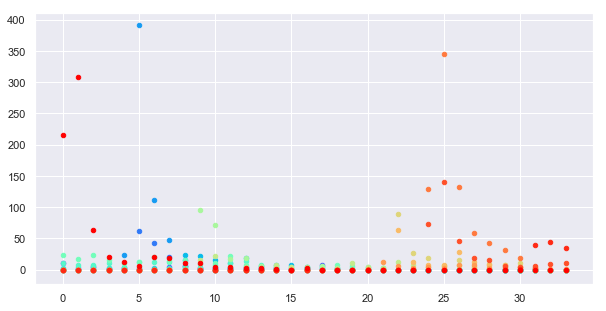

In [1018]:
fig = plt.figure(figsize = (10, 5))
ax1 = fig.add_subplot(111)

num_item = len(item_range)
colors = cm.rainbow(np.linspace(0, 1, num_item))
for i in range(len(item_range)):
    tmp_i = tmp.loc[tmp['item_id'] == item_range[i]]
    ax1.scatter(tmp_i['date_block_num'], tmp_i['item_cnt_month'], 
                s = 20,
                color = colors[i]
               )
    
plt.show()

In [1026]:
#tmp.groupby(['date_block_num']).agg({'item_cnt_month': 'sum'})['item_cnt_month']

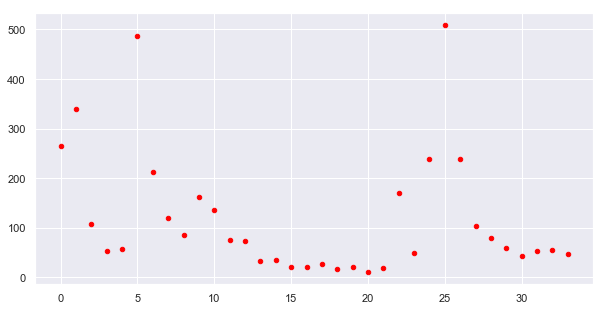

In [1027]:
fig = plt.figure(figsize = (10, 5))
ax1 = fig.add_subplot(111)

num_item = len(item_range)
colors = cm.rainbow(np.linspace(0, 1, num_item))

#tmp_i = tmp.loc[tmp['item_id'] == item_range[i]]
ax1.scatter(tmp_i['date_block_num'], tmp.groupby(['date_block_num']).agg({'item_cnt_month': 'sum'})['item_cnt_month'], 
            s = 20,
            color = colors[i]
           )
    
plt.show()

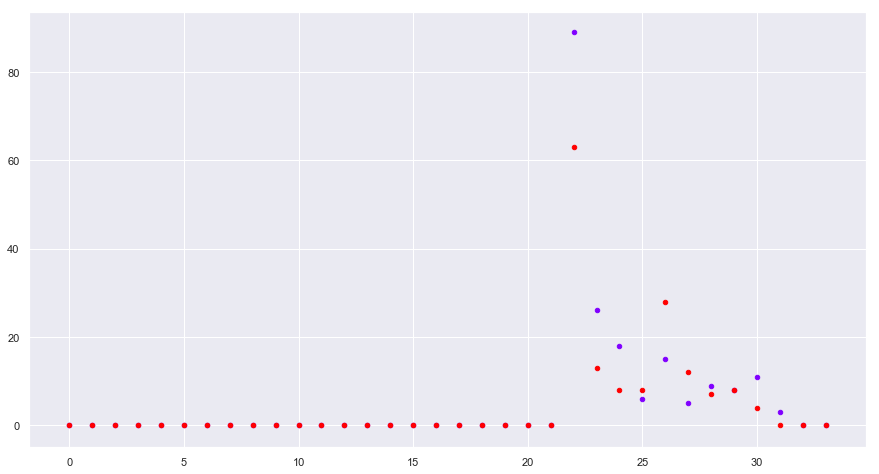

In [1016]:
fig = plt.figure(figsize = (15, 8))
ax1 = fig.add_subplot(111)

num_curv = 2
colors = cm.rainbow(np.linspace(0, 1, num_curv))
off=13
for i in range(num_curv): 
    tmp_i = tmp.loc[tmp['item_id'] == item_range[off+i]]
    ax1.scatter(tmp_i['date_block_num'], tmp_i['item_cnt_month'], 
                s = 20,
                color = colors[i]
               )

plt.show()

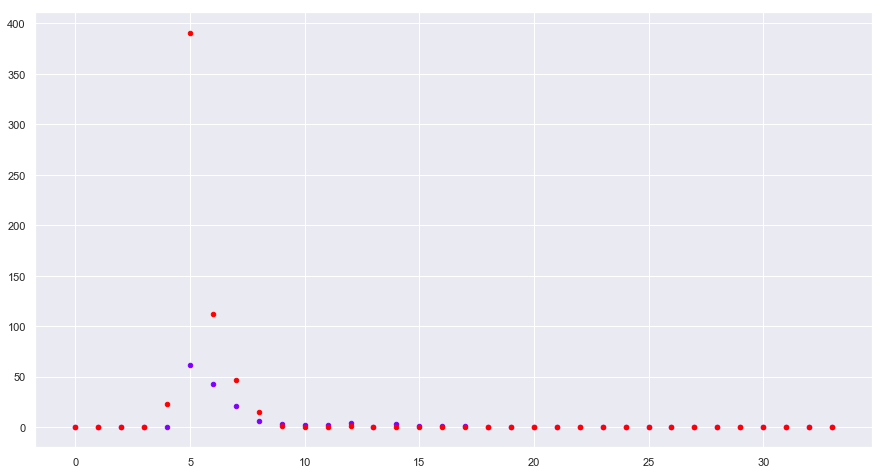

In [1006]:
fig = plt.figure(figsize = (15, 8))
ax1 = fig.add_subplot(111)

num_curv = 2
colors = cm.rainbow(np.linspace(0, 1, num_curv))
lst = [3, 4]
for i in range(num_curv): 
    tmp_i = tmp.loc[tmp['item_id'] == item_range[lst[i]]]
    ax1.scatter(tmp_i['date_block_num'], tmp_i['item_cnt_month'], 
                s = 20,
                color = colors[i]
               )

plt.show()

In [1007]:
item_range[3:5]

[19148.0, 19149.0]

In [1017]:
item.loc[item['item_id'].isin(item_range[13:15])]

item_id  item_category_id
19158    19158                40
19159    19159                37

In [929]:
item_cat.loc[item_cat['item_category_id'].isin([37, 40])]

item_category_id  type_code  subtype_code
37                37         11             1
40                40         11             4

In [728]:
len(item_cat['item_category_id'].unique()),len(item_cat['type_code'].unique()),len(item_cat['subtype_code'].unique())

(84, 20, 65)

In [873]:
gc.collect()

274

In [126]:
def feature_selection_ks_2samp(train, test, threshould):
    pcol = []
    pstats = []
    
    for col in train.columns:
        pcol.append(col)
        pstats.append(abs(stats.ks_2samp(train[col], test[col])[0]))
        gc.collect()
 
    df = pd.DataFrame(data={'col': pcol, 'pstats': pstats}, index=range(len(pcol)))
    df.sort_values(by=['pstats'], inplace=True)
    df.dropna(inplace=True)
    df = df.loc[df['pstats'] >= threshould]

    good_cols = []

    for col in train.columns:
        if col not in df['col'].tolist():
            good_cols.append(col)
    return good_cols

In [127]:
def feature_selection_pearson(X, y, threshould):
    pcol = []
    pcor = []
    pval = []
    #y_value = y['time_to_failure'].values

    for col in X.columns:
        pcol.append(col)
        pcor.append(abs(stats.pearsonr(X[col], y)[0]))
        pval.append(abs(stats.pearsonr(X[col], y)[1]))

    df = pd.DataFrame(data={'col': pcol, 'cor': pcor, 'pval': pval}, index=range(len(pcol)))
    df.sort_values(by=['cor', 'pval'], inplace=True)
    df.dropna(inplace=True)
    df = df.loc[df['pval'] <= threshould]

    drop_cols = []

    for col in X.columns:
        if col not in df['col'].tolist():
            drop_cols.append(col)
    return drop_cols

In [63]:
n_splits = 3
#gkf = GroupKFold(n_splits=n_splits)
kf = KFold(n_splits = n_splits, shuffle = False, random_state = 10)

In [33]:
from math import sqrt

In [34]:
def root_mean_squared_error(y_true, y_pred):
    return sqrt(metrics.mean_squared_error(y_true, y_pred))

In [35]:
#need to implement a way to calculate group mae
def train_model_regression(X, X_test, y, params, folds, molecules, model_type='lgb', eval_metric='mae', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000, groupFold = False):
    """
    A function to train a variety of regression models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'sklearn_scoring_function': metrics.mean_absolute_error},
                    #'group_mae': {'lgb_metric_name': 'mae',
                    #    'catboost_metric_name': 'MAE',
                    #    'scoring_function': group_mean_log_mae},
                    'mse': {'lgb_metric_name': 'mse',
                        'catboost_metric_name': 'MSE',
                        'sklearn_scoring_function': metrics.mean_squared_error},
                    'rmse': {'lgb_metric_name': 'rmse',
                        'catboost_metric_name': 'RMSE',
                        'sklearn_scoring_function': root_mean_squared_error}
                    }

    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros(len(X))
    
    # averaged predictions on train data
    prediction = np.zeros(len(X_test))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    if groupFold == True:
        indexes = folds.split(X, groups = molecules)
    else:
        indexes = folds.split(X)
        
    for fold_n, (train_index, valid_index) in enumerate(indexes):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = n_estimators, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        if eval_metric != 'group_mae':
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
        else:
            scores.append(metrics_dict[eval_metric]['scoring_function'](y_valid, y_pred_valid, X_valid['type']))

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= folds.n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict

In [101]:
cols = [col for col in train.columns if col not in ['item_cnt_month', 'item_cnt_month_new', #'date_block_num',
                        #'item_id', 
                        'shop_id', 
                        'revenue_month'
                                                   ] 
                     #and 'trend' not in col
                     #and 'diff' not in col
                                                   ]

In [95]:
train.head()

date_block_num  shop_id  item_id  revenue_month  item_cnt_month  city_code  \
0               0        2       19    0.000000000             0.0          0   
1               0        2       27    2.498046875             1.0          0   
2               0        2       28    0.000000000             0.0          0   
3               0        2       29    0.000000000             0.0          0   
4               0        2       32    0.000000000             0.0          0   

   item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
0                40         11             4                   0.0   
1                19          5            10                   0.0   
2                30          8            55                   0.0   
3                23          5            16                   0.0   
4                40         11             4                   0.0   

                                   ...                                   \
0                                  ...                                    
1                                  ...                                    
2                                  ...                                    
3                                  ...                                    
4                                  ...                                    

   ['city_code', 'item_category_id']_avg_revenue_month_last_1_mean  \
0                                  0.010711669921875                 
1                                  0.859375000000000                 
2                                  0.302001953125000                 
3                                  0.704101562500000                 
4                                  0.010711669921875                 

   ['city_code', 'item_category_id']_agg_avg_revenue_month_last_1_diff  \
0                                 -0.010711669921875                     
1                                 -0.859375000000000                     
2                                 -0.302001953125000                     
3                                 -0.704101562500000                     
4                                 -0.010711669921875                     

   ['city_code', 'item_category_id']_avg_revenue_month_last_2_mean  \
0                                  0.010467529296875                 
1                                  0.844726562500000                 
2                                  0.297607421875000                 
3                                  0.692382812500000                 
4                                  0.010467529296875                 

   ['city_code', 'item_category_id']_agg_avg_revenue_month_last_2_diff  \
0                                 -0.010467529296875                     
1                                 -0.844726562500000                     
2                                 -0.297607421875000                     
3                                 -0.692382812500000                     
4                                 -0.010467529296875                     

   ['city_code', 'item_category_id']_avg_revenue_month_last_3_mean  \
0                                  0.010223388671875                 
1                                  0.829589843750000                 
2                                  0.293212890625000                 
3                                  0.681152343750000                 
4                                  0.010223388671875                 

   ['city_code', 'item_category_id']_agg_avg_revenue_month_last_3_diff  \
0                                 -0.010223388671875                     
1                                 -0.829589843750000                     
2                                 -0.293212890625000                     
3                                 -0.681152343750000                     
4                                 -0.010223388671875                     

   ['city_code', 'item_category_id']_avg_reven

In [487]:
drop_cols = feature_selection_pearson(train[train['date_block_num'] > 13], train[train['date_block_num'] > 13]['item_cnt_month'], 1)

In [ ]:
#drop_cols = feature_selection_ks_2samp(train, test, thrsould)

In [554]:
len(drop_cols)

226

In [58]:
features = df_feature['feature'].values

In [13]:
#with open('good_col_20191014.pickle', 'wb') as handle:
#    pickle.dump(good_cols, handle, protocol = pickle.HIGHEST_PROTOCOL)

with open('good_col_20191014.pickle', 'rb') as handle:
    good_cols = pickle.load(handle)

In [14]:
features = good_cols

In [15]:
len(features)

377

In [49]:
len(cols)

359

In [94]:
X_t = train_use.loc[(train_use.date_block_num > 13) & (train_use['date_block_num'] <= 33)][::10][cols]
X_test_t = train_use.loc[train_use['date_block_num'] == 34][cols]
y_t = train_use.loc[(train_use.date_block_num > 13) & (train_use['date_block_num'] <= 33)][::10]['item_cnt_month']#.clip(0.1, 10)

In [95]:
gc.collect()

9742

In [217]:
X_test_t.shape

(214200, 228)

In [39]:
# What is colsample_bytree parameter?
# What is subsample parameter?
params = {'num_leaves': 125,                                     
          'min_data_in_leaf': 300,                  # 128 is best                      
          'objective': 'huber',                # huber is the best                        
          'max_depth': 10,                          # 11 is the best           
          'learning_rate': 0.3,                                
          "boosting": "gbdt",             
          "bagging_freq": 1,                                    
          "bagging_fraction": 0.9,                             
          'feature_fraction': 0.8,                  # 0.8 is the best          
          "bagging_seed": 11,                                    
          "metric": 'rmse',                                       
          "verbosity": -1,                                       
          #'reg_alpha': 0.1,                                    
          #'reg_lambda': 0.05,
          'alpha': 0.5                             # 0.7 is the best
         }

In [166]:
#huber loss: 0.9023  0.9019  0.8988  0.9007
# 10 flods: 0.6822

Fold 1 started at Sun Oct 20 18:15:57 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 0.869384	valid_1's rmse: 0.821538
[1000]	training's rmse: 0.815807	valid_1's rmse: 0.818908
[1500]	training's rmse: 0.775699	valid_1's rmse: 0.816945
Early stopping, best iteration is:
[1483]	training's rmse: 0.776642	valid_1's rmse: 0.816746
Fold 2 started at Sun Oct 20 18:19:45 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 0.765538	valid_1's rmse: 1.08347
[1000]	training's rmse: 0.717565	valid_1's rmse: 1.07656
[1500]	training's rmse: 0.679032	valid_1's rmse: 1.07206
[2000]	training's rmse: 0.650044	valid_1's rmse: 1.06969
Early stopping, best iteration is:
[1944]	training's rmse: 0.652774	valid_1's rmse: 1.06952
Fold 3 started at Sun Oct 20 18:25:07 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 0.862116	valid_1's rmse: 0.820039
Early stopping, best iteration is:
[615]

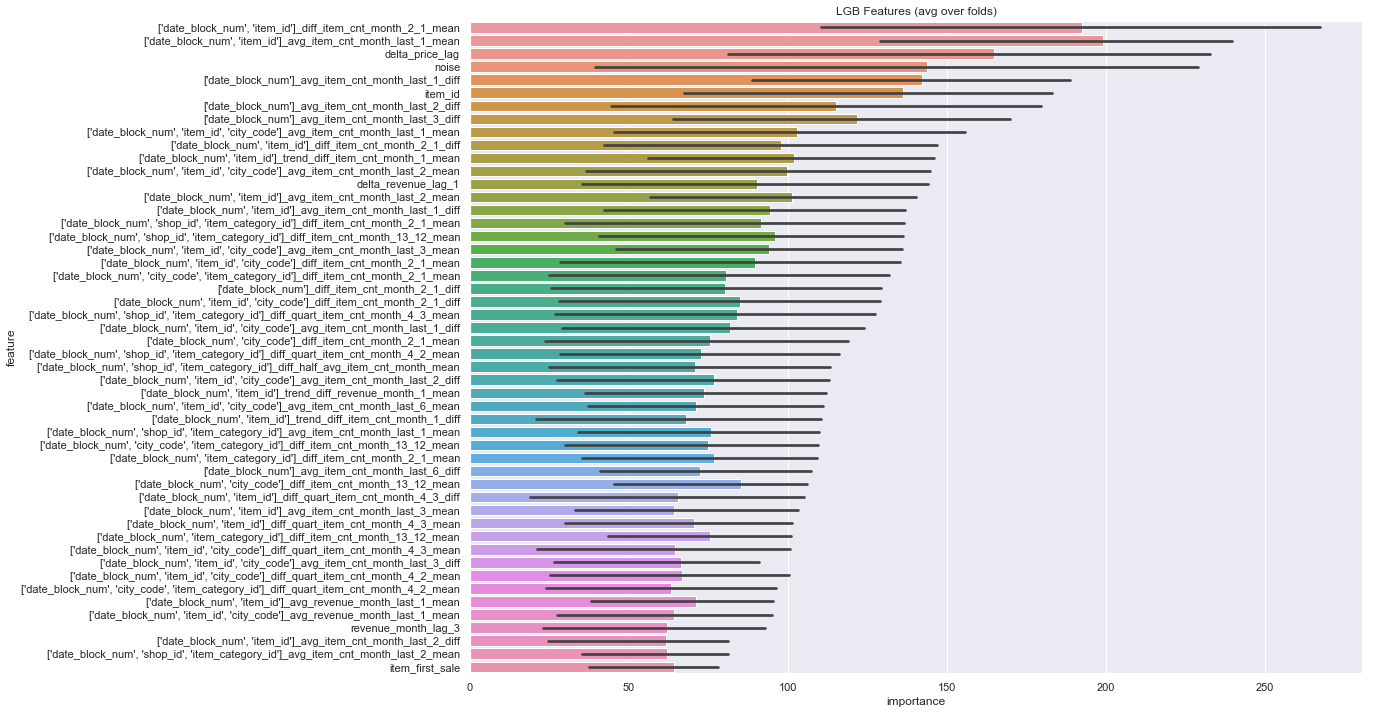

In [96]:
result_dict_lgb_oof = train_model_regression(X=X_t, X_test=X_test_t, y=y_t, molecules = None, 
                                             params=params, folds=kf, model_type='lgb', eval_metric='rmse', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=3000, groupFold = False)

In [47]:
df_ft_importance = result_dict_lgb_oof['feature_importance'].groupby("feature").mean().sort_values(by="importance", ascending=False)
df_ft_importance.reset_index(inplace = True)
df_ft_importance.head(30)

importance  fold
feature                                                                    
avg_item_cnt_month_last_1                           4.111111111111111     2
['date_block_num']_trend_diff_revenue_month_6_mean  3.222222222222222     2
['date_block_num']_trend_diff_revenue_month_3_mean  3.000000000000000     2
['date_block_num', 'shop_id', 'item_id']_avg_it...  2.555555555555556     2
['date_block_num', 'shop_id', 'item_id']_avg_re...  2.333333333333333     2
diff_item_cnt_month_13_12                           1.777777777777778     2
item_shop_last_sale                                 1.444444444444444     2
['date_block_num']_diff_half_avg_item_cnt_month...  0.555555555555555     2
['date_block_num', 'shop_id', 'item_id']_avg_it...  0.222222222222222     2
item_last_sale                                      0.000000000000000     2

In [67]:
train.drop(df_ft_importance.index, axis = 1, inplace = True)

In [68]:
train.shape

(11128004, 292)

In [192]:
df_oof = train_use.loc[train_use['date_block_num']<=33][::10].copy()
df_oof['oof'] = 0
df_predict = train_use.loc[train_use['date_block_num']==34].copy()
df_predict['prediction'] = 0
df_oof ['oof'] = result_dict_lgb_oof['oof']
df_predict['prediction'] = result_dict_lgb_oof['prediction']

# SVR

In [180]:
model = NuSVR(gamma='scale', nu=0.7, tol=0.01, C=1.0)
#oof_svr1, prediction_svr1 = train_model(X=X_train_scaled, X_test=X_test_scaled, params=None, model_type='sklearn', model=model)

In [182]:
#model = model
#model.fit(X_train, Y_train)

y_valid_SVR = model.predict(X_valid).reshape(-1,)
y_test_SVR = model.predict(X_test).reshape(-1,)


In [183]:
score = root_mean_squared_error(Y_valid, y_valid_SVR)
print(f'Score: {score:.4f}.')

Score: 1.0977.


# Iteratively find the best features

In [44]:
import queue as Q
from random import random

In [48]:
def getDuplicateColumns(df):
    duplicateColumnNames = set()
    #goodCol = set()
    
    for x in range(df.shape[1]):
        col = df.iloc[:, x]
        for y in range(x + 1, df.shape[1]):
            otherCol = df.iloc[:, y]
            if col.equals(otherCol):
                #goodCol.add(df.colu)
                duplicateColumnNames.add(df.columns.values[y])
    
    return list(duplicateColumnNames)

In [52]:
def select_features(df, start_features, features_toselect, refine_start, refine_feature, n_features_stop, n_features_calculate, n_Estimators):
    X_t = df
    X_test_t = X_t[:200]
    y_t = X_t['item_cnt_month']
    
    col_tokeep = []
    #features = [col for col in X_t.columns.values]
    if start_features == []:
        col_tokeep = ['city_code']
        scores = [-1.]
    else:
        col_tokeep = list(start_features)
        scores = list(np.zeros(len(start_features)))
        
    duplicate_features = getDuplicateColumns(X_t[features_toselect])
    bad_col = []
    
    for iteration in range(n_features_calculate):
        
        if len(features_toselect) - iteration - len(bad_col) < n_features_stop:
            break
        print(f'Round {iteration + 1}')
        score_best = 100
        index_best = 0
        number = 0
        
        q = Q.PriorityQueue()
        
        for index in range(len(features_toselect)):
            
            if features_toselect[index] in col_tokeep:
                continue
            if len(X_t[features_toselect[index]].unique()) == 1:
                continue
            if features_toselect[index] in duplicate_features:
                continue
            if features_toselect[index] in bad_col:
                continue
                
            value = random()
            if iteration > 15 and value > 0.85:
                continue

            print(f'{number} feature {features_toselect[index]} started at {time.ctime()}')

            number = number + 1
            features_totest = col_tokeep.copy()
            features_totest.append(features_toselect[index])
            X_t_t = X_t[features_totest]
            X_test_t_t = X_test_t[features_totest]

            result_dict_lgb_potential = train_model_regression(X=X_t_t, X_test=X_test_t_t, y=y_t, molecules = None, 
                                     params=params, folds=kf, model_type='lgb', eval_metric='rmse', plot_feature_importance=False,
                                     verbose=500, early_stopping_rounds=200, n_estimators=n_Estimators, groupFold = False)
            score_mean = np.mean(result_dict_lgb_potential['scores'])
            if score_mean < score_best:
                score_best = score_mean
                index_best = index
                
            if iteration > refine_start:
                q.put((-score_mean, index))

        col_tokeep.append(features_toselect[index_best])
        scores.append(score_best)
        if iteration > refine_start and iteration < 25:
            for i in range(refine_feature):
                if not q.empty():
                    temp = q.get()
                    bad_col.append(features_toselect[temp[1]])
                else:
                    break
    dict_feature = {'feature': col_tokeep, 'score': scores}
    df_feature_1J = pd.DataFrame(dict_feature)
    return df_feature_1J, col_tokeep, bad_col

In [54]:
kf = KFold(n_splits = 2, shuffle = False, random_state = 10)

In [50]:
train_testing = train_use.loc[(train_use['date_block_num'] > 13) & (train_use['date_block_num'] <= 33)][::150].copy()

In [16]:
len(train_testing)

38331

In [56]:
df_feature, col_tokeep, bad_col = select_features(df = train_testing, 
                                                  start_features = [], 
                                                  features_toselect = cols, 
                                                  refine_start = 10, 
                                                  refine_feature = 20, 
                                                  n_features_stop = 0, 
                                                  n_features_calculate = 35, 
                                                  n_Estimators = 400)

Round 1
0 feature date_block_num started at Sun Oct 20 11:26:46 2019
Fold 1 started at Sun Oct 20 11:26:46 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 1.18292	valid_1's rmse: 1.1554
Fold 2 started at Sun Oct 20 11:26:46 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 1.15584	valid_1's rmse: 1.18366
CV mean score: 1.1695, std: 0.0141.
1 feature item_id started at Sun Oct 20 11:26:46 2019
Fold 1 started at Sun Oct 20 11:26:46 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 1.18241	valid_1's rmse: 1.15465
Fold 2 started at Sun Oct 20 11:26:47 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 1.15503	valid_1's rmse: 1.18332
CV mean score: 1.1690, std: 0.0143.
2 feature item_category_id sta

Fold 2 started at Sun Oct 20 11:27:05 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[377]	training's rmse: 1.14441	valid_1's rmse: 1.17405
CV mean score: 1.1590, std: 0.0151.
17 feature item_cnt_month_lag_7 started at Sun Oct 20 11:27:05 2019
Fold 1 started at Sun Oct 20 11:27:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[169]	training's rmse: 1.17917	valid_1's rmse: 1.15061
Fold 2 started at Sun Oct 20 11:27:06 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[377]	training's rmse: 1.1472	valid_1's rmse: 1.17703
CV mean score: 1.1638, std: 0.0132.
18 feature item_cnt_month_lag_8 started at Sun Oct 20 11:27:07 2019
Fold 1 started at Sun Oct 20 11:27:07 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 1.18024	valid_1's

[363]	training's rmse: 1.08516	valid_1's rmse: 1.06169
Fold 2 started at Sun Oct 20 11:27:27 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[377]	training's rmse: 1.05494	valid_1's rmse: 1.08377
CV mean score: 1.0727, std: 0.0110.
33 feature ['date_block_num']_avg_item_cnt_month_last_6_mean started at Sun Oct 20 11:27:29 2019
Fold 1 started at Sun Oct 20 11:27:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 1.18292	valid_1's rmse: 1.15529
Fold 2 started at Sun Oct 20 11:27:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 1.15584	valid_1's rmse: 1.18385
CV mean score: 1.1696, std: 0.0143.
34 feature ['date_block_num']_avg_item_cnt_month_last_6_diff started at Sun Oct 20 11:27:29 2019
Fold 1 started at Sun Oct 20 11:27:29 2019
Training until validation scores don't 

62 feature ['date_block_num', 'item_category_id']_avg_item_cnt_month_last_3_diff started at Sun Oct 20 11:28:25 2019
Fold 1 started at Sun Oct 20 11:28:25 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[363]	training's rmse: 1.09779	valid_1's rmse: 1.07359
Fold 2 started at Sun Oct 20 11:28:26 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 1.06824	valid_1's rmse: 1.09591
CV mean score: 1.0848, std: 0.0112.
63 feature ['date_block_num', 'item_category_id']_avg_item_cnt_month_last_6_mean started at Sun Oct 20 11:28:27 2019
Fold 1 started at Sun Oct 20 11:28:27 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 1.17991	valid_1's rmse: 1.15213
Fold 2 started at Sun Oct 20 11:28:27 2019
Training until validation scores don't improve for 200 rounds.
Early stoppi

91 feature ['date_block_num', 'item_id', 'city_code']_avg_item_cnt_month_last_3_mean started at Sun Oct 20 11:29:20 2019
Fold 1 started at Sun Oct 20 11:29:20 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[363]	training's rmse: 1.11419	valid_1's rmse: 1.08391
Fold 2 started at Sun Oct 20 11:29:21 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 1.07708	valid_1's rmse: 1.1109
CV mean score: 1.0974, std: 0.0135.
92 feature ['date_block_num', 'item_id', 'city_code']_avg_item_cnt_month_last_3_diff started at Sun Oct 20 11:29:22 2019
Fold 1 started at Sun Oct 20 11:29:22 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[386]	training's rmse: 1.15912	valid_1's rmse: 1.13457
Fold 2 started at Sun Oct 20 11:29:23 2019
Training until validation scores don't improve for 20

[1]	training's rmse: 1.15364	valid_1's rmse: 1.18158
CV mean score: 1.1675, std: 0.0141.
121 feature revenue_month_lag_10 started at Sun Oct 20 11:30:18 2019
Fold 1 started at Sun Oct 20 11:30:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 1.1817	valid_1's rmse: 1.15385
Fold 2 started at Sun Oct 20 11:30:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 1.15393	valid_1's rmse: 1.18217
CV mean score: 1.1680, std: 0.0142.
122 feature revenue_month_lag_11 started at Sun Oct 20 11:30:19 2019
Fold 1 started at Sun Oct 20 11:30:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 1.18187	valid_1's rmse: 1.15396
Fold 2 started at Sun Oct 20 11:30:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's 

[375]	training's rmse: 1.14334	valid_1's rmse: 1.11457
Fold 2 started at Sun Oct 20 11:30:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[161]	training's rmse: 1.09937	valid_1's rmse: 1.13808
CV mean score: 1.1263, std: 0.0118.
137 feature ['date_block_num', 'shop_id']_avg_revenue_month_last_2_mean started at Sun Oct 20 11:30:42 2019
Fold 1 started at Sun Oct 20 11:30:42 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 1.17961	valid_1's rmse: 1.1532
Fold 2 started at Sun Oct 20 11:30:42 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 1.15287	valid_1's rmse: 1.18001
CV mean score: 1.1666, std: 0.0134.
138 feature ['date_block_num', 'shop_id']_avg_revenue_month_last_2_diff started at Sun Oct 20 11:30:43 2019
Fold 1 started at Sun Oct 20 11:30:43 2019
Training until validation score

166 feature ['date_block_num', 'city_code']_avg_revenue_month_last_1_diff started at Sun Oct 20 11:31:36 2019
Fold 1 started at Sun Oct 20 11:31:36 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[375]	training's rmse: 1.1375	valid_1's rmse: 1.10796
Fold 2 started at Sun Oct 20 11:31:37 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 1.09403	valid_1's rmse: 1.13649
CV mean score: 1.1222, std: 0.0143.
167 feature ['date_block_num', 'city_code']_avg_revenue_month_last_2_mean started at Sun Oct 20 11:31:38 2019
Fold 1 started at Sun Oct 20 11:31:38 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 1.18126	valid_1's rmse: 1.15425
Fold 2 started at Sun Oct 20 11:31:39 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iterat

[1]	training's rmse: 1.15239	valid_1's rmse: 1.18019
CV mean score: 1.1648, std: 0.0154.
195 feature ['date_block_num', 'city_code', 'item_category_id']_avg_revenue_month_last_1_mean started at Sun Oct 20 11:32:35 2019
Fold 1 started at Sun Oct 20 11:32:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 1.17784	valid_1's rmse: 1.15089
Fold 2 started at Sun Oct 20 11:32:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 1.15084	valid_1's rmse: 1.17862
CV mean score: 1.1648, std: 0.0139.
196 feature ['date_block_num', 'city_code', 'item_category_id']_avg_revenue_month_last_1_diff started at Sun Oct 20 11:32:36 2019
Fold 1 started at Sun Oct 20 11:32:36 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[375]	training's rmse: 1.14479	valid_1's rmse: 1.11564
Fold 2 started at 

[377]	training's rmse: 1.12149	valid_1's rmse: 1.15791
CV mean score: 1.1419, std: 0.0160.
225 feature ['date_block_num', 'item_id']_trend_diff_item_cnt_month_3_mean started at Sun Oct 20 11:33:38 2019
Fold 1 started at Sun Oct 20 11:33:38 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[335]	training's rmse: 1.16855	valid_1's rmse: 1.13736
Fold 2 started at Sun Oct 20 11:33:39 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[294]	training's rmse: 1.13177	valid_1's rmse: 1.16762
CV mean score: 1.1525, std: 0.0151.
226 feature ['date_block_num', 'item_id']_trend_diff_item_cnt_month_3_diff started at Sun Oct 20 11:33:40 2019
Fold 1 started at Sun Oct 20 11:33:40 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[292]	training's rmse: 1.15591	valid_1's rmse: 1.12689
Fold 2 started at Sun Oc

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[374]	training's rmse: 1.14042	valid_1's rmse: 1.1103
Fold 2 started at Sun Oct 20 11:34:36 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[382]	training's rmse: 1.10533	valid_1's rmse: 1.14357
CV mean score: 1.1269, std: 0.0166.
255 feature ['date_block_num']_trend_diff_item_cnt_month_2_mean started at Sun Oct 20 11:34:37 2019
Fold 1 started at Sun Oct 20 11:34:37 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 1.18292	valid_1's rmse: 1.15534
Fold 2 started at Sun Oct 20 11:34:38 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 1.15584	valid_1's rmse: 1.18385
CV mean score: 1.1696, std: 0.0143.
256 feature ['date_block_num']_trend_diff_item_cnt_month_2_diff st

CV mean score: 1.1697, std: 0.0142.
285 feature ['date_block_num']_diff_item_cnt_month_2_1_diff started at Sun Oct 20 11:35:25 2019
Fold 1 started at Sun Oct 20 11:35:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[148]	training's rmse: 1.14944	valid_1's rmse: 1.11682
Fold 2 started at Sun Oct 20 11:35:26 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[382]	training's rmse: 1.11734	valid_1's rmse: 1.15498
CV mean score: 1.1359, std: 0.0191.
286 feature ['date_block_num', 'item_id']_diff_quart_item_cnt_month_4_3_mean started at Sun Oct 20 11:35:27 2019
Fold 1 started at Sun Oct 20 11:35:27 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[397]	training's rmse: 1.17062	valid_1's rmse: 1.14153
Fold 2 started at Sun Oct 20 11:35:28 2019
Training until validation scores don't improve for 200 rounds.

[1]	training's rmse: 1.18194	valid_1's rmse: 1.15495
Fold 2 started at Sun Oct 20 11:36:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 1.15479	valid_1's rmse: 1.18357
CV mean score: 1.1693, std: 0.0143.
315 feature ['date_block_num', 'city_code']_diff_item_cnt_month_2_1_diff started at Sun Oct 20 11:36:18 2019
Fold 1 started at Sun Oct 20 11:36:18 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[395]	training's rmse: 1.14793	valid_1's rmse: 1.11659
Fold 2 started at Sun Oct 20 11:36:19 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[382]	training's rmse: 1.11432	valid_1's rmse: 1.15236
CV mean score: 1.1345, std: 0.0179.
316 feature ['date_block_num', 'shop_id', 'item_category_id']_diff_quart_item_cnt_month_4_3_mean started at Sun Oct 20 11:36:20 2019
Fold 1 started at Sun

[1]	training's rmse: 1.18028	valid_1's rmse: 1.15342
Fold 2 started at Sun Oct 20 11:37:04 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 1.15335	valid_1's rmse: 1.18114
CV mean score: 1.1673, std: 0.0139.
344 feature ['date_block_num', 'city_code', 'item_category_id']_diff_item_cnt_month_2_1_mean started at Sun Oct 20 11:37:05 2019
Fold 1 started at Sun Oct 20 11:37:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 1.17957	valid_1's rmse: 1.15246
Fold 2 started at Sun Oct 20 11:37:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 1.15263	valid_1's rmse: 1.18047
CV mean score: 1.1665, std: 0.0140.
345 feature ['date_block_num', 'city_code', 'item_category_id']_diff_item_cnt_month_2_1_diff started at Sun Oct 20 11:37:06 2019
Fold 1 started at Sun Oct 20 11:37:

[195]	training's rmse: 1.03772	valid_1's rmse: 1.07074
CV mean score: 1.0578, std: 0.0130.
29 feature ['date_block_num']_avg_item_cnt_month_last_2_mean started at Sun Oct 20 11:38:23 2019
Fold 1 started at Sun Oct 20 11:38:23 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[374]	training's rmse: 1.07511	valid_1's rmse: 1.05694
Fold 2 started at Sun Oct 20 11:38:24 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 1.04529	valid_1's rmse: 1.07985
CV mean score: 1.0684, std: 0.0115.
30 feature ['date_block_num']_avg_item_cnt_month_last_3_mean started at Sun Oct 20 11:38:26 2019
Fold 1 started at Sun Oct 20 11:38:26 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[349]	training's rmse: 1.0754	valid_1's rmse: 1.05384
Fold 2 started at Sun Oct 20 11:38:27 2019
Training u

Fold 1 started at Sun Oct 20 11:39:35 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[383]	training's rmse: 1.0678	valid_1's rmse: 1.05361
Fold 2 started at Sun Oct 20 11:39:37 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[397]	training's rmse: 1.03732	valid_1's rmse: 1.0774
CV mean score: 1.0655, std: 0.0119.
59 feature ['date_block_num', 'item_category_id']_avg_item_cnt_month_last_2_diff started at Sun Oct 20 11:39:38 2019
Fold 1 started at Sun Oct 20 11:39:38 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[386]	training's rmse: 1.07282	valid_1's rmse: 1.05335
Fold 2 started at Sun Oct 20 11:39:39 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 1.04103	valid_1's rmse: 1.07745
CV mean score

[399]	training's rmse: 1.02934	valid_1's rmse: 1.06654
CV mean score: 1.0550, std: 0.0116.
87 feature ['date_block_num', 'item_id', 'city_code']_avg_item_cnt_month_last_1_diff started at Sun Oct 20 11:40:53 2019
Fold 1 started at Sun Oct 20 11:40:53 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[392]	training's rmse: 1.07649	valid_1's rmse: 1.0526
Fold 2 started at Sun Oct 20 11:40:55 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[397]	training's rmse: 1.04474	valid_1's rmse: 1.07851
CV mean score: 1.0656, std: 0.0130.
88 feature ['date_block_num', 'item_id', 'city_code']_avg_item_cnt_month_last_2_mean started at Sun Oct 20 11:40:56 2019
Fold 1 started at Sun Oct 20 11:40:56 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[386]	training's rmse: 1.07622	valid_1's rmse: 1.05217
Fold 

116 feature avg_revenue_month_last_6 started at Sun Oct 20 11:42:12 2019
Fold 1 started at Sun Oct 20 11:42:12 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[374]	training's rmse: 1.07125	valid_1's rmse: 1.05088
Fold 2 started at Sun Oct 20 11:42:14 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[395]	training's rmse: 1.03156	valid_1's rmse: 1.07666
CV mean score: 1.0638, std: 0.0129.
117 feature revenue_month_lag_7 started at Sun Oct 20 11:42:15 2019
Fold 1 started at Sun Oct 20 11:42:15 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[375]	training's rmse: 1.07559	valid_1's rmse: 1.05413
Fold 2 started at Sun Oct 20 11:42:16 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[394]	training's rmse: 1.04279	valid_1's r

[399]	training's rmse: 1.03136	valid_1's rmse: 1.07455
CV mean score: 1.0599, std: 0.0146.
146 feature ['date_block_num', 'item_id']_avg_revenue_month_last_2_mean started at Sun Oct 20 11:43:31 2019
Fold 1 started at Sun Oct 20 11:43:31 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[392]	training's rmse: 1.06789	valid_1's rmse: 1.05017
Fold 2 started at Sun Oct 20 11:43:32 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 1.03375	valid_1's rmse: 1.07372
CV mean score: 1.0619, std: 0.0118.
147 feature ['date_block_num', 'item_id']_avg_revenue_month_last_2_diff started at Sun Oct 20 11:43:34 2019
Fold 1 started at Sun Oct 20 11:43:34 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[392]	training's rmse: 1.06848	valid_1's rmse: 1.04778
Fold 2 started at Sun Oct 20 1

[397]	training's rmse: 1.03054	valid_1's rmse: 1.06784
CV mean score: 1.0585, std: 0.0094.
175 feature ['date_block_num', 'shop_id', 'item_category_id']_avg_revenue_month_last_1_diff started at Sun Oct 20 11:45:00 2019
Fold 1 started at Sun Oct 20 11:45:00 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[392]	training's rmse: 1.07033	valid_1's rmse: 1.04966
Fold 2 started at Sun Oct 20 11:45:01 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 1.03298	valid_1's rmse: 1.07535
CV mean score: 1.0625, std: 0.0128.
176 feature ['date_block_num', 'shop_id', 'item_category_id']_avg_revenue_month_last_2_mean started at Sun Oct 20 11:45:03 2019
Fold 1 started at Sun Oct 20 11:45:03 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[392]	training's rmse: 1.06442	valid_1's rmse

203 feature ['date_block_num', 'city_code', 'item_category_id']_avg_revenue_month_last_12_diff started at Sun Oct 20 11:46:18 2019
Fold 1 started at Sun Oct 20 11:46:18 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[393]	training's rmse: 1.07117	valid_1's rmse: 1.05274
Fold 2 started at Sun Oct 20 11:46:19 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[397]	training's rmse: 1.03532	valid_1's rmse: 1.07774
CV mean score: 1.0652, std: 0.0125.
204 feature trend_diff_item_cnt_month_2 started at Sun Oct 20 11:46:21 2019
Fold 1 started at Sun Oct 20 11:46:21 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[383]	training's rmse: 1.0744	valid_1's rmse: 1.05432
Fold 2 started at Sun Oct 20 11:46:22 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stoppi

[386]	training's rmse: 1.07168	valid_1's rmse: 1.05057
Fold 2 started at Sun Oct 20 11:46:59 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 1.03375	valid_1's rmse: 1.07863
CV mean score: 1.0646, std: 0.0140.
219 feature trend_ratio_revenue_month_1 started at Sun Oct 20 11:47:01 2019
Fold 1 started at Sun Oct 20 11:47:01 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[374]	training's rmse: 1.07358	valid_1's rmse: 1.05101
Fold 2 started at Sun Oct 20 11:47:02 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 1.03536	valid_1's rmse: 1.07532
CV mean score: 1.0632, std: 0.0122.
220 feature ['date_block_num', 'item_id']_trend_diff_item_cnt_month_1_mean started at Sun Oct 20 11:47:03 2019
Fold 1 started at Sun Oct 20 11:47:03 2019
Training until v

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[393]	training's rmse: 1.07047	valid_1's rmse: 1.05362
Fold 2 started at Sun Oct 20 11:48:27 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 1.03342	valid_1's rmse: 1.07946
CV mean score: 1.0665, std: 0.0129.
248 feature ['date_block_num', 'item_category_id']_trend_diff_revenue_month_3_mean started at Sun Oct 20 11:48:28 2019
Fold 1 started at Sun Oct 20 11:48:28 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[374]	training's rmse: 1.06958	valid_1's rmse: 1.05679
Fold 2 started at Sun Oct 20 11:48:30 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 1.03829	valid_1's rmse: 1.07826
CV mean score: 1.0675, std: 0.0107.
249 feature ['da

Fold 1 started at Sun Oct 20 11:49:45 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[139]	training's rmse: 1.07968	valid_1's rmse: 1.06131
Fold 2 started at Sun Oct 20 11:49:46 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[395]	training's rmse: 1.04567	valid_1's rmse: 1.08102
CV mean score: 1.0712, std: 0.0099.
278 feature ['date_block_num']_diff_quart_item_cnt_month_4_2_diff started at Sun Oct 20 11:49:47 2019
Fold 1 started at Sun Oct 20 11:49:47 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[386]	training's rmse: 1.07492	valid_1's rmse: 1.05537
Fold 2 started at Sun Oct 20 11:49:48 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[388]	training's rmse: 1.04315	valid_1's rmse: 1.07943
CV mean score: 1.0674, std: 0.0120.
279

Fold 1 started at Sun Oct 20 11:51:01 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[386]	training's rmse: 1.07435	valid_1's rmse: 1.05518
Fold 2 started at Sun Oct 20 11:51:03 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[388]	training's rmse: 1.04355	valid_1's rmse: 1.07985
CV mean score: 1.0675, std: 0.0123.
307 feature ['date_block_num', 'city_code']_diff_quart_item_cnt_month_4_2_mean started at Sun Oct 20 11:51:04 2019
Fold 1 started at Sun Oct 20 11:51:04 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[374]	training's rmse: 1.07374	valid_1's rmse: 1.06287
Fold 2 started at Sun Oct 20 11:51:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[174]	training's rmse: 1.04819	valid_1's rmse: 1.08105
CV mean score: 1.0720, std

Fold 2 started at Sun Oct 20 11:52:21 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[397]	training's rmse: 1.04339	valid_1's rmse: 1.07891
CV mean score: 1.0657, std: 0.0132.
335 feature ['date_block_num', 'city_code', 'item_category_id']_diff_quart_item_cnt_month_4_3_mean started at Sun Oct 20 11:52:22 2019
Fold 1 started at Sun Oct 20 11:52:22 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[392]	training's rmse: 1.06879	valid_1's rmse: 1.05413
Fold 2 started at Sun Oct 20 11:52:23 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[397]	training's rmse: 1.0378	valid_1's rmse: 1.0759
CV mean score: 1.0650, std: 0.0109.
336 feature ['date_block_num', 'city_code', 'item_category_id']_diff_quart_item_cnt_month_4_3_diff started at Sun Oct 20 11:52:25 2019
Fold 1 started at Sun Oct 20 11:5

[400]	training's rmse: 1.0173	valid_1's rmse: 1.06206
CV mean score: 1.0485, std: 0.0135.
20 feature item_cnt_month_lag_10 started at Sun Oct 20 11:53:47 2019
Fold 1 started at Sun Oct 20 11:53:47 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[377]	training's rmse: 1.05608	valid_1's rmse: 1.03549
Fold 2 started at Sun Oct 20 11:53:48 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 1.01633	valid_1's rmse: 1.06285
CV mean score: 1.0492, std: 0.0137.
21 feature item_cnt_month_lag_11 started at Sun Oct 20 11:53:50 2019
Fold 1 started at Sun Oct 20 11:53:50 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[386]	training's rmse: 1.054	valid_1's rmse: 1.03532
Fold 2 started at Sun Oct 20 11:53:51 2019
Training until validation scores don't improve for 200 rounds.
Did n

Fold 2 started at Sun Oct 20 11:55:09 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 1.01452	valid_1's rmse: 1.06426
CV mean score: 1.0494, std: 0.0148.
50 feature ['date_block_num', 'item_id']_avg_item_cnt_month_last_3_diff started at Sun Oct 20 11:55:10 2019
Fold 1 started at Sun Oct 20 11:55:10 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[389]	training's rmse: 1.04621	valid_1's rmse: 1.02636
Fold 2 started at Sun Oct 20 11:55:12 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 1.00357	valid_1's rmse: 1.05671
CV mean score: 1.0415, std: 0.0152.
51 feature ['date_block_num', 'item_id']_avg_item_cnt_month_last_6_mean started at Sun Oct 20 11:55:13 2019
Fold 1 started at Sun Oct 20 11:55:13 2019
Training until validation scores don't imp

[385]	training's rmse: 1.04248	valid_1's rmse: 1.02973
Fold 2 started at Sun Oct 20 11:56:28 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 1.00692	valid_1's rmse: 1.05531
CV mean score: 1.0425, std: 0.0128.
79 feature ['date_block_num', 'shop_id', 'item_category_id']_avg_item_cnt_month_last_3_mean started at Sun Oct 20 11:56:29 2019
Fold 1 started at Sun Oct 20 11:56:29 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[389]	training's rmse: 1.02989	valid_1's rmse: 1.01864
Fold 2 started at Sun Oct 20 11:56:31 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.998973	valid_1's rmse: 1.05168
CV mean score: 1.0352, std: 0.0165.
80 feature ['date_block_num', 'shop_id', 'item_category_id']_avg_item_cnt_month_last_3_diff started at Sun Oct 20 11:

[164]	training's rmse: 1.02142	valid_1's rmse: 1.06878
CV mean score: 1.0541, std: 0.0146.
107 feature revenue_month_lag_1 started at Sun Oct 20 11:57:48 2019
Fold 1 started at Sun Oct 20 11:57:48 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[386]	training's rmse: 1.05663	valid_1's rmse: 1.03353
Fold 2 started at Sun Oct 20 11:57:49 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 1.01092	valid_1's rmse: 1.06234
CV mean score: 1.0479, std: 0.0144.
108 feature revenue_month_lag_2 started at Sun Oct 20 11:57:51 2019
Fold 1 started at Sun Oct 20 11:57:51 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[386]	training's rmse: 1.05546	valid_1's rmse: 1.03661
Fold 2 started at Sun Oct 20 11:57:52 2019
Training until validation scores don't improve for 200 rounds.
Did 

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[383]	training's rmse: 1.04365	valid_1's rmse: 1.03331
Fold 2 started at Sun Oct 20 11:59:12 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.999599	valid_1's rmse: 1.04949
CV mean score: 1.0414, std: 0.0081.
138 feature ['date_block_num', 'shop_id']_avg_revenue_month_last_3_diff started at Sun Oct 20 11:59:13 2019
Fold 1 started at Sun Oct 20 11:59:13 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[386]	training's rmse: 1.05231	valid_1's rmse: 1.03405
Fold 2 started at Sun Oct 20 11:59:14 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 1.01002	valid_1's rmse: 1.062
CV mean score: 1.0480, std: 0.0140.
139 feature ['date_block_num

Fold 1 started at Sun Oct 20 12:00:26 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[386]	training's rmse: 1.05431	valid_1's rmse: 1.03762
Fold 2 started at Sun Oct 20 12:00:27 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 1.01331	valid_1's rmse: 1.06467
CV mean score: 1.0511, std: 0.0135.
167 feature ['date_block_num', 'city_code']_avg_revenue_month_last_3_mean started at Sun Oct 20 12:00:28 2019
Fold 1 started at Sun Oct 20 12:00:28 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[385]	training's rmse: 1.05256	valid_1's rmse: 1.03998
Fold 2 started at Sun Oct 20 12:00:30 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 1.01004	valid_1's rmse: 1.05778
CV mean score: 1.0

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 1.00686	valid_1's rmse: 1.06086
CV mean score: 1.0475, std: 0.0133.
195 feature ['date_block_num', 'city_code', 'item_category_id']_avg_revenue_month_last_2_mean started at Sun Oct 20 12:01:43 2019
Fold 1 started at Sun Oct 20 12:01:43 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[386]	training's rmse: 1.04588	valid_1's rmse: 1.03294
Fold 2 started at Sun Oct 20 12:01:45 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 1.00703	valid_1's rmse: 1.05979
CV mean score: 1.0464, std: 0.0134.
196 feature ['date_block_num', 'city_code', 'item_category_id']_avg_revenue_month_last_2_diff started at Sun Oct 20 12:01:46 2019
Fold 1 started at Sun Oct 20 12:01:46 2019
Training until validation scores don't im

[386]	training's rmse: 1.05071	valid_1's rmse: 1.03404
Fold 2 started at Sun Oct 20 12:03:00 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 1.00842	valid_1's rmse: 1.06073
CV mean score: 1.0474, std: 0.0133.
225 feature ['date_block_num', 'item_id']_trend_diff_item_cnt_month_6_mean started at Sun Oct 20 12:03:02 2019
Fold 1 started at Sun Oct 20 12:03:02 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[386]	training's rmse: 1.05038	valid_1's rmse: 1.03431
Fold 2 started at Sun Oct 20 12:03:03 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 1.01152	valid_1's rmse: 1.06331
CV mean score: 1.0488, std: 0.0145.
226 feature ['date_block_num', 'item_id']_trend_diff_item_cnt_month_6_diff started at Sun Oct 20 12:03:04 2019
Fold 1 started at Sun Oc

Fold 1 started at Sun Oct 20 12:04:16 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[386]	training's rmse: 1.05407	valid_1's rmse: 1.03588
Fold 2 started at Sun Oct 20 12:04:17 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 1.01577	valid_1's rmse: 1.06667
CV mean score: 1.0513, std: 0.0154.
254 feature ['date_block_num']_trend_diff_item_cnt_month_2_diff started at Sun Oct 20 12:04:18 2019
Fold 1 started at Sun Oct 20 12:04:18 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[385]	training's rmse: 1.05091	valid_1's rmse: 1.03567
Fold 2 started at Sun Oct 20 12:04:19 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 1.01245	valid_1's rmse: 1.06382
CV mean score: 1.0497, std: 

Fold 1 started at Sun Oct 20 12:05:33 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[386]	training's rmse: 1.05301	valid_1's rmse: 1.03282
Fold 2 started at Sun Oct 20 12:05:34 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 1.01347	valid_1's rmse: 1.06658
CV mean score: 1.0497, std: 0.0169.
284 feature ['date_block_num', 'item_id']_diff_quart_item_cnt_month_4_3_mean started at Sun Oct 20 12:05:35 2019
Fold 1 started at Sun Oct 20 12:05:35 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[386]	training's rmse: 1.04895	valid_1's rmse: 1.03545
Fold 2 started at Sun Oct 20 12:05:37 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 1.0144	valid_1's rmse: 1.06342
CV mean score: 1

CV mean score: 1.0511, std: 0.0108.
312 feature ['date_block_num', 'city_code']_diff_item_cnt_month_2_1_mean started at Sun Oct 20 12:06:50 2019
Fold 1 started at Sun Oct 20 12:06:50 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[382]	training's rmse: 1.05377	valid_1's rmse: 1.03798
Fold 2 started at Sun Oct 20 12:06:51 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 1.01278	valid_1's rmse: 1.06111
CV mean score: 1.0495, std: 0.0116.
313 feature ['date_block_num', 'city_code']_diff_item_cnt_month_2_1_diff started at Sun Oct 20 12:06:52 2019
Fold 1 started at Sun Oct 20 12:06:52 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[386]	training's rmse: 1.05256	valid_1's rmse: 1.03251
Fold 2 started at Sun Oct 20 12:06:54 2019
Training until validation scores don't i

340 feature ['date_block_num', 'city_code', 'item_category_id']_diff_item_cnt_month_13_12_mean started at Sun Oct 20 12:08:06 2019
Fold 1 started at Sun Oct 20 12:08:06 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[392]	training's rmse: 1.04569	valid_1's rmse: 1.03684
Fold 2 started at Sun Oct 20 12:08:07 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 1.00786	valid_1's rmse: 1.05692
CV mean score: 1.0469, std: 0.0100.
341 feature ['date_block_num', 'city_code', 'item_category_id']_diff_item_cnt_month_13_12_diff started at Sun Oct 20 12:08:08 2019
Fold 1 started at Sun Oct 20 12:08:08 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[383]	training's rmse: 1.04949	valid_1's rmse: 1.03961
Fold 2 started at Sun Oct 20 12:08:10 2019
Training until validation scores

[389]	training's rmse: 1.02235	valid_1's rmse: 1.01137
Fold 2 started at Sun Oct 20 12:08:48 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.993644	valid_1's rmse: 1.04141
CV mean score: 1.0264, std: 0.0150.
12 feature item_cnt_month_lag_2 started at Sun Oct 20 12:08:49 2019
Fold 1 started at Sun Oct 20 12:08:49 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[386]	training's rmse: 1.02572	valid_1's rmse: 1.0123
Fold 2 started at Sun Oct 20 12:08:50 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.99236	valid_1's rmse: 1.04422
CV mean score: 1.0283, std: 0.0160.
13 feature item_cnt_month_lag_3 started at Sun Oct 20 12:08:52 2019
Fold 1 started at Sun Oct 20 12:08:52 2019
Training until validation scores don't improve for 200 rounds.
Did 

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.991782	valid_1's rmse: 1.04176
CV mean score: 1.0262, std: 0.0156.
42 feature ['date_block_num', 'shop_id']_avg_item_cnt_month_last_6_mean started at Sun Oct 20 12:10:11 2019
Fold 1 started at Sun Oct 20 12:10:11 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[397]	training's rmse: 1.01682	valid_1's rmse: 1.00802
Fold 2 started at Sun Oct 20 12:10:12 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.982175	valid_1's rmse: 1.0407
CV mean score: 1.0244, std: 0.0163.
43 feature ['date_block_num', 'shop_id']_avg_item_cnt_month_last_6_diff started at Sun Oct 20 12:10:13 2019
Fold 1 started at Sun Oct 20 12:10:13 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early st

[386]	training's rmse: 1.01916	valid_1's rmse: 1.0121
Fold 2 started at Sun Oct 20 12:11:26 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.989149	valid_1's rmse: 1.04448
CV mean score: 1.0283, std: 0.0162.
71 feature ['date_block_num', 'city_code']_avg_item_cnt_month_last_6_diff started at Sun Oct 20 12:11:28 2019
Fold 1 started at Sun Oct 20 12:11:28 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[389]	training's rmse: 1.01958	valid_1's rmse: 1.01147
Fold 2 started at Sun Oct 20 12:11:29 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.991263	valid_1's rmse: 1.04171
CV mean score: 1.0266, std: 0.0151.
72 feature ['date_block_num', 'city_code']_avg_item_cnt_month_last_12_mean started at Sun Oct 20 12:11:30 2019
Fold 1 started at Sun Oc

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.982325	valid_1's rmse: 1.03693
CV mean score: 1.0212, std: 0.0157.
99 feature ['date_block_num', 'city_code', 'item_category_id']_avg_item_cnt_month_last_3_diff started at Sun Oct 20 12:12:44 2019
Fold 1 started at Sun Oct 20 12:12:44 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 1.01378	valid_1's rmse: 1.01034
Fold 2 started at Sun Oct 20 12:12:45 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.986553	valid_1's rmse: 1.03631
CV mean score: 1.0233, std: 0.0130.
100 feature ['date_block_num', 'city_code', 'item_category_id']_avg_item_cnt_month_last_6_mean started at Sun Oct 20 12:12:47 2019
Fold 1 started at Sun Oct 20 12:12:47 2019
Training until validation scores don't

[399]	training's rmse: 0.994412	valid_1's rmse: 1.0441
CV mean score: 1.0278, std: 0.0163.
129 feature ['date_block_num']_avg_revenue_month_last_6_diff started at Sun Oct 20 12:14:06 2019
Fold 1 started at Sun Oct 20 12:14:06 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[392]	training's rmse: 1.0236	valid_1's rmse: 1.013
Fold 2 started at Sun Oct 20 12:14:07 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.991053	valid_1's rmse: 1.04666
CV mean score: 1.0298, std: 0.0168.
130 feature ['date_block_num']_avg_revenue_month_last_12_mean started at Sun Oct 20 12:14:09 2019
Fold 1 started at Sun Oct 20 12:14:09 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[393]	training's rmse: 1.02232	valid_1's rmse: 1.00857
Fold 2 started at Sun Oct 20 12:14:10 2019
Training u

[386]	training's rmse: 1.0224	valid_1's rmse: 1.00946
Fold 2 started at Sun Oct 20 12:14:44 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.989636	valid_1's rmse: 1.04458
CV mean score: 1.0270, std: 0.0176.
144 feature ['date_block_num', 'item_id']_avg_revenue_month_last_2_mean started at Sun Oct 20 12:14:46 2019
Fold 1 started at Sun Oct 20 12:14:46 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[389]	training's rmse: 1.0216	valid_1's rmse: 1.01327
Fold 2 started at Sun Oct 20 12:14:47 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.991847	valid_1's rmse: 1.04424
CV mean score: 1.0288, std: 0.0155.
145 feature ['date_block_num', 'item_id']_avg_revenue_month_last_2_diff started at Sun Oct 20 12:14:48 2019
Fold 1 started at Sun Oct 20 1

Fold 1 started at Sun Oct 20 12:16:02 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[393]	training's rmse: 1.00982	valid_1's rmse: 1.00737
Fold 2 started at Sun Oct 20 12:16:03 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.98096	valid_1's rmse: 1.03349
CV mean score: 1.0204, std: 0.0131.
173 feature ['date_block_num', 'shop_id', 'item_category_id']_avg_revenue_month_last_1_diff started at Sun Oct 20 12:16:04 2019
Fold 1 started at Sun Oct 20 12:16:04 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 1.01424	valid_1's rmse: 1.00903
Fold 2 started at Sun Oct 20 12:16:06 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.982863	valid_1's rmse: 1.03583

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[386]	training's rmse: 1.01704	valid_1's rmse: 1.00792
Fold 2 started at Sun Oct 20 12:17:19 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.982646	valid_1's rmse: 1.03892
CV mean score: 1.0234, std: 0.0155.
201 feature ['date_block_num', 'city_code', 'item_category_id']_avg_revenue_month_last_12_diff started at Sun Oct 20 12:17:21 2019
Fold 1 started at Sun Oct 20 12:17:21 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[386]	training's rmse: 1.01871	valid_1's rmse: 1.00928
Fold 2 started at Sun Oct 20 12:17:22 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.985002	valid_1's rmse: 1.03935
CV mean score: 1.0243, std: 0.0150.
20

230 feature ['date_block_num', 'item_id']_trend_diff_revenue_month_3_mean started at Sun Oct 20 12:18:40 2019
Fold 1 started at Sun Oct 20 12:18:40 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[389]	training's rmse: 1.02212	valid_1's rmse: 1.01176
Fold 2 started at Sun Oct 20 12:18:41 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.991789	valid_1's rmse: 1.0444
CV mean score: 1.0281, std: 0.0163.
231 feature ['date_block_num', 'item_id']_trend_diff_revenue_month_3_diff started at Sun Oct 20 12:18:42 2019
Fold 1 started at Sun Oct 20 12:18:42 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[386]	training's rmse: 1.02214	valid_1's rmse: 1.01406
Fold 2 started at Sun Oct 20 12:18:44 2019
Training until validation scores don't improve for 200 rounds.
Did not mee

[399]	training's rmse: 0.993948	valid_1's rmse: 1.04324
CV mean score: 1.0294, std: 0.0138.
259 feature ['date_block_num']_trend_diff_revenue_month_1_diff started at Sun Oct 20 12:19:57 2019
Fold 1 started at Sun Oct 20 12:19:57 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[386]	training's rmse: 1.02207	valid_1's rmse: 1.01229
Fold 2 started at Sun Oct 20 12:19:58 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.988601	valid_1's rmse: 1.04279
CV mean score: 1.0275, std: 0.0152.
260 feature ['date_block_num']_trend_diff_revenue_month_2_mean started at Sun Oct 20 12:20:00 2019
Fold 1 started at Sun Oct 20 12:20:00 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[386]	training's rmse: 1.01919	valid_1's rmse: 1.01583
Fold 2 started at Sun Oct 20 12:20:01 2019
Tra

[386]	training's rmse: 1.02336	valid_1's rmse: 1.01241
Fold 2 started at Sun Oct 20 12:21:17 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.992542	valid_1's rmse: 1.0449
CV mean score: 1.0287, std: 0.0162.
289 feature ['date_block_num', 'item_id']_diff_item_cnt_month_13_12_mean started at Sun Oct 20 12:21:18 2019
Fold 1 started at Sun Oct 20 12:21:18 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 1.02344	valid_1's rmse: 1.01299
Fold 2 started at Sun Oct 20 12:21:20 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.994824	valid_1's rmse: 1.04463
CV mean score: 1.0288, std: 0.0158.
290 feature ['date_block_num', 'item_id']_diff_item_cnt_month_13_12_diff started at Sun Oct 20 12:21:21 2019
Fold 1 started at Sun Oct 2

[400]	training's rmse: 0.983301	valid_1's rmse: 1.04121
CV mean score: 1.0247, std: 0.0166.
303 feature ['date_block_num', 'city_code']_diff_quart_item_cnt_month_4_3_mean started at Sun Oct 20 12:21:56 2019
Fold 1 started at Sun Oct 20 12:21:56 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[393]	training's rmse: 1.02083	valid_1's rmse: 1.01496
Fold 2 started at Sun Oct 20 12:21:57 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.992473	valid_1's rmse: 1.04446
CV mean score: 1.0297, std: 0.0147.
304 feature ['date_block_num', 'city_code']_diff_quart_item_cnt_month_4_3_diff started at Sun Oct 20 12:21:58 2019
Fold 1 started at Sun Oct 20 12:21:58 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[393]	training's rmse: 1.02327	valid_1's rmse: 1.01485
Fold 2 started

331 feature ['date_block_num', 'item_id', 'city_code']_diff_item_cnt_month_2_1_mean started at Sun Oct 20 12:23:12 2019
Fold 1 started at Sun Oct 20 12:23:12 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[389]	training's rmse: 1.0215	valid_1's rmse: 1.00879
Fold 2 started at Sun Oct 20 12:23:13 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.988923	valid_1's rmse: 1.04225
CV mean score: 1.0255, std: 0.0167.
332 feature ['date_block_num', 'item_id', 'city_code']_diff_item_cnt_month_2_1_diff started at Sun Oct 20 12:23:15 2019
Fold 1 started at Sun Oct 20 12:23:15 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[386]	training's rmse: 1.02387	valid_1's rmse: 1.01214
Fold 2 started at Sun Oct 20 12:23:16 2019
Training until validation scores don't improve for 200

18 feature item_cnt_month_lag_8 started at Sun Oct 20 12:24:35 2019
Fold 1 started at Sun Oct 20 12:24:35 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[386]	training's rmse: 1.00801	valid_1's rmse: 1.00273
Fold 2 started at Sun Oct 20 12:24:36 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.978177	valid_1's rmse: 1.03111
CV mean score: 1.0169, std: 0.0142.
19 feature item_cnt_month_lag_9 started at Sun Oct 20 12:24:38 2019
Fold 1 started at Sun Oct 20 12:24:38 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[389]	training's rmse: 1.00572	valid_1's rmse: 1.00163
Fold 2 started at Sun Oct 20 12:24:39 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.979162	valid_1's rmse

[400]	training's rmse: 0.976419	valid_1's rmse: 1.02902
CV mean score: 1.0145, std: 0.0145.
48 feature ['date_block_num', 'item_id']_avg_item_cnt_month_last_2_diff started at Sun Oct 20 12:25:57 2019
Fold 1 started at Sun Oct 20 12:25:57 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[389]	training's rmse: 1.00561	valid_1's rmse: 1.00047
Fold 2 started at Sun Oct 20 12:25:59 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.974438	valid_1's rmse: 1.0301
CV mean score: 1.0153, std: 0.0148.
49 feature ['date_block_num', 'item_id']_avg_item_cnt_month_last_3_mean started at Sun Oct 20 12:26:00 2019
Fold 1 started at Sun Oct 20 12:26:00 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[393]	training's rmse: 1.00373	valid_1's rmse: 1.00051
Fold 2 started at Sun Oct 20 

Fold 2 started at Sun Oct 20 12:27:16 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.976908	valid_1's rmse: 1.03148
CV mean score: 1.0160, std: 0.0155.
77 feature ['date_block_num', 'shop_id', 'item_category_id']_avg_item_cnt_month_last_2_diff started at Sun Oct 20 12:27:17 2019
Fold 1 started at Sun Oct 20 12:27:17 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 1.00443	valid_1's rmse: 1.0014
Fold 2 started at Sun Oct 20 12:27:19 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.978332	valid_1's rmse: 1.03226
CV mean score: 1.0168, std: 0.0154.
78 feature ['date_block_num', 'shop_id', 'item_category_id']_avg_item_cnt_month_last_3_diff started at Sun Oct 20 12:27:20 2019
Fold 1 started at Sun Oct 20 12:27:20 2019
T

[400]	training's rmse: 0.974522	valid_1's rmse: 1.03357
CV mean score: 1.0191, std: 0.0145.
105 feature revenue_month_lag_1 started at Sun Oct 20 12:28:37 2019
Fold 1 started at Sun Oct 20 12:28:37 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 1.00781	valid_1's rmse: 1.0018
Fold 2 started at Sun Oct 20 12:28:38 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.973401	valid_1's rmse: 1.03005
CV mean score: 1.0159, std: 0.0141.
106 feature revenue_month_lag_2 started at Sun Oct 20 12:28:40 2019
Fold 1 started at Sun Oct 20 12:28:40 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[389]	training's rmse: 1.00578	valid_1's rmse: 1.00068
Fold 2 started at Sun Oct 20 12:28:41 2019
Training until validation scores don't improve for 200 rounds.
Did

Fold 1 started at Sun Oct 20 12:30:00 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[386]	training's rmse: 1.00104	valid_1's rmse: 1.00285
Fold 2 started at Sun Oct 20 12:30:02 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.973323	valid_1's rmse: 1.02899
CV mean score: 1.0159, std: 0.0131.
136 feature ['date_block_num', 'shop_id']_avg_revenue_month_last_3_diff started at Sun Oct 20 12:30:03 2019
Fold 1 started at Sun Oct 20 12:30:03 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[393]	training's rmse: 1.00634	valid_1's rmse: 1.00252
Fold 2 started at Sun Oct 20 12:30:04 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.976081	valid_1's rmse: 1.03374
CV mean score: 1.0

164 feature ['date_block_num', 'city_code']_avg_revenue_month_last_2_diff started at Sun Oct 20 12:31:13 2019
Fold 1 started at Sun Oct 20 12:31:13 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 1.00541	valid_1's rmse: 1.00351
Fold 2 started at Sun Oct 20 12:31:14 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.975068	valid_1's rmse: 1.0327
CV mean score: 1.0181, std: 0.0146.
165 feature ['date_block_num', 'city_code']_avg_revenue_month_last_3_mean started at Sun Oct 20 12:31:15 2019
Fold 1 started at Sun Oct 20 12:31:15 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[389]	training's rmse: 1.00246	valid_1's rmse: 1.00337
Fold 2 started at Sun Oct 20 12:31:17 2019
Training until validation scores don't improve for 200 rounds.
Did not mee

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[397]	training's rmse: 1.00392	valid_1's rmse: 1.00162
Fold 2 started at Sun Oct 20 12:32:21 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.972742	valid_1's rmse: 1.0297
CV mean score: 1.0157, std: 0.0140.
193 feature ['date_block_num', 'city_code', 'item_category_id']_avg_revenue_month_last_2_mean started at Sun Oct 20 12:32:22 2019
Fold 1 started at Sun Oct 20 12:32:22 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 1.00494	valid_1's rmse: 1.00404
Fold 2 started at Sun Oct 20 12:32:23 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.973808	valid_1's rmse: 1.03273
CV mean score: 1.0184, std: 0.0143.
194 

CV mean score: 1.0149, std: 0.0146.
222 feature ['date_block_num', 'item_id']_trend_diff_item_cnt_month_3_diff started at Sun Oct 20 12:33:32 2019
Fold 1 started at Sun Oct 20 12:33:32 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 1.00622	valid_1's rmse: 1.0019
Fold 2 started at Sun Oct 20 12:33:33 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.975654	valid_1's rmse: 1.02997
CV mean score: 1.0159, std: 0.0140.
223 feature ['date_block_num', 'item_id']_trend_diff_item_cnt_month_6_mean started at Sun Oct 20 12:33:34 2019
Fold 1 started at Sun Oct 20 12:33:34 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 1.00348	valid_1's rmse: 1.0001
Fold 2 started at Sun Oct 20 12:33:36 2019
Training until validation scores don'

Fold 2 started at Sun Oct 20 12:34:41 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.971223	valid_1's rmse: 1.02828
CV mean score: 1.0139, std: 0.0144.
251 feature ['date_block_num']_trend_diff_item_cnt_month_2_mean started at Sun Oct 20 12:34:42 2019
Fold 1 started at Sun Oct 20 12:34:42 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 1.00232	valid_1's rmse: 1.00103
Fold 2 started at Sun Oct 20 12:34:43 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.976354	valid_1's rmse: 1.03337
CV mean score: 1.0172, std: 0.0162.
252 feature ['date_block_num']_trend_diff_item_cnt_month_2_diff started at Sun Oct 20 12:34:44 2019
Fold 1 started at Sun Oct 20 12:34:44 2019
Training until validation scores don't improve for 200 r

[400]	training's rmse: 1.00647	valid_1's rmse: 1.00166
Fold 2 started at Sun Oct 20 12:35:17 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.979322	valid_1's rmse: 1.03189
CV mean score: 1.0168, std: 0.0151.
266 feature diff_item_cnt_month_13_12 started at Sun Oct 20 12:35:18 2019
Fold 1 started at Sun Oct 20 12:35:18 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[397]	training's rmse: 1.00711	valid_1's rmse: 1.00173
Fold 2 started at Sun Oct 20 12:35:19 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.979161	valid_1's rmse: 1.03089
CV mean score: 1.0163, std: 0.0146.
267 feature diff_item_cnt_month_2_1 started at Sun Oct 20 12:35:21 2019
Fold 1 started at Sun Oct 20 12:35:21 2019
Training until validation scores don't improve for 200 

[399]	training's rmse: 0.973312	valid_1's rmse: 1.03072
CV mean score: 1.0167, std: 0.0140.
295 feature ['date_block_num', 'item_category_id']_diff_quart_item_cnt_month_4_2_diff started at Sun Oct 20 12:36:26 2019
Fold 1 started at Sun Oct 20 12:36:26 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 1.0058	valid_1's rmse: 1.00293
Fold 2 started at Sun Oct 20 12:36:27 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.975148	valid_1's rmse: 1.03
CV mean score: 1.0165, std: 0.0135.
296 feature ['date_block_num', 'item_category_id']_diff_half_avg_item_cnt_month_mean started at Sun Oct 20 12:36:28 2019
Fold 1 started at Sun Oct 20 12:36:28 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 1.00296	valid_1's rmse: 1.00126
Fold 

323 feature ['date_block_num', 'item_id', 'city_code']_diff_quart_item_cnt_month_4_3_diff started at Sun Oct 20 12:37:29 2019
Fold 1 started at Sun Oct 20 12:37:29 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 1.00665	valid_1's rmse: 1.00307
Fold 2 started at Sun Oct 20 12:37:30 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.976357	valid_1's rmse: 1.0305
CV mean score: 1.0168, std: 0.0137.
324 feature ['date_block_num', 'item_id', 'city_code']_diff_quart_item_cnt_month_4_2_mean started at Sun Oct 20 12:37:31 2019
Fold 1 started at Sun Oct 20 12:37:31 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 1.0054	valid_1's rmse: 1.00252
Fold 2 started at Sun Oct 20 12:37:32 2019
Training until validation scores don't impr

Fold 1 started at Sun Oct 20 12:38:36 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.991188	valid_1's rmse: 0.991688
Fold 2 started at Sun Oct 20 12:38:37 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.96464	valid_1's rmse: 1.01833
CV mean score: 1.0050, std: 0.0133.
11 feature item_cnt_month_lag_2 started at Sun Oct 20 12:38:39 2019
Fold 1 started at Sun Oct 20 12:38:39 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.994363	valid_1's rmse: 0.993087
Fold 2 started at Sun Oct 20 12:38:40 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.962427	valid_1's rmse: 1.02197
CV mean score: 1.0075, std: 0.0144.
12 feature item_cnt

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.990266	valid_1's rmse: 0.994857
Fold 2 started at Sun Oct 20 12:39:52 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.964214	valid_1's rmse: 1.02211
CV mean score: 1.0085, std: 0.0136.
41 feature ['date_block_num', 'shop_id']_avg_item_cnt_month_last_6_mean started at Sun Oct 20 12:39:53 2019
Fold 1 started at Sun Oct 20 12:39:53 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.989632	valid_1's rmse: 0.991474
Fold 2 started at Sun Oct 20 12:39:54 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.95991	valid_1's rmse: 1.02276
CV mean score: 1.0071, std: 0.0156.
42 feature ['date_bloc

69 feature ['date_block_num', 'city_code']_avg_item_cnt_month_last_6_mean started at Sun Oct 20 12:41:01 2019
Fold 1 started at Sun Oct 20 12:41:01 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.988382	valid_1's rmse: 0.992752
Fold 2 started at Sun Oct 20 12:41:02 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.961987	valid_1's rmse: 1.02414
CV mean score: 1.0084, std: 0.0157.
70 feature ['date_block_num', 'city_code']_avg_item_cnt_month_last_6_diff started at Sun Oct 20 12:41:03 2019
Fold 1 started at Sun Oct 20 12:41:03 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[397]	training's rmse: 0.989753	valid_1's rmse: 0.993455
Fold 2 started at Sun Oct 20 12:41:04 2019
Training until validation scores don't improve for 200 rounds.
Did no

97 feature ['date_block_num', 'city_code', 'item_category_id']_avg_item_cnt_month_last_3_diff started at Sun Oct 20 12:42:06 2019
Fold 1 started at Sun Oct 20 12:42:06 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.990746	valid_1's rmse: 0.996046
Fold 2 started at Sun Oct 20 12:42:07 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.965189	valid_1's rmse: 1.02263
CV mean score: 1.0093, std: 0.0133.
98 feature ['date_block_num', 'city_code', 'item_category_id']_avg_item_cnt_month_last_6_mean started at Sun Oct 20 12:42:08 2019
Fold 1 started at Sun Oct 20 12:42:08 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.989821	valid_1's rmse: 0.992454
Fold 2 started at Sun Oct 20 12:42:09 2019
Training until validation sco

Fold 1 started at Sun Oct 20 12:43:16 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[397]	training's rmse: 0.99234	valid_1's rmse: 0.993215
Fold 2 started at Sun Oct 20 12:43:17 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.961242	valid_1's rmse: 1.02515
CV mean score: 1.0092, std: 0.0160.
128 feature ['date_block_num']_avg_revenue_month_last_12_mean started at Sun Oct 20 12:43:18 2019
Fold 1 started at Sun Oct 20 12:43:18 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.989289	valid_1's rmse: 0.983886
Fold 2 started at Sun Oct 20 12:43:19 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.964722	valid_1's rmse: 1.01583
CV mean score: 0.9999, st

156 feature ['date_block_num', 'item_category_id']_avg_revenue_month_last_6_mean started at Sun Oct 20 12:44:25 2019
Fold 1 started at Sun Oct 20 12:44:25 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.988365	valid_1's rmse: 0.991711
Fold 2 started at Sun Oct 20 12:44:27 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.959099	valid_1's rmse: 1.0194
CV mean score: 1.0056, std: 0.0138.
157 feature ['date_block_num', 'item_category_id']_avg_revenue_month_last_6_diff started at Sun Oct 20 12:44:28 2019
Fold 1 started at Sun Oct 20 12:44:28 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.992353	valid_1's rmse: 0.992806
Fold 2 started at Sun Oct 20 12:44:29 2019
Training until validation scores don't improve for 200 r

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.994266	valid_1's rmse: 0.994744
Fold 2 started at Sun Oct 20 12:45:35 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.961498	valid_1's rmse: 1.02332
CV mean score: 1.0090, std: 0.0143.
185 feature ['date_block_num', 'item_id', 'city_code']_avg_revenue_month_last_3_diff started at Sun Oct 20 12:45:37 2019
Fold 1 started at Sun Oct 20 12:45:37 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.99522	valid_1's rmse: 0.99263
Fold 2 started at Sun Oct 20 12:45:38 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.965499	valid_1's rmse: 1.02233
CV mean score: 1.0075, std: 0.0148.
186 featur

[400]	training's rmse: 0.992327	valid_1's rmse: 0.994167
Fold 2 started at Sun Oct 20 12:46:44 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.962382	valid_1's rmse: 1.02199
CV mean score: 1.0081, std: 0.0139.
214 feature trend_diff_revenue_month_1 started at Sun Oct 20 12:46:45 2019
Fold 1 started at Sun Oct 20 12:46:45 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.991896	valid_1's rmse: 0.994637
Fold 2 started at Sun Oct 20 12:46:46 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.961995	valid_1's rmse: 1.02192
CV mean score: 1.0083, std: 0.0136.
215 feature trend_ratio_revenue_month_1 started at Sun Oct 20 12:46:48 2019
Fold 1 started at Sun Oct 20 12:46:48 2019
Training until validation scores don't improve

Fold 1 started at Sun Oct 20 12:47:49 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.990612	valid_1's rmse: 0.994504
Fold 2 started at Sun Oct 20 12:47:50 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.959865	valid_1's rmse: 1.02171
CV mean score: 1.0081, std: 0.0136.
243 feature ['date_block_num', 'item_category_id']_trend_diff_revenue_month_2_diff started at Sun Oct 20 12:47:51 2019
Fold 1 started at Sun Oct 20 12:47:51 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[393]	training's rmse: 0.990258	valid_1's rmse: 0.994924
Fold 2 started at Sun Oct 20 12:47:52 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.959272	valid_1's rmse: 1.02438
CV 

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.963723	valid_1's rmse: 1.02025
CV mean score: 1.0070, std: 0.0133.
272 feature ['date_block_num']_diff_quart_item_cnt_month_4_3_diff started at Sun Oct 20 12:48:53 2019
Fold 1 started at Sun Oct 20 12:48:53 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.993282	valid_1's rmse: 0.995036
Fold 2 started at Sun Oct 20 12:48:54 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.964507	valid_1's rmse: 1.02234
CV mean score: 1.0087, std: 0.0137.
273 feature ['date_block_num']_diff_quart_item_cnt_month_4_2_mean started at Sun Oct 20 12:48:55 2019
Fold 1 started at Sun Oct 20 12:48:55 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. B

[400]	training's rmse: 0.990872	valid_1's rmse: 0.991543
Fold 2 started at Sun Oct 20 12:49:50 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.957788	valid_1's rmse: 1.02212
CV mean score: 1.0068, std: 0.0153.
301 feature ['date_block_num', 'city_code']_diff_quart_item_cnt_month_4_3_mean started at Sun Oct 20 12:49:51 2019
Fold 1 started at Sun Oct 20 12:49:51 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.989627	valid_1's rmse: 0.996382
Fold 2 started at Sun Oct 20 12:49:52 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.962301	valid_1's rmse: 1.02427
CV mean score: 1.0103, std: 0.0139.
302 feature ['date_block_num', 'city_code']_diff_quart_item_cnt_month_4_3_diff started at Sun Oct 20 12:49:53 2019
Fold 1 sta

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.964932	valid_1's rmse: 1.02219
CV mean score: 1.0076, std: 0.0146.
329 feature ['date_block_num', 'item_id', 'city_code']_diff_item_cnt_month_2_1_mean started at Sun Oct 20 12:50:46 2019
Fold 1 started at Sun Oct 20 12:50:46 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[397]	training's rmse: 0.991672	valid_1's rmse: 0.990002
Fold 2 started at Sun Oct 20 12:50:47 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.960034	valid_1's rmse: 1.0205
CV mean score: 1.0053, std: 0.0152.
330 feature ['date_block_num', 'item_id', 'city_code']_diff_item_cnt_month_2_1_diff started at Sun Oct 20 12:50:48 2019
Fold 1 started at Sun Oct 20 12:50:48 2019
Training until validation scores don't improve for 200 rou

[399]	training's rmse: 0.957922	valid_1's rmse: 1.01518
CV mean score: 1.0006, std: 0.0146.
2 feature item_category_id started at Sun Oct 20 12:51:13 2019
Fold 1 started at Sun Oct 20 12:51:13 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.98284	valid_1's rmse: 0.979966
Fold 2 started at Sun Oct 20 12:51:14 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.95541	valid_1's rmse: 1.01144
CV mean score: 0.9957, std: 0.0157.
3 feature type_code started at Sun Oct 20 12:51:15 2019
Fold 1 started at Sun Oct 20 12:51:15 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.984793	valid_1's rmse: 0.981472
Fold 2 started at Sun Oct 20 12:51:16 2019
Training until validation scores don't improve for 200 rounds.
Did not meet earl

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.961162	valid_1's rmse: 1.01257
CV mean score: 0.9987, std: 0.0138.
33 feature ['date_block_num']_avg_item_cnt_month_last_12_mean started at Sun Oct 20 12:52:12 2019
Fold 1 started at Sun Oct 20 12:52:12 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.988936	valid_1's rmse: 0.984121
Fold 2 started at Sun Oct 20 12:52:13 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.963244	valid_1's rmse: 1.01904
CV mean score: 1.0016, std: 0.0175.
34 feature ['date_block_num']_avg_item_cnt_month_last_12_diff started at Sun Oct 20 12:52:13 2019
Fold 1 started at Sun Oct 20 12:52:13 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iter

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.98273	valid_1's rmse: 0.982838
Fold 2 started at Sun Oct 20 12:53:03 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.958892	valid_1's rmse: 1.0117
CV mean score: 0.9973, std: 0.0144.
62 feature ['date_block_num', 'item_category_id']_avg_item_cnt_month_last_12_diff started at Sun Oct 20 12:53:04 2019
Fold 1 started at Sun Oct 20 12:53:04 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.983075	valid_1's rmse: 0.985218
Fold 2 started at Sun Oct 20 12:53:05 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[398]	training's rmse: 0.960404	valid_1's rmse: 1.01676
CV mean score: 1.0010, std: 0.0158.
63 feature ['

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.96276	valid_1's rmse: 1.01649
CV mean score: 1.0019, std: 0.0145.
90 feature ['date_block_num', 'item_id', 'city_code']_avg_item_cnt_month_last_12_mean started at Sun Oct 20 12:53:57 2019
Fold 1 started at Sun Oct 20 12:53:57 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.986413	valid_1's rmse: 0.986186
Fold 2 started at Sun Oct 20 12:53:58 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.961723	valid_1's rmse: 1.01833
CV mean score: 1.0023, std: 0.0161.
91 feature ['date_block_num', 'item_id', 'city_code']_avg_item_cnt_month_last_12_diff started at Sun Oct 20 12:53:59 2019
Fold 1 started at Sun Oct 20 12:53:59 2019
Training until validation scores don't improve for 200

[386]	training's rmse: 0.990176	valid_1's rmse: 0.988035
Fold 2 started at Sun Oct 20 12:54:56 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.961188	valid_1's rmse: 1.01792
CV mean score: 1.0030, std: 0.0149.
120 feature ['date_block_num']_avg_revenue_month_last_1_mean started at Sun Oct 20 12:54:57 2019
Fold 1 started at Sun Oct 20 12:54:57 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[386]	training's rmse: 0.987688	valid_1's rmse: 0.988994
Fold 2 started at Sun Oct 20 12:54:58 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.96293	valid_1's rmse: 1.01755
CV mean score: 1.0033, std: 0.0143.
121 feature ['date_block_num']_avg_revenue_month_last_1_diff started at Sun Oct 20 12:54:59 2019
Fold 1 started at Sun Oct 20 12:54:59 2019
Trai

[400]	training's rmse: 0.988863	valid_1's rmse: 0.986612
Fold 2 started at Sun Oct 20 12:55:53 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.963207	valid_1's rmse: 1.01699
CV mean score: 1.0018, std: 0.0152.
149 feature ['date_block_num', 'item_category_id']_avg_revenue_month_last_1_mean started at Sun Oct 20 12:55:54 2019
Fold 1 started at Sun Oct 20 12:55:54 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[386]	training's rmse: 0.98661	valid_1's rmse: 0.986599
Fold 2 started at Sun Oct 20 12:55:55 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.959465	valid_1's rmse: 1.01882
CV mean score: 1.0027, std: 0.0161.
150 feature ['date_block_num', 'item_category_id']_avg_revenue_month_last_1_diff started at Sun Oct 20 12:55:56 2019
Fold 1 

[399]	training's rmse: 0.962433	valid_1's rmse: 1.01911
CV mean score: 1.0032, std: 0.0159.
163 feature ['date_block_num', 'city_code']_avg_revenue_month_last_3_mean started at Sun Oct 20 12:56:21 2019
Fold 1 started at Sun Oct 20 12:56:21 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.987307	valid_1's rmse: 0.986418
Fold 2 started at Sun Oct 20 12:56:22 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.959709	valid_1's rmse: 1.01548
CV mean score: 1.0009, std: 0.0145.
164 feature ['date_block_num', 'city_code']_avg_revenue_month_last_3_diff started at Sun Oct 20 12:56:23 2019
Fold 1 started at Sun Oct 20 12:56:23 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.988359	valid_1's rmse: 0.986505
Fold 2 started at Su

191 feature ['date_block_num', 'city_code', 'item_category_id']_avg_revenue_month_last_2_mean started at Sun Oct 20 12:57:13 2019
Fold 1 started at Sun Oct 20 12:57:13 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[389]	training's rmse: 0.987293	valid_1's rmse: 0.987372
Fold 2 started at Sun Oct 20 12:57:14 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.959675	valid_1's rmse: 1.01669
CV mean score: 1.0020, std: 0.0147.
192 feature ['date_block_num', 'city_code', 'item_category_id']_avg_revenue_month_last_2_diff started at Sun Oct 20 12:57:15 2019
Fold 1 started at Sun Oct 20 12:57:15 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.989205	valid_1's rmse: 0.986838
Fold 2 started at Sun Oct 20 12:57:16 2019
Training until validation sco

[397]	training's rmse: 0.990061	valid_1's rmse: 0.986335
Fold 2 started at Sun Oct 20 12:58:08 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.962173	valid_1's rmse: 1.01731
CV mean score: 1.0018, std: 0.0155.
221 feature ['date_block_num', 'item_id']_trend_diff_item_cnt_month_6_mean started at Sun Oct 20 12:58:09 2019
Fold 1 started at Sun Oct 20 12:58:09 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.987325	valid_1's rmse: 0.984674
Fold 2 started at Sun Oct 20 12:58:09 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.96	valid_1's rmse: 1.01581
CV mean score: 1.0002, std: 0.0156.
222 feature ['date_block_num', 'item_id']_trend_diff_item_cnt_month_6_diff started at Sun Oct 20 12:58:10 2019
Fold 1 started at Sun 

249 feature ['date_block_num']_trend_diff_item_cnt_month_2_mean started at Sun Oct 20 12:59:01 2019
Fold 1 started at Sun Oct 20 12:59:01 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[386]	training's rmse: 0.988433	valid_1's rmse: 0.984842
Fold 2 started at Sun Oct 20 12:59:01 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.96285	valid_1's rmse: 1.01883
CV mean score: 1.0018, std: 0.0170.
250 feature ['date_block_num']_trend_diff_item_cnt_month_2_diff started at Sun Oct 20 12:59:02 2019
Fold 1 started at Sun Oct 20 12:59:02 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.989291	valid_1's rmse: 0.985076
Fold 2 started at Sun Oct 20 12:59:03 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping

[400]	training's rmse: 0.96433	valid_1's rmse: 1.01658
CV mean score: 1.0016, std: 0.0150.
264 feature diff_item_cnt_month_13_12 started at Sun Oct 20 12:59:29 2019
Fold 1 started at Sun Oct 20 12:59:29 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.989529	valid_1's rmse: 0.9847
Fold 2 started at Sun Oct 20 12:59:30 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.963908	valid_1's rmse: 1.01591
CV mean score: 1.0003, std: 0.0156.
265 feature diff_item_cnt_month_2_1 started at Sun Oct 20 12:59:31 2019
Fold 1 started at Sun Oct 20 12:59:31 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.988573	valid_1's rmse: 0.983685
Fold 2 started at Sun Oct 20 12:59:32 2019
Training until validation scores don't improve for 200

[400]	training's rmse: 0.963137	valid_1's rmse: 1.01702
CV mean score: 1.0023, std: 0.0147.
279 feature ['date_block_num']_diff_item_cnt_month_2_1_diff started at Sun Oct 20 12:59:58 2019
Fold 1 started at Sun Oct 20 12:59:58 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[390]	training's rmse: 0.987117	valid_1's rmse: 0.982791
Fold 2 started at Sun Oct 20 12:59:59 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.960565	valid_1's rmse: 1.01854
CV mean score: 1.0007, std: 0.0179.
280 feature ['date_block_num', 'item_id']_diff_quart_item_cnt_month_4_3_mean started at Sun Oct 20 13:00:00 2019
Fold 1 started at Sun Oct 20 13:00:00 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.988896	valid_1's rmse: 0.98864
Fold 2 started at Sun Oct 20 13:

[400]	training's rmse: 0.985319	valid_1's rmse: 0.991275
Fold 2 started at Sun Oct 20 13:00:54 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.961273	valid_1's rmse: 1.01508
CV mean score: 1.0032, std: 0.0119.
308 feature ['date_block_num', 'city_code']_diff_item_cnt_month_2_1_mean started at Sun Oct 20 13:00:55 2019
Fold 1 started at Sun Oct 20 13:00:55 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.986597	valid_1's rmse: 0.989321
Fold 2 started at Sun Oct 20 13:00:56 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.96114	valid_1's rmse: 1.01701
CV mean score: 1.0032, std: 0.0138.
309 feature ['date_block_num', 'city_code']_diff_item_cnt_month_2_1_diff started at Sun Oct 20 13:00:57 2019
Fold 1 started at Sun O

[400]	training's rmse: 0.987138	valid_1's rmse: 0.988823
Fold 2 started at Sun Oct 20 13:01:49 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.960798	valid_1's rmse: 1.01969
CV mean score: 1.0043, std: 0.0154.
336 feature ['date_block_num', 'city_code', 'item_category_id']_diff_item_cnt_month_13_12_mean started at Sun Oct 20 13:01:50 2019
Fold 1 started at Sun Oct 20 13:01:50 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.986224	valid_1's rmse: 0.990473
Fold 2 started at Sun Oct 20 13:01:51 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.960184	valid_1's rmse: 1.01634
CV mean score: 1.0034, std: 0.0129.
337 feature ['date_block_num', 'city_code', 'item_category_id']_diff_item_cnt_month_13_12_diff started at Sun

26 feature ['date_block_num']_avg_item_cnt_month_last_1_diff started at Sun Oct 20 13:02:49 2019
Fold 1 started at Sun Oct 20 13:02:49 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[397]	training's rmse: 0.97698	valid_1's rmse: 0.978468
Fold 2 started at Sun Oct 20 13:02:50 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.953291	valid_1's rmse: 1.00892
CV mean score: 0.9937, std: 0.0152.
27 feature ['date_block_num']_avg_item_cnt_month_last_2_mean started at Sun Oct 20 13:02:51 2019
Fold 1 started at Sun Oct 20 13:02:51 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.979811	valid_1's rmse: 0.980953
Fold 2 started at Sun Oct 20 13:02:51 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best

55 feature ['date_block_num', 'item_category_id']_avg_item_cnt_month_last_2_diff started at Sun Oct 20 13:03:42 2019
Fold 1 started at Sun Oct 20 13:03:42 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.980863	valid_1's rmse: 0.980712
Fold 2 started at Sun Oct 20 13:03:43 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.95483	valid_1's rmse: 1.0103
CV mean score: 0.9955, std: 0.0148.
56 feature ['date_block_num', 'item_category_id']_avg_item_cnt_month_last_3_mean started at Sun Oct 20 13:03:44 2019
Fold 1 started at Sun Oct 20 13:03:44 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.977293	valid_1's rmse: 0.980972
Fold 2 started at Sun Oct 20 13:03:45 2019
Training until validation scores don't improve for 200 ro

[400]	training's rmse: 0.978907	valid_1's rmse: 0.979942
Fold 2 started at Sun Oct 20 13:04:34 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.954788	valid_1's rmse: 1.01059
CV mean score: 0.9953, std: 0.0153.
84 feature ['date_block_num', 'item_id', 'city_code']_avg_item_cnt_month_last_2_diff started at Sun Oct 20 13:04:35 2019
Fold 1 started at Sun Oct 20 13:04:35 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.980961	valid_1's rmse: 0.982854
Fold 2 started at Sun Oct 20 13:04:36 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.95539	valid_1's rmse: 1.01145
CV mean score: 0.9972, std: 0.0143.
85 feature ['date_block_num', 'item_id', 'city_code']_avg_item_cnt_month_last_3_mean started at Sun Oct 20 13:04:37 2019

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.95549	valid_1's rmse: 1.01252
CV mean score: 0.9971, std: 0.0155.
113 feature revenue_month_lag_8 started at Sun Oct 20 13:05:32 2019
Fold 1 started at Sun Oct 20 13:05:32 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.982051	valid_1's rmse: 0.979151
Fold 2 started at Sun Oct 20 13:05:33 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.95671	valid_1's rmse: 1.01403
CV mean score: 0.9966, std: 0.0174.
114 feature revenue_month_lag_9 started at Sun Oct 20 13:05:34 2019
Fold 1 started at Sun Oct 20 13:05:34 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.981249	valid_1's rmse: 0.97

142 feature ['date_block_num', 'item_id']_avg_revenue_month_last_3_mean started at Sun Oct 20 13:06:29 2019
Fold 1 started at Sun Oct 20 13:06:29 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.979693	valid_1's rmse: 0.981823
Fold 2 started at Sun Oct 20 13:06:30 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.95363	valid_1's rmse: 1.01267
CV mean score: 0.9972, std: 0.0154.
143 feature ['date_block_num', 'item_id']_avg_revenue_month_last_3_diff started at Sun Oct 20 13:06:31 2019
Fold 1 started at Sun Oct 20 13:06:31 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.980267	valid_1's rmse: 0.979459
Fold 2 started at Sun Oct 20 13:06:32 2019
Training until validation scores don't improve for 200 rounds.
Did not mee

Fold 2 started at Sun Oct 20 13:07:31 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.953258	valid_1's rmse: 1.01313
CV mean score: 0.9983, std: 0.0149.
171 feature ['date_block_num', 'shop_id', 'item_category_id']_avg_revenue_month_last_2_diff started at Sun Oct 20 13:07:32 2019
Fold 1 started at Sun Oct 20 13:07:32 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.980369	valid_1's rmse: 0.982888
Fold 2 started at Sun Oct 20 13:07:33 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.953176	valid_1's rmse: 1.01348
CV mean score: 0.9982, std: 0.0153.
172 feature ['date_block_num', 'shop_id', 'item_category_id']_avg_revenue_month_last_3_mean started at Sun Oct 20 13:07:34 2019
Fold 1 started at Sun Oct 20 13:07:34 201

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.9556	valid_1's rmse: 1.0121
CV mean score: 0.9960, std: 0.0161.
199 feature trend_ratio_item_cnt_month_2 started at Sun Oct 20 13:08:28 2019
Fold 1 started at Sun Oct 20 13:08:28 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.978762	valid_1's rmse: 0.981301
Fold 2 started at Sun Oct 20 13:08:29 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.954607	valid_1's rmse: 1.01065
CV mean score: 0.9960, std: 0.0147.
200 feature trend_diff_item_cnt_month_3 started at Sun Oct 20 13:08:30 2019
Fold 1 started at Sun Oct 20 13:08:30 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.979242	vali

[400]	training's rmse: 0.978845	valid_1's rmse: 0.980423
Fold 2 started at Sun Oct 20 13:09:25 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.954243	valid_1's rmse: 1.01241
CV mean score: 0.9964, std: 0.0160.
229 feature ['date_block_num', 'item_id']_trend_diff_revenue_month_6_diff started at Sun Oct 20 13:09:26 2019
Fold 1 started at Sun Oct 20 13:09:26 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.98039	valid_1's rmse: 0.984578
Fold 2 started at Sun Oct 20 13:09:27 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.954085	valid_1's rmse: 1.01411
CV mean score: 0.9993, std: 0.0148.
230 feature ['date_block_num', 'item_category_id']_trend_diff_item_cnt_month_1_mean started at Sun Oct 20 13:09:28 2019
Fold 1 star

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.981454	valid_1's rmse: 0.98236
Fold 2 started at Sun Oct 20 13:10:19 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.953597	valid_1's rmse: 1.01515
CV mean score: 0.9988, std: 0.0164.
258 feature ['date_block_num']_trend_diff_revenue_month_3_mean started at Sun Oct 20 13:10:19 2019
Fold 1 started at Sun Oct 20 13:10:19 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.978162	valid_1's rmse: 0.982791
Fold 2 started at Sun Oct 20 13:10:20 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.954245	valid_1's rmse: 1.01129
CV mean score: 0.9970, std: 0.0142.
259 feature ['date_block_num']_

[400]	training's rmse: 0.954915	valid_1's rmse: 1.01262
CV mean score: 0.9963, std: 0.0163.
287 feature ['date_block_num', 'item_id']_diff_item_cnt_month_2_1_mean started at Sun Oct 20 13:11:14 2019
Fold 1 started at Sun Oct 20 13:11:14 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.976451	valid_1's rmse: 0.976681
Fold 2 started at Sun Oct 20 13:11:15 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.948552	valid_1's rmse: 1.01063
CV mean score: 0.9937, std: 0.0170.
288 feature ['date_block_num', 'item_id']_diff_item_cnt_month_2_1_diff started at Sun Oct 20 13:11:16 2019
Fold 1 started at Sun Oct 20 13:11:16 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.979655	valid_1's rmse: 0.978221
Fold 2 started at Sun Oct 

315 feature ['date_block_num', 'shop_id', 'item_category_id']_diff_item_cnt_month_13_12_mean started at Sun Oct 20 13:12:09 2019
Fold 1 started at Sun Oct 20 13:12:09 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.974208	valid_1's rmse: 0.985635
Fold 2 started at Sun Oct 20 13:12:10 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.951012	valid_1's rmse: 1.01214
CV mean score: 0.9989, std: 0.0133.
316 feature ['date_block_num', 'shop_id', 'item_category_id']_diff_item_cnt_month_13_12_diff started at Sun Oct 20 13:12:11 2019
Fold 1 started at Sun Oct 20 13:12:11 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.975896	valid_1's rmse: 0.984529
Fold 2 started at Sun Oct 20 13:12:12 2019
Training until validation score

[400]	training's rmse: 0.97494	valid_1's rmse: 0.980069
Fold 2 started at Sun Oct 20 13:13:06 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.952651	valid_1's rmse: 1.01048
CV mean score: 0.9953, std: 0.0152.
5 feature days started at Sun Oct 20 13:13:07 2019
Fold 1 started at Sun Oct 20 13:13:07 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.975982	valid_1's rmse: 0.975304
Fold 2 started at Sun Oct 20 13:13:08 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.953884	valid_1's rmse: 1.01174
CV mean score: 0.9935, std: 0.0182.
6 feature item_shop_last_sale started at Sun Oct 20 13:13:09 2019
Fold 1 started at Sun Oct 20 13:13:09 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early

CV mean score: 0.9951, std: 0.0170.
35 feature ['date_block_num', 'shop_id']_avg_item_cnt_month_last_1_diff started at Sun Oct 20 13:14:06 2019
Fold 1 started at Sun Oct 20 13:14:06 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.972865	valid_1's rmse: 0.977169
Fold 2 started at Sun Oct 20 13:14:07 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.95219	valid_1's rmse: 1.00655
CV mean score: 0.9919, std: 0.0147.
36 feature ['date_block_num', 'shop_id']_avg_item_cnt_month_last_2_mean started at Sun Oct 20 13:14:08 2019
Fold 1 started at Sun Oct 20 13:14:08 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.97586	valid_1's rmse: 0.980381
Fold 2 started at Sun Oct 20 13:14:09 2019
Training until validation scores don't 

[400]	training's rmse: 0.975906	valid_1's rmse: 0.977922
Fold 2 started at Sun Oct 20 13:14:33 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.952991	valid_1's rmse: 1.01118
CV mean score: 0.9946, std: 0.0166.
50 feature ['date_block_num', 'item_id']_avg_item_cnt_month_last_6_diff started at Sun Oct 20 13:14:34 2019
Fold 1 started at Sun Oct 20 13:14:34 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.975173	valid_1's rmse: 0.974561
Fold 2 started at Sun Oct 20 13:14:35 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.952263	valid_1's rmse: 1.01006
CV mean score: 0.9923, std: 0.0178.
51 feature ['date_block_num', 'item_id']_avg_item_cnt_month_last_12_mean started at Sun Oct 20 13:14:36 2019
Fold 1 started at Sun O

[400]	training's rmse: 0.950315	valid_1's rmse: 1.00766
CV mean score: 0.9920, std: 0.0157.
64 feature ['date_block_num', 'city_code']_avg_item_cnt_month_last_2_mean started at Sun Oct 20 13:14:59 2019
Fold 1 started at Sun Oct 20 13:14:59 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.974776	valid_1's rmse: 0.975217
Fold 2 started at Sun Oct 20 13:15:00 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.94903	valid_1's rmse: 1.00918
CV mean score: 0.9922, std: 0.0170.
65 feature ['date_block_num', 'city_code']_avg_item_cnt_month_last_2_diff started at Sun Oct 20 13:15:01 2019
Fold 1 started at Sun Oct 20 13:15:01 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.977089	valid_1's rmse: 0.976919
Fold 2 started at Sun

92 feature ['date_block_num', 'city_code', 'item_category_id']_avg_item_cnt_month_last_1_diff started at Sun Oct 20 13:15:51 2019
Fold 1 started at Sun Oct 20 13:15:51 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.975894	valid_1's rmse: 0.979751
Fold 2 started at Sun Oct 20 13:15:52 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.952073	valid_1's rmse: 1.00992
CV mean score: 0.9948, std: 0.0151.
93 feature ['date_block_num', 'city_code', 'item_category_id']_avg_item_cnt_month_last_2_mean started at Sun Oct 20 13:15:53 2019
Fold 1 started at Sun Oct 20 13:15:53 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.973139	valid_1's rmse: 0.978498
Fold 2 started at Sun Oct 20 13:15:54 2019
Training until validation sco

CV mean score: 0.9960, std: 0.0148.
122 feature ['date_block_num']_avg_revenue_month_last_2_diff started at Sun Oct 20 13:16:50 2019
Fold 1 started at Sun Oct 20 13:16:50 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.979641	valid_1's rmse: 0.979927
Fold 2 started at Sun Oct 20 13:16:51 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.952356	valid_1's rmse: 1.01221
CV mean score: 0.9961, std: 0.0161.
123 feature ['date_block_num']_avg_revenue_month_last_3_mean started at Sun Oct 20 13:16:52 2019
Fold 1 started at Sun Oct 20 13:16:52 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.977402	valid_1's rmse: 0.980855
Fold 2 started at Sun Oct 20 13:16:53 2019
Training until validation scores don't improve for 200 roun

[399]	training's rmse: 0.952313	valid_1's rmse: 1.01087
CV mean score: 0.9951, std: 0.0157.
151 feature ['date_block_num', 'item_category_id']_avg_revenue_month_last_2_diff started at Sun Oct 20 13:17:48 2019
Fold 1 started at Sun Oct 20 13:17:48 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.979059	valid_1's rmse: 0.977311
Fold 2 started at Sun Oct 20 13:17:49 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.949937	valid_1's rmse: 1.01343
CV mean score: 0.9954, std: 0.0181.
152 feature ['date_block_num', 'item_category_id']_avg_revenue_month_last_3_mean started at Sun Oct 20 13:17:50 2019
Fold 1 started at Sun Oct 20 13:17:50 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.976048	valid_1's rmse: 0.977338
Fold 2

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.978691	valid_1's rmse: 0.977514
Fold 2 started at Sun Oct 20 13:18:45 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.955679	valid_1's rmse: 1.01228
CV mean score: 0.9949, std: 0.0174.
180 feature ['date_block_num', 'item_id', 'city_code']_avg_revenue_month_last_2_mean started at Sun Oct 20 13:18:46 2019
Fold 1 started at Sun Oct 20 13:18:46 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.978247	valid_1's rmse: 0.978405
Fold 2 started at Sun Oct 20 13:18:47 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.950524	valid_1's rmse: 1.01146
CV mean score: 0.9949, std: 0.0165.
181 feat

Fold 1 started at Sun Oct 20 13:19:40 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.977533	valid_1's rmse: 0.978732
Fold 2 started at Sun Oct 20 13:19:41 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.953786	valid_1's rmse: 1.01323
CV mean score: 0.9960, std: 0.0172.
209 feature trend_ratio_revenue_month_3 started at Sun Oct 20 13:19:42 2019
Fold 1 started at Sun Oct 20 13:19:42 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.976373	valid_1's rmse: 0.975213
Fold 2 started at Sun Oct 20 13:19:43 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.952321	valid_1's rmse: 1.0099
CV mean score: 0.9926, std: 0.0173.
210 feature

Fold 1 started at Sun Oct 20 13:20:34 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.974618	valid_1's rmse: 0.976897
Fold 2 started at Sun Oct 20 13:20:35 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.950294	valid_1's rmse: 1.01154
CV mean score: 0.9942, std: 0.0173.
238 feature ['date_block_num', 'item_category_id']_trend_diff_revenue_month_1_diff started at Sun Oct 20 13:20:36 2019
Fold 1 started at Sun Oct 20 13:20:36 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.976416	valid_1's rmse: 0.978721
Fold 2 started at Sun Oct 20 13:20:37 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.9504	valid_1's rmse: 1.01268
CV me

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.954376	valid_1's rmse: 1.01101
CV mean score: 0.9946, std: 0.0164.
267 feature diff_quart_item_cnt_month_3_2 started at Sun Oct 20 13:21:29 2019
Fold 1 started at Sun Oct 20 13:21:29 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.980344	valid_1's rmse: 0.978886
Fold 2 started at Sun Oct 20 13:21:30 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.954438	valid_1's rmse: 1.01232
CV mean score: 0.9956, std: 0.0167.
268 feature ['date_block_num']_diff_quart_item_cnt_month_4_3_mean started at Sun Oct 20 13:21:31 2019
Fold 1 started at Sun Oct 20 13:21:31 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	

Fold 2 started at Sun Oct 20 13:22:22 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.95283	valid_1's rmse: 1.01345
CV mean score: 0.9974, std: 0.0160.
296 feature ['date_block_num', 'item_category_id']_diff_item_cnt_month_2_1_mean started at Sun Oct 20 13:22:23 2019
Fold 1 started at Sun Oct 20 13:22:23 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.973094	valid_1's rmse: 0.978734
Fold 2 started at Sun Oct 20 13:22:24 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.952411	valid_1's rmse: 1.01311
CV mean score: 0.9959, std: 0.0172.
297 feature ['date_block_num', 'item_category_id']_diff_item_cnt_month_2_1_diff started at Sun Oct 20 13:22:25 2019
Fold 1 started at Sun Oct 20 13:22:25 2019
Training until validati

[400]	training's rmse: 0.954158	valid_1's rmse: 1.01256
CV mean score: 0.9952, std: 0.0173.
324 feature ['date_block_num', 'item_id', 'city_code']_diff_item_cnt_month_13_12_mean started at Sun Oct 20 13:23:18 2019
Fold 1 started at Sun Oct 20 13:23:18 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.978361	valid_1's rmse: 0.976337
Fold 2 started at Sun Oct 20 13:23:19 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.95402	valid_1's rmse: 1.01172
CV mean score: 0.9940, std: 0.0177.
325 feature ['date_block_num', 'item_id', 'city_code']_diff_item_cnt_month_13_12_diff started at Sun Oct 20 13:23:20 2019
Fold 1 started at Sun Oct 20 13:23:20 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.978821	valid_1's rmse: 0.9794

[400]	training's rmse: 0.950305	valid_1's rmse: 1.0134
CV mean score: 0.9955, std: 0.0179.
Round 10
0 feature date_block_num started at Sun Oct 20 13:23:46 2019
Fold 1 started at Sun Oct 20 13:23:46 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.971404	valid_1's rmse: 0.972253
Fold 2 started at Sun Oct 20 13:23:47 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.955652	valid_1's rmse: 1.00882
CV mean score: 0.9905, std: 0.0183.
1 feature item_id started at Sun Oct 20 13:23:48 2019
Fold 1 started at Sun Oct 20 13:23:48 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.970595	valid_1's rmse: 0.974697
Fold 2 started at Sun Oct 20 13:23:49 2019
Training until validation scores don't improve for 200 rounds.
Did not mee

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.954229	valid_1's rmse: 1.00704
CV mean score: 0.9908, std: 0.0162.
31 feature ['date_block_num']_avg_item_cnt_month_last_12_mean started at Sun Oct 20 13:24:52 2019
Fold 1 started at Sun Oct 20 13:24:52 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.971702	valid_1's rmse: 0.973346
Fold 2 started at Sun Oct 20 13:24:53 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.955201	valid_1's rmse: 1.00972
CV mean score: 0.9915, std: 0.0182.
32 feature ['date_block_num']_avg_item_cnt_month_last_12_diff started at Sun Oct 20 13:24:54 2019
Fold 1 started at Sun Oct 20 13:24:54 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iter

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.96964	valid_1's rmse: 0.974055
Fold 2 started at Sun Oct 20 13:25:46 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.954403	valid_1's rmse: 1.00878
CV mean score: 0.9914, std: 0.0174.
60 feature ['date_block_num', 'item_category_id']_avg_item_cnt_month_last_12_diff started at Sun Oct 20 13:25:47 2019
Fold 1 started at Sun Oct 20 13:25:47 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.970271	valid_1's rmse: 0.974627
Fold 2 started at Sun Oct 20 13:25:48 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.956913	valid_1's rmse: 1.00825
CV mean score: 0.9914, std: 0.0168.
61 feature [

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.956408	valid_1's rmse: 1.01126
CV mean score: 0.9935, std: 0.0178.
88 feature ['date_block_num', 'item_id', 'city_code']_avg_item_cnt_month_last_12_mean started at Sun Oct 20 13:26:39 2019
Fold 1 started at Sun Oct 20 13:26:39 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.969986	valid_1's rmse: 0.975429
Fold 2 started at Sun Oct 20 13:26:40 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.956482	valid_1's rmse: 1.00901
CV mean score: 0.9922, std: 0.0168.
89 feature ['date_block_num', 'item_id', 'city_code']_avg_item_cnt_month_last_12_diff started at Sun Oct 20 13:26:41 2019
Fold 1 started at Sun Oct 20 13:26:41 2019
Training until validation scores don't improve for 20

[400]	training's rmse: 0.970508	valid_1's rmse: 0.97405
Fold 2 started at Sun Oct 20 13:27:37 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.954485	valid_1's rmse: 1.01051
CV mean score: 0.9923, std: 0.0182.
118 feature ['date_block_num']_avg_revenue_month_last_1_mean started at Sun Oct 20 13:27:38 2019
Fold 1 started at Sun Oct 20 13:27:38 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.97108	valid_1's rmse: 0.976578
Fold 2 started at Sun Oct 20 13:27:39 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.954913	valid_1's rmse: 1.01013
CV mean score: 0.9934, std: 0.0168.
119 feature ['date_block_num']_avg_revenue_month_last_1_diff started at Sun Oct 20 13:27:40 2019
Fold 1 started at Sun Oct 20 13:27:40 2019
Train

[400]	training's rmse: 0.974132	valid_1's rmse: 0.973932
Fold 2 started at Sun Oct 20 13:28:34 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.956765	valid_1's rmse: 1.01122
CV mean score: 0.9926, std: 0.0186.
147 feature ['date_block_num', 'item_category_id']_avg_revenue_month_last_1_mean started at Sun Oct 20 13:28:35 2019
Fold 1 started at Sun Oct 20 13:28:35 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.969615	valid_1's rmse: 0.97463
Fold 2 started at Sun Oct 20 13:28:36 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.955445	valid_1's rmse: 1.01083
CV mean score: 0.9927, std: 0.0181.
148 feature ['date_block_num', 'item_category_id']_avg_revenue_month_last_1_diff started at Sun Oct 20 13:28:36 2019
Fold 1 

[399]	training's rmse: 0.953668	valid_1's rmse: 1.01039
CV mean score: 0.9922, std: 0.0182.
161 feature ['date_block_num', 'city_code']_avg_revenue_month_last_3_mean started at Sun Oct 20 13:29:03 2019
Fold 1 started at Sun Oct 20 13:29:03 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.969797	valid_1's rmse: 0.974779
Fold 2 started at Sun Oct 20 13:29:04 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.952778	valid_1's rmse: 1.00827
CV mean score: 0.9915, std: 0.0167.
162 feature ['date_block_num', 'city_code']_avg_revenue_month_last_3_diff started at Sun Oct 20 13:29:05 2019
Fold 1 started at Sun Oct 20 13:29:05 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.971953	valid_1's rmse: 0.975298
Fold 2 started at Su

189 feature ['date_block_num', 'city_code', 'item_category_id']_avg_revenue_month_last_2_mean started at Sun Oct 20 13:30:01 2019
Fold 1 started at Sun Oct 20 13:30:01 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.96979	valid_1's rmse: 0.974198
Fold 2 started at Sun Oct 20 13:30:02 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.954007	valid_1's rmse: 1.01149
CV mean score: 0.9928, std: 0.0186.
190 feature ['date_block_num', 'city_code', 'item_category_id']_avg_revenue_month_last_2_diff started at Sun Oct 20 13:30:03 2019
Fold 1 started at Sun Oct 20 13:30:03 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.971703	valid_1's rmse: 0.974274
Fold 2 started at Sun Oct 20 13:30:04 2019
Training until validation scor

[400]	training's rmse: 0.970753	valid_1's rmse: 0.973518
Fold 2 started at Sun Oct 20 13:30:58 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.954888	valid_1's rmse: 1.00946
CV mean score: 0.9915, std: 0.0180.
219 feature ['date_block_num', 'item_id']_trend_diff_item_cnt_month_6_diff started at Sun Oct 20 13:30:59 2019
Fold 1 started at Sun Oct 20 13:30:59 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.972663	valid_1's rmse: 0.973473
Fold 2 started at Sun Oct 20 13:31:00 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.95574	valid_1's rmse: 1.01049
CV mean score: 0.9920, std: 0.0185.
220 feature ['date_block_num', 'item_id']_trend_diff_revenue_month_1_mean started at Sun Oct 20 13:31:01 2019
Fold 1 started at Su

247 feature ['date_block_num']_trend_diff_item_cnt_month_2_diff started at Sun Oct 20 13:31:52 2019
Fold 1 started at Sun Oct 20 13:31:52 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.974145	valid_1's rmse: 0.975442
Fold 2 started at Sun Oct 20 13:31:53 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.955936	valid_1's rmse: 1.01229
CV mean score: 0.9939, std: 0.0184.
248 feature ['date_block_num']_trend_diff_item_cnt_month_3_mean started at Sun Oct 20 13:31:54 2019
Fold 1 started at Sun Oct 20 13:31:54 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.972086	valid_1's rmse: 0.974546
Fold 2 started at Sun Oct 20 13:31:55 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stoppin

[400]	training's rmse: 0.950928	valid_1's rmse: 1.00941
CV mean score: 0.9910, std: 0.0185.
277 feature ['date_block_num', 'item_id']_diff_quart_item_cnt_month_4_3_mean started at Sun Oct 20 13:32:48 2019
Fold 1 started at Sun Oct 20 13:32:48 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.97326	valid_1's rmse: 0.975016
Fold 2 started at Sun Oct 20 13:32:49 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.954611	valid_1's rmse: 1.01082
CV mean score: 0.9929, std: 0.0179.
278 feature ['date_block_num', 'item_id']_diff_quart_item_cnt_month_4_3_diff started at Sun Oct 20 13:32:50 2019
Fold 1 started at Sun Oct 20 13:32:50 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.972785	valid_1's rmse: 0.973969
Fold 2 started 

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.970916	valid_1's rmse: 0.975795
Fold 2 started at Sun Oct 20 13:33:42 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[397]	training's rmse: 0.953575	valid_1's rmse: 1.01144
CV mean score: 0.9936, std: 0.0178.
306 feature ['date_block_num', 'city_code']_diff_item_cnt_month_2_1_diff started at Sun Oct 20 13:33:42 2019
Fold 1 started at Sun Oct 20 13:33:42 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.969716	valid_1's rmse: 0.972622
Fold 2 started at Sun Oct 20 13:33:43 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.95259	valid_1's rmse: 1.01105
CV mean score: 0.9918, std: 0.0192.
307 feature ['date_bl

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.968147	valid_1's rmse: 0.977707
Fold 2 started at Sun Oct 20 13:34:37 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.952517	valid_1's rmse: 1.00949
CV mean score: 0.9936, std: 0.0159.
334 feature ['date_block_num', 'city_code', 'item_category_id']_diff_item_cnt_month_13_12_diff started at Sun Oct 20 13:34:38 2019
Fold 1 started at Sun Oct 20 13:34:38 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.96822	valid_1's rmse: 0.976531
Fold 2 started at Sun Oct 20 13:34:39 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.95329	valid_1's rmse: 1.01176
CV mean score: 0.9941, std: 0.0176.


27 feature ['date_block_num']_avg_item_cnt_month_last_3_mean started at Sun Oct 20 13:35:42 2019
Fold 1 started at Sun Oct 20 13:35:42 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.967909	valid_1's rmse: 0.971246
Fold 2 started at Sun Oct 20 13:35:43 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.950849	valid_1's rmse: 1.00968
CV mean score: 0.9905, std: 0.0192.
28 feature ['date_block_num']_avg_item_cnt_month_last_3_diff started at Sun Oct 20 13:35:44 2019
Fold 1 started at Sun Oct 20 13:35:44 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.969268	valid_1's rmse: 0.971204
Fold 2 started at Sun Oct 20 13:35:45 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Bes

CV mean score: 0.9892, std: 0.0186.
56 feature ['date_block_num', 'item_category_id']_avg_item_cnt_month_last_3_diff started at Sun Oct 20 13:36:41 2019
Fold 1 started at Sun Oct 20 13:36:41 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.967713	valid_1's rmse: 0.971509
Fold 2 started at Sun Oct 20 13:36:41 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.947074	valid_1's rmse: 1.00735
CV mean score: 0.9894, std: 0.0179.
57 feature ['date_block_num', 'item_category_id']_avg_item_cnt_month_last_6_mean started at Sun Oct 20 13:36:42 2019
Fold 1 started at Sun Oct 20 13:36:42 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.966453	valid_1's rmse: 0.970792
Fold 2 started at Sun Oct 20 13:36:43 2019
Training until vali

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.966735	valid_1's rmse: 0.970294
Fold 2 started at Sun Oct 20 13:37:36 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.949637	valid_1's rmse: 1.00958
CV mean score: 0.9899, std: 0.0196.
85 feature ['date_block_num', 'item_id', 'city_code']_avg_item_cnt_month_last_3_diff started at Sun Oct 20 13:37:37 2019
Fold 1 started at Sun Oct 20 13:37:37 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.971376	valid_1's rmse: 0.971213
Fold 2 started at Sun Oct 20 13:37:38 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.951112	valid_1's rmse: 1.00854
CV mean score: 0.9899, std: 0.0187.
86 featu

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.951298	valid_1's rmse: 1.01086
CV mean score: 0.9917, std: 0.0192.
114 feature revenue_month_lag_10 started at Sun Oct 20 13:38:47 2019
Fold 1 started at Sun Oct 20 13:38:47 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.969057	valid_1's rmse: 0.970606
Fold 2 started at Sun Oct 20 13:38:48 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.951718	valid_1's rmse: 1.01076
CV mean score: 0.9907, std: 0.0201.
115 feature revenue_month_lag_11 started at Sun Oct 20 13:38:49 2019
Fold 1 started at Sun Oct 20 13:38:49 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.970298	valid_1's rmse: 

143 feature ['date_block_num', 'item_id']_avg_revenue_month_last_6_mean started at Sun Oct 20 13:39:49 2019
Fold 1 started at Sun Oct 20 13:39:49 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.968512	valid_1's rmse: 0.972652
Fold 2 started at Sun Oct 20 13:39:50 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.948191	valid_1's rmse: 1.0108
CV mean score: 0.9917, std: 0.0191.
144 feature ['date_block_num', 'item_id']_avg_revenue_month_last_6_diff started at Sun Oct 20 13:39:52 2019
Fold 1 started at Sun Oct 20 13:39:52 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.9673	valid_1's rmse: 0.969915
Fold 2 started at Sun Oct 20 13:39:53 2019
Training until validation scores don't improve for 200 rounds.
Did not meet 

Fold 2 started at Sun Oct 20 13:40:53 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.947642	valid_1's rmse: 1.01131
CV mean score: 0.9933, std: 0.0180.
172 feature ['date_block_num', 'shop_id', 'item_category_id']_avg_revenue_month_last_3_diff started at Sun Oct 20 13:40:54 2019
Fold 1 started at Sun Oct 20 13:40:54 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.971206	valid_1's rmse: 0.972045
Fold 2 started at Sun Oct 20 13:40:55 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.949182	valid_1's rmse: 1.01063
CV mean score: 0.9913, std: 0.0193.
173 feature ['date_block_num', 'shop_id', 'item_category_id']_avg_revenue_month_last_6_mean started at Sun Oct 20 13:40:56 2019
Fold 1 started at Sun Oct 20 13:40:56 201

[399]	training's rmse: 0.950402	valid_1's rmse: 1.00939
CV mean score: 0.9907, std: 0.0187.
200 feature trend_ratio_item_cnt_month_3 started at Sun Oct 20 13:41:58 2019
Fold 1 started at Sun Oct 20 13:41:58 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.968158	valid_1's rmse: 0.969266
Fold 2 started at Sun Oct 20 13:41:59 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.947589	valid_1's rmse: 1.00817
CV mean score: 0.9887, std: 0.0195.
201 feature trend_diff_item_cnt_month_6 started at Sun Oct 20 13:42:00 2019
Fold 1 started at Sun Oct 20 13:42:00 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.971204	valid_1's rmse: 0.972009
Fold 2 started at Sun Oct 20 13:42:01 2019
Training until validation scores don't impro

[400]	training's rmse: 0.968292	valid_1's rmse: 0.974941
Fold 2 started at Sun Oct 20 13:43:02 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.947124	valid_1's rmse: 1.00986
CV mean score: 0.9924, std: 0.0175.
230 feature ['date_block_num', 'item_category_id']_trend_diff_item_cnt_month_2_mean started at Sun Oct 20 13:43:03 2019
Fold 1 started at Sun Oct 20 13:43:03 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.96738	valid_1's rmse: 0.971786
Fold 2 started at Sun Oct 20 13:43:04 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.947592	valid_1's rmse: 1.01123
CV mean score: 0.9915, std: 0.0197.
231 feature ['date_block_num', 'item_category_id']_trend_diff_item_cnt_month_2_diff started at Sun Oct 20 13:43:05 2019
F

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.967873	valid_1's rmse: 0.971508
Fold 2 started at Sun Oct 20 13:44:03 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.950307	valid_1's rmse: 1.01115
CV mean score: 0.9913, std: 0.0198.
259 feature ['date_block_num']_trend_diff_revenue_month_6_diff started at Sun Oct 20 13:44:04 2019
Fold 1 started at Sun Oct 20 13:44:04 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.96885	valid_1's rmse: 0.972888
Fold 2 started at Sun Oct 20 13:44:05 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.948584	valid_1's rmse: 1.01066
CV mean score: 0.9918, std: 0.0189.
260 feature item_cnt_month_lag_

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.948566	valid_1's rmse: 1.00889
CV mean score: 0.9903, std: 0.0186.
288 feature ['date_block_num', 'item_category_id']_diff_quart_item_cnt_month_4_2_mean started at Sun Oct 20 13:45:06 2019
Fold 1 started at Sun Oct 20 13:45:06 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.96715	valid_1's rmse: 0.971834
Fold 2 started at Sun Oct 20 13:45:07 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.947025	valid_1's rmse: 1.01018
CV mean score: 0.9910, std: 0.0192.
289 feature ['date_block_num', 'item_category_id']_diff_quart_item_cnt_month_4_2_diff started at Sun Oct 20 13:45:08 2019
Fold 1 started at Sun Oct 20 13:45:08 2019
Training until validation scores don't improve for 200

[400]	training's rmse: 0.94599	valid_1's rmse: 1.01141
CV mean score: 0.9925, std: 0.0189.
316 feature ['date_block_num', 'item_id', 'city_code']_diff_quart_item_cnt_month_4_3_mean started at Sun Oct 20 13:46:08 2019
Fold 1 started at Sun Oct 20 13:46:08 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.968955	valid_1's rmse: 0.972055
Fold 2 started at Sun Oct 20 13:46:09 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.949879	valid_1's rmse: 1.0092
CV mean score: 0.9906, std: 0.0186.
317 feature ['date_block_num', 'item_id', 'city_code']_diff_quart_item_cnt_month_4_3_diff started at Sun Oct 20 13:46:10 2019
Fold 1 started at Sun Oct 20 13:46:10 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.969182	valid_1's rmse:

[399]	training's rmse: 0.949948	valid_1's rmse: 1.00864
CV mean score: 0.9895, std: 0.0191.
9 feature item_cnt_month_lag_2 started at Sun Oct 20 13:47:15 2019
Fold 1 started at Sun Oct 20 13:47:15 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.967424	valid_1's rmse: 0.970389
Fold 2 started at Sun Oct 20 13:47:17 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.947118	valid_1's rmse: 1.00799
CV mean score: 0.9892, std: 0.0188.
10 feature item_cnt_month_lag_3 started at Sun Oct 20 13:47:18 2019
Fold 1 started at Sun Oct 20 13:47:18 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.966914	valid_1's rmse: 0.969008
Fold 2 started at Sun Oct 20 13:47:19 2019
Training until validation scores don't improve for 200 rounds.

[400]	training's rmse: 0.945046	valid_1's rmse: 1.00816
CV mean score: 0.9897, std: 0.0185.
39 feature ['date_block_num', 'shop_id']_avg_item_cnt_month_last_6_diff started at Sun Oct 20 13:48:26 2019
Fold 1 started at Sun Oct 20 13:48:26 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.966493	valid_1's rmse: 0.971257
Fold 2 started at Sun Oct 20 13:48:27 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.947897	valid_1's rmse: 1.00822
CV mean score: 0.9897, std: 0.0185.
40 feature ['date_block_num', 'shop_id']_avg_item_cnt_month_last_12_mean started at Sun Oct 20 13:48:28 2019
Fold 1 started at Sun Oct 20 13:48:28 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.966446	valid_1's rmse: 0.972739
Fold 2 started at Sun O

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.947381	valid_1's rmse: 1.00829
CV mean score: 0.9908, std: 0.0174.
68 feature ['date_block_num', 'city_code']_avg_item_cnt_month_last_12_mean started at Sun Oct 20 13:49:30 2019
Fold 1 started at Sun Oct 20 13:49:30 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.965841	valid_1's rmse: 0.969122
Fold 2 started at Sun Oct 20 13:49:31 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.947374	valid_1's rmse: 1.00751
CV mean score: 0.9883, std: 0.0192.
69 feature ['date_block_num', 'city_code']_avg_item_cnt_month_last_12_diff started at Sun Oct 20 13:49:32 2019
Fold 1 started at Sun Oct 20 13:49:32 2019
Training until validation scores don't improve for 200 rounds.
Did not meet

[399]	training's rmse: 0.9482	valid_1's rmse: 1.00907
CV mean score: 0.9897, std: 0.0194.
82 feature ['date_block_num', 'item_id', 'city_code']_avg_item_cnt_month_last_2_diff started at Sun Oct 20 13:50:00 2019
Fold 1 started at Sun Oct 20 13:50:00 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.967916	valid_1's rmse: 0.971063
Fold 2 started at Sun Oct 20 13:50:02 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.949116	valid_1's rmse: 1.00771
CV mean score: 0.9894, std: 0.0183.
83 feature ['date_block_num', 'item_id', 'city_code']_avg_item_cnt_month_last_3_mean started at Sun Oct 20 13:50:03 2019
Fold 1 started at Sun Oct 20 13:50:03 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.966932	valid_1's rmse: 0.970746


111 feature revenue_month_lag_8 started at Sun Oct 20 13:51:05 2019
Fold 1 started at Sun Oct 20 13:51:05 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.96937	valid_1's rmse: 0.97231
Fold 2 started at Sun Oct 20 13:51:06 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.949509	valid_1's rmse: 1.01096
CV mean score: 0.9916, std: 0.0193.
112 feature revenue_month_lag_9 started at Sun Oct 20 13:51:07 2019
Fold 1 started at Sun Oct 20 13:51:07 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.968947	valid_1's rmse: 0.970998
Fold 2 started at Sun Oct 20 13:51:08 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.948753	valid_1's rm

[400]	training's rmse: 0.965807	valid_1's rmse: 0.970056
Fold 2 started at Sun Oct 20 13:52:13 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.947878	valid_1's rmse: 1.01037
CV mean score: 0.9902, std: 0.0202.
141 feature ['date_block_num', 'item_id']_avg_revenue_month_last_3_diff started at Sun Oct 20 13:52:14 2019
Fold 1 started at Sun Oct 20 13:52:14 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.968352	valid_1's rmse: 0.97179
Fold 2 started at Sun Oct 20 13:52:15 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.946326	valid_1's rmse: 1.01143
CV mean score: 0.9916, std: 0.0198.
142 feature ['date_block_num', 'item_id']_avg_revenue_month_last_6_mean started at Sun Oct 20 13:52:16 2019
Fold 1 started at Sun Oct

[399]	training's rmse: 0.947187	valid_1's rmse: 1.00729
CV mean score: 0.9893, std: 0.0180.
155 feature ['date_block_num', 'item_category_id']_avg_revenue_month_last_12_diff started at Sun Oct 20 13:52:47 2019
Fold 1 started at Sun Oct 20 13:52:47 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.968221	valid_1's rmse: 0.972012
Fold 2 started at Sun Oct 20 13:52:48 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.945893	valid_1's rmse: 1.00963
CV mean score: 0.9908, std: 0.0188.
156 feature ['date_block_num', 'city_code']_avg_revenue_month_last_1_mean started at Sun Oct 20 13:52:49 2019
Fold 1 started at Sun Oct 20 13:52:49 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.964302	valid_1's rmse: 0.971375
Fold 2 start

183 feature ['date_block_num', 'item_id', 'city_code']_avg_revenue_month_last_6_diff started at Sun Oct 20 13:53:54 2019
Fold 1 started at Sun Oct 20 13:53:54 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.968328	valid_1's rmse: 0.971811
Fold 2 started at Sun Oct 20 13:53:55 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.950226	valid_1's rmse: 1.0103
CV mean score: 0.9911, std: 0.0192.
184 feature ['date_block_num', 'item_id', 'city_code']_avg_revenue_month_last_12_mean started at Sun Oct 20 13:53:56 2019
Fold 1 started at Sun Oct 20 13:53:56 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.967163	valid_1's rmse: 0.971918
Fold 2 started at Sun Oct 20 13:53:57 2019
Training until validation scores don't improve 

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.968092	valid_1's rmse: 0.972208
Fold 2 started at Sun Oct 20 13:55:02 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.948531	valid_1's rmse: 1.00943
CV mean score: 0.9908, std: 0.0186.
213 feature ['date_block_num', 'item_id']_trend_diff_item_cnt_month_2_mean started at Sun Oct 20 13:55:03 2019
Fold 1 started at Sun Oct 20 13:55:03 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.96755	valid_1's rmse: 0.971018
Fold 2 started at Sun Oct 20 13:55:04 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.950107	valid_1's rmse: 1.01107
CV mean score: 0.9910, std: 0.0200.
214 feature ['date_

[399]	training's rmse: 0.945318	valid_1's rmse: 1.00898
CV mean score: 0.9912, std: 0.0178.
241 feature ['date_block_num', 'item_category_id']_trend_diff_revenue_month_6_mean started at Sun Oct 20 13:56:05 2019
Fold 1 started at Sun Oct 20 13:56:05 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.965621	valid_1's rmse: 0.972092
Fold 2 started at Sun Oct 20 13:56:06 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.946636	valid_1's rmse: 1.00893
CV mean score: 0.9905, std: 0.0184.
242 feature ['date_block_num', 'item_category_id']_trend_diff_revenue_month_6_diff started at Sun Oct 20 13:56:07 2019
Fold 1 started at Sun Oct 20 13:56:07 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.964535	valid_1's rmse: 0.970357
Fo

[400]	training's rmse: 0.96593	valid_1's rmse: 0.969036
Fold 2 started at Sun Oct 20 13:57:11 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.948909	valid_1's rmse: 1.00758
CV mean score: 0.9883, std: 0.0193.
271 feature ['date_block_num']_diff_half_avg_item_cnt_month_diff started at Sun Oct 20 13:57:12 2019
Fold 1 started at Sun Oct 20 13:57:12 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.968567	valid_1's rmse: 0.973986
Fold 2 started at Sun Oct 20 13:57:13 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.947298	valid_1's rmse: 1.00948
CV mean score: 0.9917, std: 0.0177.
272 feature ['date_block_num']_diff_item_cnt_month_13_12_mean started at Sun Oct 20 13:57:15 2019
Fold 1 started at Sun Oct 20 13:57:15 2019

Fold 1 started at Sun Oct 20 13:58:18 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.96565	valid_1's rmse: 0.972425
Fold 2 started at Sun Oct 20 13:58:19 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.947086	valid_1's rmse: 1.00781
CV mean score: 0.9901, std: 0.0177.
300 feature ['date_block_num', 'city_code']_diff_half_avg_item_cnt_month_diff started at Sun Oct 20 13:58:20 2019
Fold 1 started at Sun Oct 20 13:58:20 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.967478	valid_1's rmse: 0.971666
Fold 2 started at Sun Oct 20 13:58:22 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.948209	valid_1's rmse: 1.00959
CV mean s

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.966407	valid_1's rmse: 0.97232
Fold 2 started at Sun Oct 20 13:59:26 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.946892	valid_1's rmse: 1.00791
CV mean score: 0.9901, std: 0.0178.
328 feature ['date_block_num', 'city_code', 'item_category_id']_diff_quart_item_cnt_month_4_2_diff started at Sun Oct 20 13:59:27 2019
Fold 1 started at Sun Oct 20 13:59:27 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.965762	valid_1's rmse: 0.974049
Fold 2 started at Sun Oct 20 13:59:28 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.948243	valid_1's rmse: 1.01006
CV mean score: 0.9921, std: 0.0

Fold 2 started at Sun Oct 20 14:00:34 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.947107	valid_1's rmse: 1.0054
CV mean score: 0.9883, std: 0.0171.
23 feature ['date_block_num']_avg_item_cnt_month_last_1_mean started at Sun Oct 20 14:00:35 2019
Fold 1 started at Sun Oct 20 14:00:35 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.964078	valid_1's rmse: 0.973121
Fold 2 started at Sun Oct 20 14:00:36 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.945996	valid_1's rmse: 1.00696
CV mean score: 0.9900, std: 0.0169.
24 feature ['date_block_num']_avg_item_cnt_month_last_1_diff started at Sun Oct 20 14:00:37 2019
Fold 1 started at Sun Oct 20 14:00:37 2019
Training until validation scores don't improve for 200 rounds

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.946429	valid_1's rmse: 1.00565
CV mean score: 0.9889, std: 0.0167.
52 feature ['date_block_num', 'item_category_id']_avg_item_cnt_month_last_2_mean started at Sun Oct 20 14:01:38 2019
Fold 1 started at Sun Oct 20 14:01:38 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.964383	valid_1's rmse: 0.971906
Fold 2 started at Sun Oct 20 14:01:39 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.945404	valid_1's rmse: 1.00548
CV mean score: 0.9887, std: 0.0168.
53 feature ['date_block_num', 'item_category_id']_avg_item_cnt_month_last_2_diff started at Sun Oct 20 14:01:40 2019
Fold 1 started at Sun Oct 20 14:01:40 2019
Training until validation scores don't improve for 200 rounds.


80 feature ['date_block_num', 'item_id', 'city_code']_avg_item_cnt_month_last_2_mean started at Sun Oct 20 14:02:39 2019
Fold 1 started at Sun Oct 20 14:02:39 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.965793	valid_1's rmse: 0.970023
Fold 2 started at Sun Oct 20 14:02:41 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.946306	valid_1's rmse: 1.00463
CV mean score: 0.9873, std: 0.0173.
81 feature ['date_block_num', 'item_id', 'city_code']_avg_item_cnt_month_last_2_diff started at Sun Oct 20 14:02:42 2019
Fold 1 started at Sun Oct 20 14:02:42 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.965774	valid_1's rmse: 0.970524
Fold 2 started at Sun Oct 20 14:02:43 2019
Training until validation scores don't improve 

Fold 1 started at Sun Oct 20 14:03:48 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.966438	valid_1's rmse: 0.969801
Fold 2 started at Sun Oct 20 14:03:49 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.946142	valid_1's rmse: 1.00531
CV mean score: 0.9876, std: 0.0178.
110 feature revenue_month_lag_10 started at Sun Oct 20 14:03:50 2019
Fold 1 started at Sun Oct 20 14:03:50 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.967505	valid_1's rmse: 0.971984
Fold 2 started at Sun Oct 20 14:03:51 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.947623	valid_1's rmse: 1.0077
CV mean score: 0.9898, std: 0.0179.
111 feature revenu

[400]	training's rmse: 0.964489	valid_1's rmse: 0.972695
Fold 2 started at Sun Oct 20 14:04:58 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.943741	valid_1's rmse: 1.00578
CV mean score: 0.9892, std: 0.0165.
139 feature ['date_block_num', 'item_id']_avg_revenue_month_last_6_diff started at Sun Oct 20 14:04:59 2019
Fold 1 started at Sun Oct 20 14:04:59 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[397]	training's rmse: 0.964688	valid_1's rmse: 0.971089
Fold 2 started at Sun Oct 20 14:05:00 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.943802	valid_1's rmse: 1.00924
CV mean score: 0.9902, std: 0.0191.
140 feature ['date_block_num', 'item_id']_avg_revenue_month_last_12_mean started at Sun Oct 20 14:05:01 2019
Fold 1 started at Sun O

[400]	training's rmse: 0.94406	valid_1's rmse: 1.00473
CV mean score: 0.9889, std: 0.0158.
153 feature ['date_block_num', 'city_code']_avg_revenue_month_last_2_mean started at Sun Oct 20 14:05:31 2019
Fold 1 started at Sun Oct 20 14:05:31 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.964811	valid_1's rmse: 0.973972
Fold 2 started at Sun Oct 20 14:05:32 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.944345	valid_1's rmse: 1.00404
CV mean score: 0.9890, std: 0.0150.
154 feature ['date_block_num', 'city_code']_avg_revenue_month_last_2_diff started at Sun Oct 20 14:05:34 2019
Fold 1 started at Sun Oct 20 14:05:34 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.964512	valid_1's rmse: 0.971636
Fold 2 started at Sun

181 feature ['date_block_num', 'city_code', 'item_category_id']_avg_revenue_month_last_1_diff started at Sun Oct 20 14:06:33 2019
Fold 1 started at Sun Oct 20 14:06:33 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.966552	valid_1's rmse: 0.975464
Fold 2 started at Sun Oct 20 14:06:34 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.944454	valid_1's rmse: 1.00598
CV mean score: 0.9907, std: 0.0153.
182 feature ['date_block_num', 'city_code', 'item_category_id']_avg_revenue_month_last_2_mean started at Sun Oct 20 14:06:35 2019
Fold 1 started at Sun Oct 20 14:06:35 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.962446	valid_1's rmse: 0.973587
Fold 2 started at Sun Oct 20 14:06:36 2019
Training until validation sco

Fold 2 started at Sun Oct 20 14:07:37 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.944849	valid_1's rmse: 1.00534
CV mean score: 0.9875, std: 0.0178.
211 feature ['date_block_num', 'item_id']_trend_diff_revenue_month_1_mean started at Sun Oct 20 14:07:38 2019
Fold 1 started at Sun Oct 20 14:07:38 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.967015	valid_1's rmse: 0.971427
Fold 2 started at Sun Oct 20 14:07:39 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.946812	valid_1's rmse: 1.00727
CV mean score: 0.9893, std: 0.0179.
212 feature ['date_block_num', 'item_id']_trend_diff_revenue_month_1_diff started at Sun Oct 20 14:07:40 2019
Fold 1 started at Sun Oct 20 14:07:40 2019
Training until validation scores d

CV mean score: 0.9901, std: 0.0177.
225 feature ['date_block_num', 'item_category_id']_trend_diff_item_cnt_month_6_mean started at Sun Oct 20 14:08:09 2019
Fold 1 started at Sun Oct 20 14:08:09 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.964046	valid_1's rmse: 0.972466
Fold 2 started at Sun Oct 20 14:08:10 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.944466	valid_1's rmse: 1.00731
CV mean score: 0.9899, std: 0.0174.
226 feature ['date_block_num', 'item_category_id']_trend_diff_item_cnt_month_6_diff started at Sun Oct 20 14:08:11 2019
Fold 1 started at Sun Oct 20 14:08:11 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.962906	valid_1's rmse: 0.970309
Fold 2 started at Sun Oct 20 14:08:13 2019
Training unti

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.965987	valid_1's rmse: 0.971472
Fold 2 started at Sun Oct 20 14:09:18 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.94657	valid_1's rmse: 1.00307
CV mean score: 0.9873, std: 0.0158.
255 feature ['date_block_num']_diff_quart_item_cnt_month_4_3_mean started at Sun Oct 20 14:09:19 2019
Fold 1 started at Sun Oct 20 14:09:19 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.965	valid_1's rmse: 0.972408
Fold 2 started at Sun Oct 20 14:09:21 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.947358	valid_1's rmse: 1.00543
CV mean score: 0.9889, std: 0.0165.
256 feature ['date_block_num']_

283 feature ['date_block_num', 'city_code']_diff_quart_item_cnt_month_4_2_mean started at Sun Oct 20 14:10:26 2019
Fold 1 started at Sun Oct 20 14:10:26 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.9624	valid_1's rmse: 0.975138
Fold 2 started at Sun Oct 20 14:10:27 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.946508	valid_1's rmse: 1.00658
CV mean score: 0.9909, std: 0.0157.
284 feature ['date_block_num', 'city_code']_diff_quart_item_cnt_month_4_2_diff started at Sun Oct 20 14:10:28 2019
Fold 1 started at Sun Oct 20 14:10:28 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.965427	valid_1's rmse: 0.975434
Fold 2 started at Sun Oct 20 14:10:29 2019
Training until validation scores don't improve for 200 rounds

311 feature ['date_block_num', 'city_code', 'item_category_id']_diff_item_cnt_month_13_12_diff started at Sun Oct 20 14:11:31 2019
Fold 1 started at Sun Oct 20 14:11:31 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.962361	valid_1's rmse: 0.973756
Fold 2 started at Sun Oct 20 14:11:32 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.946397	valid_1's rmse: 1.00789
CV mean score: 0.9908, std: 0.0171.
312 feature ['date_block_num', 'city_code', 'item_category_id']_diff_item_cnt_month_2_1_mean started at Sun Oct 20 14:11:33 2019
Fold 1 started at Sun Oct 20 14:11:33 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.962301	valid_1's rmse: 0.972199
Fold 2 started at Sun Oct 20 14:11:34 2019
Training until validation sco

[400]	training's rmse: 0.966176	valid_1's rmse: 0.971566
Fold 2 started at Sun Oct 20 14:12:06 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.948325	valid_1's rmse: 1.00717
CV mean score: 0.9894, std: 0.0178.
13 feature item_cnt_month_lag_7 started at Sun Oct 20 14:12:07 2019
Fold 1 started at Sun Oct 20 14:12:07 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.965836	valid_1's rmse: 0.970908
Fold 2 started at Sun Oct 20 14:12:08 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.947408	valid_1's rmse: 1.00757
CV mean score: 0.9892, std: 0.0183.
14 feature item_cnt_month_lag_8 started at Sun Oct 20 14:12:09 2019
Fold 1 started at Sun Oct 20 14:12:09 2019
Training until validation scores don't improve for 200 rounds

Fold 1 started at Sun Oct 20 14:13:10 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.96529	valid_1's rmse: 0.970577
Fold 2 started at Sun Oct 20 14:13:11 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.946314	valid_1's rmse: 1.0067
CV mean score: 0.9886, std: 0.0181.
43 feature ['date_block_num', 'item_id']_avg_item_cnt_month_last_2_diff started at Sun Oct 20 14:13:12 2019
Fold 1 started at Sun Oct 20 14:13:12 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.966236	valid_1's rmse: 0.971617
Fold 2 started at Sun Oct 20 14:13:14 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.944471	valid_1's rmse: 1.00671
CV mean score: 0

[399]	training's rmse: 0.946076	valid_1's rmse: 1.00551
CV mean score: 0.9896, std: 0.0159.
71 feature ['date_block_num', 'shop_id', 'item_category_id']_avg_item_cnt_month_last_2_mean started at Sun Oct 20 14:14:16 2019
Fold 1 started at Sun Oct 20 14:14:16 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.961798	valid_1's rmse: 0.971167
Fold 2 started at Sun Oct 20 14:14:18 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.947517	valid_1's rmse: 1.00633
CV mean score: 0.9888, std: 0.0176.
72 feature ['date_block_num', 'shop_id', 'item_category_id']_avg_item_cnt_month_last_2_diff started at Sun Oct 20 14:14:19 2019
Fold 1 started at Sun Oct 20 14:14:19 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.963487	valid_1's

Fold 1 started at Sun Oct 20 14:15:24 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.966774	valid_1's rmse: 0.971335
Fold 2 started at Sun Oct 20 14:15:25 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.948304	valid_1's rmse: 1.01083
CV mean score: 0.9911, std: 0.0197.
100 feature revenue_month_lag_5 started at Sun Oct 20 14:15:26 2019
Fold 1 started at Sun Oct 20 14:15:26 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.966161	valid_1's rmse: 0.972451
Fold 2 started at Sun Oct 20 14:15:27 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.945083	valid_1's rmse: 1.00927
CV mean score: 0.9909, std: 0.0184.
101 feature revenu

CV mean score: 0.9894, std: 0.0169.
129 feature ['date_block_num', 'item_id']_avg_revenue_month_last_3_mean started at Sun Oct 20 14:16:36 2019
Fold 1 started at Sun Oct 20 14:16:36 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.964933	valid_1's rmse: 0.973654
Fold 2 started at Sun Oct 20 14:16:37 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.945027	valid_1's rmse: 1.00863
CV mean score: 0.9911, std: 0.0175.
130 feature ['date_block_num', 'item_id']_avg_revenue_month_last_6_mean started at Sun Oct 20 14:16:39 2019
Fold 1 started at Sun Oct 20 14:16:39 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.965149	valid_1's rmse: 0.971484
Fold 2 started at Sun Oct 20 14:16:40 2019
Training until validation scores don'

[400]	training's rmse: 0.96326	valid_1's rmse: 0.972113
Fold 2 started at Sun Oct 20 14:17:43 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.944845	valid_1's rmse: 1.00678
CV mean score: 0.9894, std: 0.0173.
158 feature ['date_block_num', 'shop_id', 'item_category_id']_avg_revenue_month_last_12_mean started at Sun Oct 20 14:17:44 2019
Fold 1 started at Sun Oct 20 14:17:44 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.962793	valid_1's rmse: 0.970626
Fold 2 started at Sun Oct 20 14:17:45 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.944003	valid_1's rmse: 1.00835
CV mean score: 0.9895, std: 0.0189.
159 feature ['date_block_num', 'shop_id', 'item_category_id']_avg_revenue_month_last_12_diff started at Sun Oct 

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.965092	valid_1's rmse: 0.973274
Fold 2 started at Sun Oct 20 14:18:47 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.946031	valid_1's rmse: 1.01045
CV mean score: 0.9919, std: 0.0186.
187 feature trend_ratio_revenue_month_2 started at Sun Oct 20 14:18:48 2019
Fold 1 started at Sun Oct 20 14:18:48 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.966368	valid_1's rmse: 0.971484
Fold 2 started at Sun Oct 20 14:18:50 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.946105	valid_1's rmse: 1.00755
CV mean score: 0.9895, std: 0.0180.
188 feature trend_diff_revenue_month_3 started at Sun

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.963733	valid_1's rmse: 0.973744
Fold 2 started at Sun Oct 20 14:19:53 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.943608	valid_1's rmse: 1.00826
CV mean score: 0.9910, std: 0.0173.
216 feature ['date_block_num', 'item_category_id']_trend_diff_revenue_month_1_diff started at Sun Oct 20 14:19:54 2019
Fold 1 started at Sun Oct 20 14:19:54 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.965615	valid_1's rmse: 0.974263
Fold 2 started at Sun Oct 20 14:19:55 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.945159	valid_1's rmse: 1.0082
CV mean score: 0.9912, std: 0.0170.
217 feature

[399]	training's rmse: 0.945764	valid_1's rmse: 1.0067
CV mean score: 0.9895, std: 0.0172.
230 feature ['date_block_num']_trend_diff_revenue_month_1_diff started at Sun Oct 20 14:20:26 2019
Fold 1 started at Sun Oct 20 14:20:26 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.965035	valid_1's rmse: 0.974999
Fold 2 started at Sun Oct 20 14:20:27 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.947701	valid_1's rmse: 1.00952
CV mean score: 0.9923, std: 0.0173.
231 feature ['date_block_num']_trend_diff_revenue_month_3_mean started at Sun Oct 20 14:20:28 2019
Fold 1 started at Sun Oct 20 14:20:28 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.963782	valid_1's rmse: 0.972147
Fold 2 started at Sun Oct 20 14:20:29 2019


Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.963309	valid_1's rmse: 0.97182
Fold 2 started at Sun Oct 20 14:21:36 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.946058	valid_1's rmse: 1.00777
CV mean score: 0.9898, std: 0.0180.
260 feature ['date_block_num', 'item_category_id']_diff_quart_item_cnt_month_4_2_diff started at Sun Oct 20 14:21:37 2019
Fold 1 started at Sun Oct 20 14:21:37 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.963996	valid_1's rmse: 0.971875
Fold 2 started at Sun Oct 20 14:21:39 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.945943	valid_1's rmse: 1.00822
CV mean score: 0.9900, std: 0.0182.
261 feat

[400]	training's rmse: 0.965386	valid_1's rmse: 0.972853
Fold 2 started at Sun Oct 20 14:22:44 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.945593	valid_1's rmse: 1.00942
CV mean score: 0.9911, std: 0.0183.
288 feature ['date_block_num', 'city_code', 'item_category_id']_diff_half_avg_item_cnt_month_mean started at Sun Oct 20 14:22:45 2019
Fold 1 started at Sun Oct 20 14:22:45 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.965668	valid_1's rmse: 0.974114
Fold 2 started at Sun Oct 20 14:22:46 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.942655	valid_1's rmse: 1.00575
CV mean score: 0.9899, std: 0.0158.
289 feature ['date_block_num', 'city_code', 'item_category_id']_diff_item_cnt_month_13_12_mean started at 

CV mean score: 0.9898, std: 0.0178.
25 feature ['date_block_num']_avg_item_cnt_month_last_3_mean started at Sun Oct 20 14:23:57 2019
Fold 1 started at Sun Oct 20 14:23:57 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.964035	valid_1's rmse: 0.971453
Fold 2 started at Sun Oct 20 14:23:58 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.945319	valid_1's rmse: 1.00836
CV mean score: 0.9899, std: 0.0185.
26 feature ['date_block_num']_avg_item_cnt_month_last_3_diff started at Sun Oct 20 14:23:59 2019
Fold 1 started at Sun Oct 20 14:23:59 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.96422	valid_1's rmse: 0.973462
Fold 2 started at Sun Oct 20 14:24:00 2019
Training until validation scores don't improve for 200 round

[400]	training's rmse: 0.944487	valid_1's rmse: 1.00383
CV mean score: 0.9875, std: 0.0163.
54 feature ['date_block_num', 'item_category_id']_avg_item_cnt_month_last_3_diff started at Sun Oct 20 14:25:02 2019
Fold 1 started at Sun Oct 20 14:25:02 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.963453	valid_1's rmse: 0.972252
Fold 2 started at Sun Oct 20 14:25:03 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.943622	valid_1's rmse: 1.00441
CV mean score: 0.9883, std: 0.0161.
55 feature ['date_block_num', 'item_category_id']_avg_item_cnt_month_last_6_mean started at Sun Oct 20 14:25:04 2019
Fold 1 started at Sun Oct 20 14:25:04 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.961291	valid_1's rmse: 0.971888
Fold 2

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.964509	valid_1's rmse: 0.972586
Fold 2 started at Sun Oct 20 14:26:07 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.943744	valid_1's rmse: 1.00591
CV mean score: 0.9892, std: 0.0167.
83 feature ['date_block_num', 'item_id', 'city_code']_avg_item_cnt_month_last_12_mean started at Sun Oct 20 14:26:08 2019
Fold 1 started at Sun Oct 20 14:26:08 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.965481	valid_1's rmse: 0.975315
Fold 2 started at Sun Oct 20 14:26:09 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.945559	valid_1's rmse: 1.00769
CV mean score: 0.9915, std: 0.0162.
84 feat

[399]	training's rmse: 0.944688	valid_1's rmse: 1.0078
CV mean score: 0.9894, std: 0.0184.
112 feature ['date_block_num']_avg_revenue_month_last_12_diff started at Sun Oct 20 14:27:27 2019
Fold 1 started at Sun Oct 20 14:27:27 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.96357	valid_1's rmse: 0.972241
Fold 2 started at Sun Oct 20 14:27:28 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.943767	valid_1's rmse: 1.01102
CV mean score: 0.9916, std: 0.0194.
113 feature ['date_block_num', 'shop_id']_avg_revenue_month_last_1_mean started at Sun Oct 20 14:27:30 2019
Fold 1 started at Sun Oct 20 14:27:30 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.961745	valid_1's rmse: 0.971963
Fold 2 started at Sun Oct 20 14:27:3

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.944422	valid_1's rmse: 1.00808
CV mean score: 0.9901, std: 0.0180.
141 feature ['date_block_num', 'city_code']_avg_revenue_month_last_2_diff started at Sun Oct 20 14:28:51 2019
Fold 1 started at Sun Oct 20 14:28:51 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.964987	valid_1's rmse: 0.971408
Fold 2 started at Sun Oct 20 14:28:52 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.943111	valid_1's rmse: 1.00741
CV mean score: 0.9894, std: 0.0180.
142 feature ['date_block_num', 'city_code']_avg_revenue_month_last_3_mean started at Sun Oct 20 14:28:54 2019
Fold 1 started at Sun Oct 20 14:28:54 2019
Training until validation scores don't improve for 200 rounds.
Did not meet e

CV mean score: 0.9901, std: 0.0166.
169 feature ['date_block_num', 'city_code', 'item_category_id']_avg_revenue_month_last_6_mean started at Sun Oct 20 14:29:59 2019
Fold 1 started at Sun Oct 20 14:29:59 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.963672	valid_1's rmse: 0.973684
Fold 2 started at Sun Oct 20 14:30:00 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.942797	valid_1's rmse: 1.00705
CV mean score: 0.9904, std: 0.0167.
170 feature ['date_block_num', 'city_code', 'item_category_id']_avg_revenue_month_last_12_mean started at Sun Oct 20 14:30:01 2019
Fold 1 started at Sun Oct 20 14:30:01 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.962549	valid_1's rmse: 0.973696
Fold 2 started at Sun Oct 20 14:30:

[397]	training's rmse: 0.963241	valid_1's rmse: 0.973598
Fold 2 started at Sun Oct 20 14:31:03 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.943044	valid_1's rmse: 1.00909
CV mean score: 0.9913, std: 0.0177.
199 feature ['date_block_num', 'item_category_id']_trend_diff_item_cnt_month_1_diff started at Sun Oct 20 14:31:05 2019
Fold 1 started at Sun Oct 20 14:31:05 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.962743	valid_1's rmse: 0.973946
Fold 2 started at Sun Oct 20 14:31:06 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.941226	valid_1's rmse: 1.00646
CV mean score: 0.9902, std: 0.0163.
200 feature ['date_block_num', 'item_category_id']_trend_diff_item_cnt_month_2_mean started at Sun Oct 20 14:31:07 2019


[400]	training's rmse: 0.944244	valid_1's rmse: 1.00537
CV mean score: 0.9890, std: 0.0164.
213 feature ['date_block_num']_trend_diff_item_cnt_month_3_diff started at Sun Oct 20 14:31:36 2019
Fold 1 started at Sun Oct 20 14:31:36 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.964075	valid_1's rmse: 0.97171
Fold 2 started at Sun Oct 20 14:31:37 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.944015	valid_1's rmse: 1.00612
CV mean score: 0.9889, std: 0.0172.
214 feature ['date_block_num']_trend_diff_item_cnt_month_6_mean started at Sun Oct 20 14:31:38 2019
Fold 1 started at Sun Oct 20 14:31:38 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.962992	valid_1's rmse: 0.972081
Fold 2 started at Sun Oct 20 14:31:39 201

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.963437	valid_1's rmse: 0.972625
Fold 2 started at Sun Oct 20 14:32:44 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.943151	valid_1's rmse: 1.00676
CV mean score: 0.9897, std: 0.0171.
243 feature ['date_block_num', 'item_category_id']_diff_quart_item_cnt_month_4_2_diff started at Sun Oct 20 14:32:45 2019
Fold 1 started at Sun Oct 20 14:32:45 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.963827	valid_1's rmse: 0.972231
Fold 2 started at Sun Oct 20 14:32:46 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.942901	valid_1's rmse: 1.00686
CV mean score: 0.9895, std: 0.0173.
244 fea

[400]	training's rmse: 0.964721	valid_1's rmse: 0.972693
Fold 2 started at Sun Oct 20 14:33:17 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.945906	valid_1's rmse: 1.00944
CV mean score: 0.9911, std: 0.0184.
257 feature ['date_block_num', 'item_id', 'city_code']_diff_quart_item_cnt_month_4_2_mean started at Sun Oct 20 14:33:19 2019
Fold 1 started at Sun Oct 20 14:33:19 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.963219	valid_1's rmse: 0.972517
Fold 2 started at Sun Oct 20 14:33:20 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.943985	valid_1's rmse: 1.00878
CV mean score: 0.9907, std: 0.0181.
258 feature ['date_block_num', 'item_id', 'city_code']_diff_quart_item_cnt_month_4_2_diff started at Sun Oct 20 14

14 feature item_cnt_month_lag_8 started at Sun Oct 20 14:34:30 2019
Fold 1 started at Sun Oct 20 14:34:30 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.961242	valid_1's rmse: 0.972197
Fold 2 started at Sun Oct 20 14:34:32 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.943186	valid_1's rmse: 1.00451
CV mean score: 0.9884, std: 0.0162.
15 feature item_cnt_month_lag_9 started at Sun Oct 20 14:34:33 2019
Fold 1 started at Sun Oct 20 14:34:33 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.960284	valid_1's rmse: 0.972017
Fold 2 started at Sun Oct 20 14:34:34 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.943497	valid_1's 

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.943153	valid_1's rmse: 1.0065
CV mean score: 0.9896, std: 0.0169.
44 feature ['date_block_num', 'item_id']_avg_item_cnt_month_last_6_mean started at Sun Oct 20 14:35:42 2019
Fold 1 started at Sun Oct 20 14:35:42 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.960589	valid_1's rmse: 0.970885
Fold 2 started at Sun Oct 20 14:35:43 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.943483	valid_1's rmse: 1.00774
CV mean score: 0.9893, std: 0.0184.
45 feature ['date_block_num', 'item_id']_avg_item_cnt_month_last_6_diff started at Sun Oct 20 14:35:44 2019
Fold 1 started at Sun Oct 20 14:35:44 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early 

72 feature ['date_block_num', 'shop_id', 'item_category_id']_avg_item_cnt_month_last_12_diff started at Sun Oct 20 14:36:45 2019
Fold 1 started at Sun Oct 20 14:36:45 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.958399	valid_1's rmse: 0.970199
Fold 2 started at Sun Oct 20 14:36:46 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.942495	valid_1's rmse: 1.00483
CV mean score: 0.9875, std: 0.0173.
73 feature ['date_block_num', 'item_id', 'city_code']_avg_item_cnt_month_last_1_diff started at Sun Oct 20 14:36:47 2019
Fold 1 started at Sun Oct 20 14:36:47 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.961481	valid_1's rmse: 0.971358
Fold 2 started at Sun Oct 20 14:36:48 2019
Training until validation scores don't 

Fold 1 started at Sun Oct 20 14:37:50 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.961685	valid_1's rmse: 0.972376
Fold 2 started at Sun Oct 20 14:37:52 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.945653	valid_1's rmse: 1.00586
CV mean score: 0.9891, std: 0.0167.
102 feature ['date_block_num']_avg_revenue_month_last_2_mean started at Sun Oct 20 14:37:53 2019
Fold 1 started at Sun Oct 20 14:37:53 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.961232	valid_1's rmse: 0.97268
Fold 2 started at Sun Oct 20 14:37:54 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.942712	valid_1's rmse: 1.00601
CV mean score: 0.9893, std

[400]	training's rmse: 0.942193	valid_1's rmse: 1.00505
CV mean score: 0.9885, std: 0.0166.
116 feature ['date_block_num', 'item_id']_avg_revenue_month_last_1_diff started at Sun Oct 20 14:38:25 2019
Fold 1 started at Sun Oct 20 14:38:25 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.960351	valid_1's rmse: 0.970626
Fold 2 started at Sun Oct 20 14:38:26 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.940475	valid_1's rmse: 1.00794
CV mean score: 0.9893, std: 0.0187.
117 feature ['date_block_num', 'item_id']_avg_revenue_month_last_2_mean started at Sun Oct 20 14:38:27 2019
Fold 1 started at Sun Oct 20 14:38:27 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.959352	valid_1's rmse: 0.972009
Fold 2 started at Sun Oc

[400]	training's rmse: 0.960015	valid_1's rmse: 0.973198
Fold 2 started at Sun Oct 20 14:39:34 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.941309	valid_1's rmse: 1.00758
CV mean score: 0.9904, std: 0.0172.
145 feature ['date_block_num', 'item_id', 'city_code']_avg_revenue_month_last_1_mean started at Sun Oct 20 14:39:35 2019
Fold 1 started at Sun Oct 20 14:39:35 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.963297	valid_1's rmse: 0.973961
Fold 2 started at Sun Oct 20 14:39:36 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.94257	valid_1's rmse: 1.00532
CV mean score: 0.9896, std: 0.0157.
146 feature ['date_block_num', 'item_id', 'city_code']_avg_revenue_month_last_1_diff started at Sun Oct 20 14:39:37 2019

Fold 2 started at Sun Oct 20 14:40:43 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.94149	valid_1's rmse: 1.00464
CV mean score: 0.9899, std: 0.0147.
174 feature ['date_block_num', 'item_id']_trend_diff_item_cnt_month_3_mean started at Sun Oct 20 14:40:44 2019
Fold 1 started at Sun Oct 20 14:40:44 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.961988	valid_1's rmse: 0.972243
Fold 2 started at Sun Oct 20 14:40:45 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[397]	training's rmse: 0.942626	valid_1's rmse: 1.0069
CV mean score: 0.9896, std: 0.0173.
175 feature ['date_block_num', 'item_id']_trend_diff_item_cnt_month_3_diff started at Sun Oct 20 14:40:46 2019
Fold 1 started at Sun Oct 20 14:40:46 2019
Training until validation scores d

[400]	training's rmse: 0.960814	valid_1's rmse: 0.971004
Fold 2 started at Sun Oct 20 14:41:49 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.943793	valid_1's rmse: 1.00598
CV mean score: 0.9885, std: 0.0175.
203 feature item_cnt_month_lag_13 started at Sun Oct 20 14:41:50 2019
Fold 1 started at Sun Oct 20 14:41:50 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.960514	valid_1's rmse: 0.971815
Fold 2 started at Sun Oct 20 14:41:51 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[397]	training's rmse: 0.943708	valid_1's rmse: 1.005
CV mean score: 0.9884, std: 0.0166.
204 feature diff_item_cnt_month_13_12 started at Sun Oct 20 14:41:52 2019
Fold 1 started at Sun Oct 20 14:41:52 2019
Training until validation scores don't improve for 200 

[400]	training's rmse: 0.960014	valid_1's rmse: 0.97139
Fold 2 started at Sun Oct 20 14:42:23 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.942814	valid_1's rmse: 1.00707
CV mean score: 0.9892, std: 0.0178.
218 feature ['date_block_num', 'item_id']_diff_half_avg_item_cnt_month_mean started at Sun Oct 20 14:42:24 2019
Fold 1 started at Sun Oct 20 14:42:24 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.962326	valid_1's rmse: 0.971426
Fold 2 started at Sun Oct 20 14:42:25 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.941523	valid_1's rmse: 1.00753
CV mean score: 0.9895, std: 0.0180.
219 feature ['date_block_num', 'item_id']_diff_half_avg_item_cnt_month_diff started at Sun Oct 20 14:42:26 2019
Fold 1 started at

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.94132	valid_1's rmse: 1.0052
CV mean score: 0.9894, std: 0.0158.
246 feature ['date_block_num', 'city_code', 'item_category_id']_diff_quart_item_cnt_month_4_2_diff started at Sun Oct 20 14:43:30 2019
Fold 1 started at Sun Oct 20 14:43:30 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.959291	valid_1's rmse: 0.973629
Fold 2 started at Sun Oct 20 14:43:31 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.941381	valid_1's rmse: 1.0057
CV mean score: 0.9897, std: 0.0160.
247 feature ['date_block_num', 'city_code', 'item_category_id']_diff_half_avg_item_cnt_month_mean started at Sun Oct 20 14:43:32 2019
Fold 1 started at Sun Oct 20 14:43:33 2019
Training until validation score

[399]	training's rmse: 0.938335	valid_1's rmse: 1.00699
CV mean score: 0.9889, std: 0.0180.
25 feature ['date_block_num', 'shop_id']_avg_item_cnt_month_last_1_diff started at Sun Oct 20 14:44:46 2019
Fold 1 started at Sun Oct 20 14:44:46 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.954009	valid_1's rmse: 0.97098
Fold 2 started at Sun Oct 20 14:44:48 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.939282	valid_1's rmse: 1.00561
CV mean score: 0.9883, std: 0.0173.
26 feature ['date_block_num', 'shop_id']_avg_item_cnt_month_last_2_diff started at Sun Oct 20 14:44:49 2019
Fold 1 started at Sun Oct 20 14:44:49 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.957026	valid_1's rmse: 0.969705
Fold 2 started at Sun Oct

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.93991	valid_1's rmse: 1.00836
CV mean score: 0.9905, std: 0.0179.
54 feature ['date_block_num', 'city_code']_avg_item_cnt_month_last_12_diff started at Sun Oct 20 14:45:56 2019
Fold 1 started at Sun Oct 20 14:45:56 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.957586	valid_1's rmse: 0.971897
Fold 2 started at Sun Oct 20 14:45:57 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.939937	valid_1's rmse: 1.00658
CV mean score: 0.9892, std: 0.0173.
55 feature ['date_block_num', 'shop_id', 'item_category_id']_avg_item_cnt_month_last_1_mean started at Sun Oct 20 14:45:58 2019
Fold 1 started at Sun Oct 20 14:45:58 2019
Training until validation scores don't improve for 200 roun

[399]	training's rmse: 0.9412	valid_1's rmse: 1.00769
CV mean score: 0.9902, std: 0.0174.
68 feature ['date_block_num', 'item_id', 'city_code']_avg_item_cnt_month_last_12_diff started at Sun Oct 20 14:46:29 2019
Fold 1 started at Sun Oct 20 14:46:29 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.958419	valid_1's rmse: 0.972763
Fold 2 started at Sun Oct 20 14:46:30 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.942449	valid_1's rmse: 1.0071
CV mean score: 0.9899, std: 0.0172.
69 feature ['date_block_num', 'city_code', 'item_category_id']_avg_item_cnt_month_last_1_mean started at Sun Oct 20 14:46:31 2019
Fold 1 started at Sun Oct 20 14:46:31 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.953193	valid_1's rmse: 

97 feature ['date_block_num', 'item_id']_avg_revenue_month_last_12_mean started at Sun Oct 20 14:47:39 2019
Fold 1 started at Sun Oct 20 14:47:39 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.956938	valid_1's rmse: 0.97254
Fold 2 started at Sun Oct 20 14:47:40 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.938691	valid_1's rmse: 1.00588
CV mean score: 0.9892, std: 0.0167.
98 feature ['date_block_num', 'item_category_id']_avg_revenue_month_last_1_diff started at Sun Oct 20 14:47:41 2019
Fold 1 started at Sun Oct 20 14:47:41 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.958223	valid_1's rmse: 0.972469
Fold 2 started at Sun Oct 20 14:47:42 2019
Training until validation scores don't improve for 200 rounds.
Did

[399]	training's rmse: 0.938647	valid_1's rmse: 1.00621
CV mean score: 0.9880, std: 0.0182.
126 feature trend_ratio_revenue_month_2 started at Sun Oct 20 14:48:53 2019
Fold 1 started at Sun Oct 20 14:48:53 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.957233	valid_1's rmse: 0.971543
Fold 2 started at Sun Oct 20 14:48:54 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.938554	valid_1's rmse: 1.00608
CV mean score: 0.9888, std: 0.0173.
127 feature trend_ratio_revenue_month_3 started at Sun Oct 20 14:48:55 2019
Fold 1 started at Sun Oct 20 14:48:55 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.956026	valid_1's rmse: 0.972471
Fold 2 started at Sun Oct 20 14:48:56 2019
Training until validation scores don't improv

[400]	training's rmse: 0.940276	valid_1's rmse: 1.00634
CV mean score: 0.9893, std: 0.0170.
155 feature ['date_block_num']_trend_diff_item_cnt_month_6_mean started at Sun Oct 20 14:50:04 2019
Fold 1 started at Sun Oct 20 14:50:04 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.95666	valid_1's rmse: 0.971436
Fold 2 started at Sun Oct 20 14:50:06 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.940364	valid_1's rmse: 1.00639
CV mean score: 0.9889, std: 0.0175.
156 feature ['date_block_num']_trend_diff_revenue_month_6_mean started at Sun Oct 20 14:50:07 2019
Fold 1 started at Sun Oct 20 14:50:07 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.956572	valid_1's rmse: 0.97131
Fold 2 started at Sun Oct 20 14:50:08 2019


[399]	training's rmse: 0.940772	valid_1's rmse: 1.00619
CV mean score: 0.9898, std: 0.0164.
170 feature ['date_block_num', 'item_id']_diff_quart_item_cnt_month_4_2_mean started at Sun Oct 20 14:50:40 2019
Fold 1 started at Sun Oct 20 14:50:40 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.955933	valid_1's rmse: 0.970545
Fold 2 started at Sun Oct 20 14:50:41 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.93931	valid_1's rmse: 1.00616
CV mean score: 0.9884, std: 0.0178.
171 feature ['date_block_num', 'item_id']_diff_half_avg_item_cnt_month_mean started at Sun Oct 20 14:50:42 2019
Fold 1 started at Sun Oct 20 14:50:42 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.956465	valid_1's rmse: 0.969847
Fold 2 started a

CV mean score: 0.9904, std: 0.0167.
Round 18
0 feature item_id started at Sun Oct 20 14:51:47 2019
Fold 1 started at Sun Oct 20 14:51:47 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.954506	valid_1's rmse: 0.97365
Fold 2 started at Sun Oct 20 14:51:48 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.935172	valid_1's rmse: 1.00435
CV mean score: 0.9890, std: 0.0153.
1 feature type_code started at Sun Oct 20 14:51:49 2019
Fold 1 started at Sun Oct 20 14:51:49 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.953983	valid_1's rmse: 0.96958
Fold 2 started at Sun Oct 20 14:51:50 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.

[400]	training's rmse: 0.955989	valid_1's rmse: 0.971314
Fold 2 started at Sun Oct 20 14:53:03 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.936284	valid_1's rmse: 1.00544
CV mean score: 0.9884, std: 0.0171.
31 feature ['date_block_num', 'shop_id']_avg_item_cnt_month_last_12_mean started at Sun Oct 20 14:53:04 2019
Fold 1 started at Sun Oct 20 14:53:04 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.955326	valid_1's rmse: 0.972866
Fold 2 started at Sun Oct 20 14:53:06 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.933649	valid_1's rmse: 1.00328
CV mean score: 0.9881, std: 0.0152.
32 feature ['date_block_num', 'shop_id']_avg_item_cnt_month_last_12_diff started at Sun Oct 20 14:53:07 2019
Fold 1 started at Sun 

59 feature ['date_block_num', 'item_id', 'city_code']_avg_item_cnt_month_last_2_diff started at Sun Oct 20 14:54:16 2019
Fold 1 started at Sun Oct 20 14:54:16 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.956019	valid_1's rmse: 0.971533
Fold 2 started at Sun Oct 20 14:54:17 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.935907	valid_1's rmse: 1.00301
CV mean score: 0.9873, std: 0.0157.
60 feature ['date_block_num', 'item_id', 'city_code']_avg_item_cnt_month_last_3_mean started at Sun Oct 20 14:54:18 2019
Fold 1 started at Sun Oct 20 14:54:18 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.95603	valid_1's rmse: 0.973294
Fold 2 started at Sun Oct 20 14:54:20 2019
Training until validation scores don't improve f

88 feature ['date_block_num', 'item_category_id']_avg_revenue_month_last_2_diff started at Sun Oct 20 14:55:26 2019
Fold 1 started at Sun Oct 20 14:55:26 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.959427	valid_1's rmse: 0.973945
Fold 2 started at Sun Oct 20 14:55:28 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.933496	valid_1's rmse: 1.00574
CV mean score: 0.9898, std: 0.0159.
89 feature ['date_block_num', 'item_category_id']_avg_revenue_month_last_3_mean started at Sun Oct 20 14:55:29 2019
Fold 1 started at Sun Oct 20 14:55:29 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.954738	valid_1's rmse: 0.972342
Fold 2 started at Sun Oct 20 14:55:30 2019
Training until validation scores don't improve for 200 ro

117 feature trend_ratio_revenue_month_1 started at Sun Oct 20 14:56:34 2019
Fold 1 started at Sun Oct 20 14:56:34 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.955867	valid_1's rmse: 0.973108
Fold 2 started at Sun Oct 20 14:56:36 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.934791	valid_1's rmse: 1.0033
CV mean score: 0.9882, std: 0.0151.
118 feature ['date_block_num', 'item_id']_trend_diff_item_cnt_month_2_mean started at Sun Oct 20 14:56:37 2019
Fold 1 started at Sun Oct 20 14:56:37 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.955263	valid_1's rmse: 0.971923
Fold 2 started at Sun Oct 20 14:56:38 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iterat

[400]	training's rmse: 0.957321	valid_1's rmse: 0.974911
Fold 2 started at Sun Oct 20 14:57:09 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.933784	valid_1's rmse: 1.00667
CV mean score: 0.9908, std: 0.0159.
132 feature ['date_block_num', 'item_category_id']_trend_diff_revenue_month_1_mean started at Sun Oct 20 14:57:11 2019
Fold 1 started at Sun Oct 20 14:57:11 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.95384	valid_1's rmse: 0.972728
Fold 2 started at Sun Oct 20 14:57:12 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.935104	valid_1's rmse: 1.00398
CV mean score: 0.9884, std: 0.0156.
133 feature ['date_block_num', 'item_category_id']_trend_diff_revenue_month_2_mean started at Sun Oct 20 14:57:13 2019
Fol

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.935266	valid_1's rmse: 1.0059
CV mean score: 0.9895, std: 0.0164.
161 feature ['date_block_num', 'item_category_id']_diff_half_avg_item_cnt_month_diff started at Sun Oct 20 14:58:24 2019
Fold 1 started at Sun Oct 20 14:58:24 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.955947	valid_1's rmse: 0.973304
Fold 2 started at Sun Oct 20 14:58:25 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.93486	valid_1's rmse: 1.00511
CV mean score: 0.9892, std: 0.0159.
162 feature ['date_block_num', 'city_code']_diff_half_avg_item_cnt_month_mean started at Sun Oct 20 14:58:27 2019
Fold 1 started at Sun Oct 20 14:58:27 2019
Training until validation scores don't improve for 200 rounds.
D

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.953731	valid_1's rmse: 0.970207
Fold 2 started at Sun Oct 20 14:59:44 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.935214	valid_1's rmse: 1.00222
CV mean score: 0.9862, std: 0.0160.
15 feature item_cnt_month_lag_9 started at Sun Oct 20 14:59:45 2019
Fold 1 started at Sun Oct 20 14:59:45 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.954298	valid_1's rmse: 0.970569
Fold 2 started at Sun Oct 20 14:59:46 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.936644	valid_1's rmse: 1.00376
CV mean score: 0.9872, std: 0.0166.
16 feature item_cnt_month_lag_10 started at Sun Oct 20 14:59:

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.934782	valid_1's rmse: 1.00424
CV mean score: 0.9876, std: 0.0166.
44 feature ['date_block_num', 'city_code']_avg_item_cnt_month_last_6_mean started at Sun Oct 20 15:00:59 2019
Fold 1 started at Sun Oct 20 15:00:59 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.952409	valid_1's rmse: 0.971333
Fold 2 started at Sun Oct 20 15:01:00 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.93586	valid_1's rmse: 1.0047
CV mean score: 0.9880, std: 0.0167.
45 feature ['date_block_num', 'shop_id', 'item_category_id']_avg_item_cnt_month_last_1_mean started at Sun Oct 20 15:01:01 2019
Fold 1 started at Sun Oct 20 15:01:01 2019
Training until validation scores don't improve for 200 rounds

[399]	training's rmse: 0.934367	valid_1's rmse: 1.00375
CV mean score: 0.9872, std: 0.0166.
58 feature ['date_block_num', 'city_code', 'item_category_id']_avg_item_cnt_month_last_2_mean started at Sun Oct 20 15:01:33 2019
Fold 1 started at Sun Oct 20 15:01:33 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.951722	valid_1's rmse: 0.970656
Fold 2 started at Sun Oct 20 15:01:35 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.934759	valid_1's rmse: 1.00495
CV mean score: 0.9878, std: 0.0171.
59 feature ['date_block_num', 'city_code', 'item_category_id']_avg_item_cnt_month_last_2_diff started at Sun Oct 20 15:01:36 2019
Fold 1 started at Sun Oct 20 15:01:36 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.953915	valid

87 feature ['date_block_num', 'city_code']_avg_revenue_month_last_2_diff started at Sun Oct 20 15:02:45 2019
Fold 1 started at Sun Oct 20 15:02:45 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.953857	valid_1's rmse: 0.971946
Fold 2 started at Sun Oct 20 15:02:46 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.934479	valid_1's rmse: 1.00495
CV mean score: 0.9884, std: 0.0165.
88 feature ['date_block_num', 'city_code']_avg_revenue_month_last_3_mean started at Sun Oct 20 15:02:47 2019
Fold 1 started at Sun Oct 20 15:02:47 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.952826	valid_1's rmse: 0.97225
Fold 2 started at Sun Oct 20 15:02:49 2019
Training until validation scores don't improve for 200 rounds.
Did not m

Fold 1 started at Sun Oct 20 15:04:00 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.953174	valid_1's rmse: 0.970519
Fold 2 started at Sun Oct 20 15:04:02 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.935554	valid_1's rmse: 1.00284
CV mean score: 0.9867, std: 0.0162.
117 feature ['date_block_num', 'item_category_id']_trend_diff_item_cnt_month_3_mean started at Sun Oct 20 15:04:03 2019
Fold 1 started at Sun Oct 20 15:04:03 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[397]	training's rmse: 0.95405	valid_1's rmse: 0.972179
Fold 2 started at Sun Oct 20 15:04:04 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.934598	valid_1's rmse: 1.00357
CV 

[400]	training's rmse: 0.950235	valid_1's rmse: 0.969057
Fold 2 started at Sun Oct 20 15:05:20 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.934733	valid_1's rmse: 1.00519
CV mean score: 0.9871, std: 0.0181.
146 feature ['date_block_num', 'city_code']_diff_half_avg_item_cnt_month_diff started at Sun Oct 20 15:05:21 2019
Fold 1 started at Sun Oct 20 15:05:22 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.954554	valid_1's rmse: 0.972196
Fold 2 started at Sun Oct 20 15:05:23 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.934556	valid_1's rmse: 1.00449
CV mean score: 0.9883, std: 0.0161.
147 feature ['date_block_num', 'city_code']_diff_item_cnt_month_13_12_diff started at Sun Oct 20 15:05:24 2019
Fold 1 started 

CV mean score: 0.9867, std: 0.0158.
14 feature item_cnt_month_lag_11 started at Sun Oct 20 15:06:36 2019
Fold 1 started at Sun Oct 20 15:06:36 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.954878	valid_1's rmse: 0.971032
Fold 2 started at Sun Oct 20 15:06:38 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.934261	valid_1's rmse: 1.00233
CV mean score: 0.9867, std: 0.0156.
15 feature avg_item_cnt_month_last_2 started at Sun Oct 20 15:06:39 2019
Fold 1 started at Sun Oct 20 15:06:39 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.955278	valid_1's rmse: 0.969532
Fold 2 started at Sun Oct 20 15:06:40 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:


43 feature ['date_block_num', 'city_code']_avg_item_cnt_month_last_12_diff started at Sun Oct 20 15:07:45 2019
Fold 1 started at Sun Oct 20 15:07:45 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.954294	valid_1's rmse: 0.971276
Fold 2 started at Sun Oct 20 15:07:46 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.936837	valid_1's rmse: 1.00433
CV mean score: 0.9878, std: 0.0165.
44 feature ['date_block_num', 'shop_id', 'item_category_id']_avg_item_cnt_month_last_1_mean started at Sun Oct 20 15:07:47 2019
Fold 1 started at Sun Oct 20 15:07:47 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.951726	valid_1's rmse: 0.972499
Fold 2 started at Sun Oct 20 15:07:49 2019
Training until validation scores don't improve for

[400]	training's rmse: 0.935219	valid_1's rmse: 1.00392
CV mean score: 0.9891, std: 0.0148.
72 feature ['date_block_num', 'shop_id']_avg_revenue_month_last_12_mean started at Sun Oct 20 15:08:54 2019
Fold 1 started at Sun Oct 20 15:08:54 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.954083	valid_1's rmse: 0.971048
Fold 2 started at Sun Oct 20 15:08:55 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.932158	valid_1's rmse: 1.00255
CV mean score: 0.9868, std: 0.0158.
73 feature ['date_block_num', 'shop_id']_avg_revenue_month_last_12_diff started at Sun Oct 20 15:08:56 2019
Fold 1 started at Sun Oct 20 15:08:56 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.953414	valid_1's rmse: 0.970471
Fold 2 started at Sun Oc

101 feature ['date_block_num', 'item_id']_trend_diff_item_cnt_month_6_diff started at Sun Oct 20 15:10:07 2019
Fold 1 started at Sun Oct 20 15:10:07 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.955195	valid_1's rmse: 0.970347
Fold 2 started at Sun Oct 20 15:10:08 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.935856	valid_1's rmse: 1.00464
CV mean score: 0.9875, std: 0.0171.
102 feature ['date_block_num', 'item_id']_trend_diff_revenue_month_1_mean started at Sun Oct 20 15:10:09 2019
Fold 1 started at Sun Oct 20 15:10:09 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.952004	valid_1's rmse: 0.970063
Fold 2 started at Sun Oct 20 15:10:11 2019
Training until validation scores don't improve for 200 rounds.
Did n

[400]	training's rmse: 0.956172	valid_1's rmse: 0.973437
Fold 2 started at Sun Oct 20 15:10:44 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.933387	valid_1's rmse: 1.00475
CV mean score: 0.9891, std: 0.0157.
116 feature ['date_block_num']_trend_diff_item_cnt_month_6_mean started at Sun Oct 20 15:10:45 2019
Fold 1 started at Sun Oct 20 15:10:45 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.953664	valid_1's rmse: 0.971316
Fold 2 started at Sun Oct 20 15:10:46 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.933765	valid_1's rmse: 1.00328
CV mean score: 0.9873, std: 0.0160.
117 feature ['date_block_num']_trend_diff_revenue_month_6_mean started at Sun Oct 20 15:10:48 2019
Fold 1 started at Sun Oct 20 15:10:48 201

[400]	training's rmse: 0.952798	valid_1's rmse: 0.971562
Fold 2 started at Sun Oct 20 15:11:58 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.933409	valid_1's rmse: 1.00426
CV mean score: 0.9879, std: 0.0164.
Round 21
0 feature subtype_code started at Sun Oct 20 15:12:00 2019
Fold 1 started at Sun Oct 20 15:12:00 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.952971	valid_1's rmse: 0.970142
Fold 2 started at Sun Oct 20 15:12:01 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.933511	valid_1's rmse: 1.00521
CV mean score: 0.9877, std: 0.0175.
1 feature item_shop_last_sale started at Sun Oct 20 15:12:02 2019
Fold 1 started at Sun Oct 20 15:12:02 2019
Training until validation scores don't improve for 200 rounds.


Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.933236	valid_1's rmse: 1.00244
CV mean score: 0.9873, std: 0.0151.
30 feature ['date_block_num', 'item_category_id']_avg_item_cnt_month_last_2_mean started at Sun Oct 20 15:13:17 2019
Fold 1 started at Sun Oct 20 15:13:17 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.954421	valid_1's rmse: 0.970762
Fold 2 started at Sun Oct 20 15:13:18 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.93422	valid_1's rmse: 1.00268
CV mean score: 0.9867, std: 0.0160.
31 feature ['date_block_num', 'item_category_id']_avg_item_cnt_month_last_2_diff started at Sun Oct 20 15:13:19 2019
Fold 1 started at Sun Oct 20 15:13:19 2019
Training until validation scores don't improve for 200 rounds.
D

[400]	training's rmse: 0.954684	valid_1's rmse: 0.969632
Fold 2 started at Sun Oct 20 15:14:26 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.932588	valid_1's rmse: 1.00464
CV mean score: 0.9871, std: 0.0175.
59 feature revenue_month_lag_12 started at Sun Oct 20 15:14:28 2019
Fold 1 started at Sun Oct 20 15:14:28 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.955048	valid_1's rmse: 0.97018
Fold 2 started at Sun Oct 20 15:14:29 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.933168	valid_1's rmse: 1.00563
CV mean score: 0.9879, std: 0.0177.
60 feature ['date_block_num']_avg_revenue_month_last_6_mean started at Sun Oct 20 15:14:30 2019
Fold 1 started at Sun Oct 20 15:14:30 2019
Training until validation scores d

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.932061	valid_1's rmse: 1.00412
CV mean score: 0.9873, std: 0.0168.
88 feature ['date_block_num', 'item_id']_trend_diff_item_cnt_month_2_mean started at Sun Oct 20 15:15:43 2019
Fold 1 started at Sun Oct 20 15:15:43 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.955903	valid_1's rmse: 0.973534
Fold 2 started at Sun Oct 20 15:15:45 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.932946	valid_1's rmse: 1.00316
CV mean score: 0.9883, std: 0.0148.
89 feature ['date_block_num', 'item_id']_trend_diff_item_cnt_month_3_diff started at Sun Oct 20 15:15:46 2019
Fold 1 started at Sun Oct 20 15:15:46 2019
Training until validation scores don't improve for 200 rounds.
Did not meet e

[400]	training's rmse: 0.932889	valid_1's rmse: 1.00451
CV mean score: 0.9880, std: 0.0165.
117 feature ['date_block_num', 'item_id']_diff_half_avg_item_cnt_month_mean started at Sun Oct 20 15:17:01 2019
Fold 1 started at Sun Oct 20 15:17:01 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.954932	valid_1's rmse: 0.97074
Fold 2 started at Sun Oct 20 15:17:02 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.933342	valid_1's rmse: 1.00425
CV mean score: 0.9875, std: 0.0168.
118 feature ['date_block_num', 'item_id']_diff_half_avg_item_cnt_month_diff started at Sun Oct 20 15:17:04 2019
Fold 1 started at Sun Oct 20 15:17:04 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.953707	valid_1's rmse: 0.970972
Fold 2 started at

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.931225	valid_1's rmse: 1.00216
CV mean score: 0.9868, std: 0.0153.
18 feature ['date_block_num']_avg_item_cnt_month_last_3_mean started at Sun Oct 20 15:18:25 2019
Fold 1 started at Sun Oct 20 15:18:25 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.953284	valid_1's rmse: 0.970344
Fold 2 started at Sun Oct 20 15:18:26 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.932822	valid_1's rmse: 1.00237
CV mean score: 0.9864, std: 0.0160.
19 feature ['date_block_num']_avg_item_cnt_month_last_3_diff started at Sun Oct 20 15:18:28 2019
Fold 1 started at Sun Oct 20 15:18:28 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iterat

46 feature ['date_block_num', 'city_code', 'item_category_id']_avg_item_cnt_month_last_2_mean started at Sun Oct 20 15:19:41 2019
Fold 1 started at Sun Oct 20 15:19:41 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.953	valid_1's rmse: 0.971786
Fold 2 started at Sun Oct 20 15:19:42 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.932236	valid_1's rmse: 1.00469
CV mean score: 0.9882, std: 0.0165.
47 feature ['date_block_num', 'city_code', 'item_category_id']_avg_item_cnt_month_last_3_mean started at Sun Oct 20 15:19:44 2019
Fold 1 started at Sun Oct 20 15:19:44 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.952382	valid_1's rmse: 0.970832
Fold 2 started at Sun Oct 20 15:19:45 2019
Training until validation scores

[400]	training's rmse: 0.933209	valid_1's rmse: 1.00383
CV mean score: 0.9885, std: 0.0153.
61 feature ['date_block_num', 'item_id']_avg_revenue_month_last_12_mean started at Sun Oct 20 15:20:20 2019
Fold 1 started at Sun Oct 20 15:20:20 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.954189	valid_1's rmse: 0.971847
Fold 2 started at Sun Oct 20 15:20:22 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.932201	valid_1's rmse: 1.00325
CV mean score: 0.9875, std: 0.0157.
62 feature ['date_block_num', 'item_category_id']_avg_revenue_month_last_3_mean started at Sun Oct 20 15:20:23 2019
Fold 1 started at Sun Oct 20 15:20:23 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.953298	valid_1's rmse: 0.971741
Fold 2 started a

90 feature ['date_block_num', 'item_id']_diff_quart_item_cnt_month_4_3_diff started at Sun Oct 20 15:21:37 2019
Fold 1 started at Sun Oct 20 15:21:37 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.955802	valid_1's rmse: 0.974099
Fold 2 started at Sun Oct 20 15:21:39 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.934465	valid_1's rmse: 1.00434
CV mean score: 0.9892, std: 0.0151.
91 feature ['date_block_num', 'item_id']_diff_quart_item_cnt_month_4_2_mean started at Sun Oct 20 15:21:40 2019
Fold 1 started at Sun Oct 20 15:21:40 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.954638	valid_1's rmse: 0.971083
Fold 2 started at Sun Oct 20 15:21:42 2019
Training until validation scores don't improve for 200 rounds.
Di

20 feature ['date_block_num']_avg_item_cnt_month_last_2_mean started at Sun Oct 20 15:23:02 2019
Fold 1 started at Sun Oct 20 15:23:02 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.955943	valid_1's rmse: 0.971594
Fold 2 started at Sun Oct 20 15:23:04 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.931896	valid_1's rmse: 1.00234
CV mean score: 0.9870, std: 0.0154.
21 feature ['date_block_num']_avg_item_cnt_month_last_3_mean started at Sun Oct 20 15:23:05 2019
Fold 1 started at Sun Oct 20 15:23:05 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[397]	training's rmse: 0.953439	valid_1's rmse: 0.971364
Fold 2 started at Sun Oct 20 15:23:07 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Bes

Fold 2 started at Sun Oct 20 15:24:24 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.934519	valid_1's rmse: 1.00467
CV mean score: 0.9882, std: 0.0164.
49 feature revenue_month_lag_6 started at Sun Oct 20 15:24:26 2019
Fold 1 started at Sun Oct 20 15:24:26 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.954623	valid_1's rmse: 0.971883
Fold 2 started at Sun Oct 20 15:24:27 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.93279	valid_1's rmse: 1.00341
CV mean score: 0.9876, std: 0.0158.
50 feature revenue_month_lag_8 started at Sun Oct 20 15:24:28 2019
Fold 1 started at Sun Oct 20 15:24:29 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	trai

Fold 1 started at Sun Oct 20 15:25:55 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.953743	valid_1's rmse: 0.972976
Fold 2 started at Sun Oct 20 15:25:56 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.930561	valid_1's rmse: 1.00071
CV mean score: 0.9868, std: 0.0139.
79 feature ['date_block_num', 'item_category_id']_trend_diff_revenue_month_1_mean started at Sun Oct 20 15:25:58 2019
Fold 1 started at Sun Oct 20 15:25:58 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.953072	valid_1's rmse: 0.972437
Fold 2 started at Sun Oct 20 15:25:59 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.931127	valid_1's rmse: 1.00263
CV m

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.954136	valid_1's rmse: 0.971516
Fold 2 started at Sun Oct 20 15:27:19 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.934411	valid_1's rmse: 1.00395
CV mean score: 0.9877, std: 0.0162.
13 feature avg_item_cnt_month_last_3 started at Sun Oct 20 15:27:21 2019
Fold 1 started at Sun Oct 20 15:27:21 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.955736	valid_1's rmse: 0.970893
Fold 2 started at Sun Oct 20 15:27:22 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.932542	valid_1's rmse: 1.00246
CV mean score: 0.9867, std: 0.0158.
14 feature avg_item_cnt_month_last_6 started at Sun Oct 

[400]	training's rmse: 0.956031	valid_1's rmse: 0.972523
Fold 2 started at Sun Oct 20 15:28:45 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.932661	valid_1's rmse: 1.00358
CV mean score: 0.9881, std: 0.0155.
42 feature ['date_block_num']_avg_revenue_month_last_6_mean started at Sun Oct 20 15:28:46 2019
Fold 1 started at Sun Oct 20 15:28:46 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.954205	valid_1's rmse: 0.970066
Fold 2 started at Sun Oct 20 15:28:48 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.931984	valid_1's rmse: 1.00523
CV mean score: 0.9876, std: 0.0176.
43 feature ['date_block_num', 'shop_id']_avg_revenue_month_last_1_mean started at Sun Oct 20 15:28:49 2019
Fold 1 started at Sun Oct 20 15:28:49

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.933705	valid_1's rmse: 1.00135
CV mean score: 0.9855, std: 0.0159.
Round 25
0 feature item_id started at Sun Oct 20 15:30:11 2019
Fold 1 started at Sun Oct 20 15:30:11 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.953773	valid_1's rmse: 0.969992
Fold 2 started at Sun Oct 20 15:30:13 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.930518	valid_1's rmse: 1.00215
CV mean score: 0.9861, std: 0.0161.
1 feature subtype_code started at Sun Oct 20 15:30:14 2019
Fold 1 started at Sun Oct 20 15:30:14 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[397]	training's rmse: 0.954378	valid_1's rmse: 0.969316
Fold 2 

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.95562	valid_1's rmse: 0.972864
Fold 2 started at Sun Oct 20 15:31:30 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.932138	valid_1's rmse: 1.00332
CV mean score: 0.9881, std: 0.0152.
30 feature revenue_month_lag_9 started at Sun Oct 20 15:31:32 2019
Fold 1 started at Sun Oct 20 15:31:32 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.954437	valid_1's rmse: 0.970063
Fold 2 started at Sun Oct 20 15:31:33 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.93177	valid_1's rmse: 1.00392
CV mean score: 0.9870, std: 0.0169.
31 feature revenue_month_lag_11 started at Sun Oct 20 15:31:34 2

[400]	training's rmse: 0.954901	valid_1's rmse: 0.973902
Fold 2 started at Sun Oct 20 15:32:52 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.932011	valid_1's rmse: 1.0047
CV mean score: 0.9893, std: 0.0154.
6 feature item_cnt_month_lag_6 started at Sun Oct 20 15:32:53 2019
Fold 1 started at Sun Oct 20 15:32:53 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.953934	valid_1's rmse: 0.971826
Fold 2 started at Sun Oct 20 15:32:55 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.93209	valid_1's rmse: 1.0018
CV mean score: 0.9868, std: 0.0150.
7 feature item_cnt_month_lag_12 started at Sun Oct 20 15:32:56 2019
Fold 1 started at Sun Oct 20 15:32:56 2019
Training until validation scores don't improve for 200 rounds.
Di

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.953148	valid_1's rmse: 0.970136
Fold 2 started at Sun Oct 20 15:34:19 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.933129	valid_1's rmse: 1.00262
CV mean score: 0.9864, std: 0.0162.
1 feature subtype_code started at Sun Oct 20 15:34:20 2019
Fold 1 started at Sun Oct 20 15:34:20 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.952097	valid_1's rmse: 0.970252
Fold 2 started at Sun Oct 20 15:34:22 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.930213	valid_1's rmse: 1.00249
CV mean score: 0.9864, std: 0.0161.
2 feature days started at Sun Oct 20 15:34:23 2019
Fold 1 started at S

Fold 1 started at Sun Oct 20 15:35:41 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.95387	valid_1's rmse: 0.973411
Fold 2 started at Sun Oct 20 15:35:42 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.931372	valid_1's rmse: 1.00269
CV mean score: 0.9881, std: 0.0146.
31 feature ['date_block_num', 'item_category_id']_trend_diff_item_cnt_month_2_mean started at Sun Oct 20 15:35:44 2019
Fold 1 started at Sun Oct 20 15:35:44 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.953311	valid_1's rmse: 0.97276
Fold 2 started at Sun Oct 20 15:35:45 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.932027	valid_1's rmse: 1.00366
CV me

[400]	training's rmse: 0.951651	valid_1's rmse: 0.971166
Fold 2 started at Sun Oct 20 15:36:23 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[398]	training's rmse: 0.932698	valid_1's rmse: 1.00345
CV mean score: 0.9873, std: 0.0161.
8 feature ['date_block_num', 'item_id']_avg_item_cnt_month_last_1_diff started at Sun Oct 20 15:36:24 2019
Fold 1 started at Sun Oct 20 15:36:24 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.953265	valid_1's rmse: 0.971372
Fold 2 started at Sun Oct 20 15:36:25 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.930846	valid_1's rmse: 1.00104
CV mean score: 0.9862, std: 0.0148.
9 feature ['date_block_num', 'item_category_id']_avg_item_cnt_month_last_12_mean started at Sun Oct 20 15:36:27 2019
Fold 1 started a

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.951537	valid_1's rmse: 0.972155
Fold 2 started at Sun Oct 20 15:37:45 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.929077	valid_1's rmse: 1.00289
CV mean score: 0.9875, std: 0.0154.
5 feature avg_item_cnt_month_last_3 started at Sun Oct 20 15:37:46 2019
Fold 1 started at Sun Oct 20 15:37:46 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.952137	valid_1's rmse: 0.974005
Fold 2 started at Sun Oct 20 15:37:47 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.929538	valid_1's rmse: 1.00313
CV mean score: 0.9886, std: 0.0146.
6 feature avg_item_cnt_month_last_6 started at Sun Oct 20

CV mean score: 0.9872, std: 0.0147.
Round 30
0 feature item_shop_last_sale started at Sun Oct 20 15:39:10 2019
Fold 1 started at Sun Oct 20 15:39:10 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.950316	valid_1's rmse: 0.971269
Fold 2 started at Sun Oct 20 15:39:11 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.930677	valid_1's rmse: 1.00224
CV mean score: 0.9868, std: 0.0155.
1 feature item_shop_first_sale started at Sun Oct 20 15:39:13 2019
Fold 1 started at Sun Oct 20 15:39:13 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.951097	valid_1's rmse: 0.970701
Fold 2 started at Sun Oct 20 15:39:15 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:


[399]	training's rmse: 0.929964	valid_1's rmse: 1.00141
CV mean score: 0.9863, std: 0.0151.
Round 31
0 feature subtype_code started at Sun Oct 20 15:40:38 2019
Fold 1 started at Sun Oct 20 15:40:38 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.950905	valid_1's rmse: 0.972635
Fold 2 started at Sun Oct 20 15:40:40 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.928368	valid_1's rmse: 1.0025
CV mean score: 0.9876, std: 0.0149.
1 feature item_shop_last_sale started at Sun Oct 20 15:40:41 2019
Fold 1 started at Sun Oct 20 15:40:41 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.952641	valid_1's rmse: 0.973112
Fold 2 started at Sun Oct 20 15:40:43 2019
Training until validation scores don't improve for 200 rounds.
D

[399]	training's rmse: 0.929152	valid_1's rmse: 1.00232
CV mean score: 0.9882, std: 0.0141.
15 feature ['date_block_num', 'shop_id', 'item_category_id']_avg_item_cnt_month_last_2_mean started at Sun Oct 20 15:41:21 2019
Fold 1 started at Sun Oct 20 15:41:21 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.948614	valid_1's rmse: 0.972599
Fold 2 started at Sun Oct 20 15:41:23 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.928036	valid_1's rmse: 1.00257
CV mean score: 0.9876, std: 0.0150.
16 feature ['date_block_num', 'shop_id', 'item_category_id']_avg_item_cnt_month_last_12_mean started at Sun Oct 20 15:41:24 2019
Fold 1 started at Sun Oct 20 15:41:24 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.95109	valid_1's

[400]	training's rmse: 0.930006	valid_1's rmse: 1.00429
CV mean score: 0.9890, std: 0.0153.
11 feature ['date_block_num', 'item_category_id']_avg_item_cnt_month_last_12_mean started at Sun Oct 20 15:42:47 2019
Fold 1 started at Sun Oct 20 15:42:47 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.952951	valid_1's rmse: 0.972729
Fold 2 started at Sun Oct 20 15:42:48 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.92791	valid_1's rmse: 1.0007
CV mean score: 0.9867, std: 0.0140.
12 feature ['date_block_num', 'item_category_id']_avg_item_cnt_month_last_12_diff started at Sun Oct 20 15:42:50 2019
Fold 1 started at Sun Oct 20 15:42:50 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.949724	valid_1's rmse: 0.97309
Fold 2 

Fold 2 started at Sun Oct 20 15:44:16 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.93021	valid_1's rmse: 1.0025
CV mean score: 0.9866, std: 0.0159.
8 feature ['date_block_num', 'item_id']_avg_item_cnt_month_last_2_mean started at Sun Oct 20 15:44:17 2019
Fold 1 started at Sun Oct 20 15:44:17 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.949726	valid_1's rmse: 0.971536
Fold 2 started at Sun Oct 20 15:44:19 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.927475	valid_1's rmse: 1.00021
CV mean score: 0.9859, std: 0.0143.
9 feature ['date_block_num', 'item_category_id']_avg_item_cnt_month_last_2_diff started at Sun Oct 20 15:44:20 2019
Fold 1 started at Sun Oct 20 15:44:20 2019
Training until validation scores 

Fold 1 started at Sun Oct 20 15:45:46 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.948476	valid_1's rmse: 0.970361
Fold 2 started at Sun Oct 20 15:45:48 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.92766	valid_1's rmse: 1.00186
CV mean score: 0.9861, std: 0.0157.
11 feature ['date_block_num', 'shop_id', 'item_category_id']_avg_item_cnt_month_last_1_diff started at Sun Oct 20 15:45:49 2019
Fold 1 started at Sun Oct 20 15:45:49 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.950826	valid_1's rmse: 0.971773
Fold 2 started at Sun Oct 20 15:45:51 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.926707	valid_1's rmse: 1.0

Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.92805	valid_1's rmse: 1.00302
CV mean score: 0.9874, std: 0.0156.
15 feature ['date_block_num']_avg_revenue_month_last_6_mean started at Sun Oct 20 15:47:16 2019
Fold 1 started at Sun Oct 20 15:47:16 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[400]	training's rmse: 0.950483	valid_1's rmse: 0.971671
Fold 2 started at Sun Oct 20 15:47:18 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[399]	training's rmse: 0.929491	valid_1's rmse: 1.00494
CV mean score: 0.9883, std: 0.0166.
16 feature ['date_block_num', 'item_id']_avg_revenue_month_last_12_mean started at Sun Oct 20 15:47:19 2019
Fold 1 started at Sun Oct 20 15:47:19 2019
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Be

In [156]:
col_tokeep

['city_code',
 "['shop_id', 'item_id']_avg_item_cnt_month_last_1_mean",
 'trend_ratio_revenue_month_3',
 "['date_block_num', 'item_category_id']_agg_avg_item_cnt_month_last_12_diff",
 "['shop_id', 'item_id']_avg_item_cnt_month_last_2_mean",
 "['date_block_num', 'item_id']_trend_diff_revenue_month_6_mean",
 "['item_id']_trend_diff_item_cnt_month_1_mean",
 "['shop_id']_avg_revenue_month_last_12_mean",
 "['date_block_num']_avg_revenue_month_last_12_mean",
 "['item_id', 'city_code']_agg_trend_diff_item_cnt_month_6_diff",
 "['item_id']_trend_diff_item_cnt_month_2_mean",
 "['date_block_num', 'item_id']_agg_trend_diff_item_cnt_month_3_diff",
 "['date_block_num', 'item_id']_avg_revenue_month_last_12_mean"]

In [121]:
with open('bad_col_20191020.pickle', 'wb') as handle:
    pickle.dump(bad_col, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [57]:
df_feature.to_csv('./feature/feature_20191020.csv')

In [17]:
df_feature = pd.read_csv('./feature/feature_20191020.csv')

In [19]:
features = df_feature['feature']

In [88]:
gc.collect()

23

# Before submission

In [97]:
test_submission['prediction'] = test_submission['prediction_baseline']

In [691]:
test.loc[test['category']==0, 'prediction'] = test.loc[test['category']==0][['prediction_0', 'prediction_1']].min(axis = 1)

In [508]:
test.loc[test['category']==0, 'prediction'] = test.loc[test['category']==0, 'prediction_NN']

In [385]:
ratio = 0.25
test.loc[test['category']==0,'prediction'] = test.loc[test['category']==0, 'prediction'] * ratio + test.loc[test['category']==0, 'prediction_1'] * (1 - ratio)

In [106]:
ratio = 0.01
test_submission.loc[test_submission['category']!=2, 'prediction'] = test_submission.loc[test_submission['category']!=2, 'prediction_mix_0'] * ratio + test_submission.loc[test_submission['category']!=2, 'prediction_baseline'] * (1 - ratio)

In [104]:
test_submission.head(10)

date_block_num  shop_id  item_id  category  prediction_baseline  \
0              34        5     5037         0    0.527360066746124   
1              34        5     5320         2    0.352983250000000   
2              34        5     5233         0    1.142779986961831   
3              34        5     5232         0    0.509097279954972   
4              34        5     5268         2    3.475030700000000   
5              34        5     5039         0    0.606246391894297   
6              34        5     5041         0    0.566065351910452   
7              34        5     5046         0    0.109139207416031   
8              34        5     5319         0    0.695350672294986   
9              34        5     5003         1    0.780557987022490   

    prediction_mix_0         prediction  
0  0.458537578582764  0.520477817929788  
1  0.500000000000000  0.352983250000000  
2  1.148209929466248  1.143322981212273  
3  0.350678265094757  0.493255378468951  
4  0.500000000000000  3.475030700000000  
5  1.263056278228760  0.671927380527743  
6  2.477035284042358  0.757162345123643  
7  0.298747569322586  0.128100043606686  
8  0.486396878957748  0.674455292961263  
9  0.055343471467495  0.708036535466991

# Submission

In [80]:
sample_submission = pd.read_csv('./input/sample_submission.csv', 
                                index_col='ID'
                               )
benchmark = sample_submission.copy()
benchmark.reset_index(inplace = True)

In [81]:
submission_1 = pd.read_csv('submissions/submission_20191226_0.csv', 
                                index_col='ID'
                               )
submission_1.reset_index(inplace = True)

In [82]:
test = train_use.loc[train_use['date_block_num']==34].copy()
test = test[['date_block_num','shop_id','item_id','category']]

In [83]:
test['item_cnt_month_1'] = submission_1['item_cnt_month'].values
test['item_cnt_month_2'] = result_dict_lgb['prediction']

In [84]:
test['item_cnt_month'] = test['item_cnt_month_1']

In [85]:
test.loc[test['category']==0,'item_cnt_month']=test.loc[test['category']==0,'item_cnt_month_2']

In [86]:
test.head()

date_block_num  shop_id  item_id  category   item_cnt_month_1  \
6353367              34        5     5037         0  0.727043942443640   
6353368              34        5     5320         2  0.441733966038716   
6353369              34        5     5233         0  1.387390162326908   
6353370              34        5     5232         0  0.810304359734546   
6353371              34        5     5268         2  2.017714110260092   

          item_cnt_month_2     item_cnt_month  
6353367  0.841313361010322  0.841313361010322  
6353368  1.158156308861436  0.441733966038716  
6353369  1.717572291089053  1.717572291089053  
6353370  0.991159905619661  0.991159905619661  
6353371  2.201251616031180  2.017714110260092

In [87]:
benchmark['item_cnt_month'] = test['item_cnt_month'].values
#.clip(0.0, 20)
benchmark.to_csv('submissions/submission_20191226_0.csv', index=False)
benchmark.head()

ID     item_cnt_month
0   0  0.841313361010322
1   1  0.441733966038716
2   2  1.717572291089053
3   3  0.991159905619661
4   4  2.017714110260092

In [143]:
benchmark.tail()

ID     item_cnt_month
214195  214195  0.169651119583750
214196  214196  0.043257215679272
214197  214197  0.044683304515528
214198  214198  0.024309126725608
214199  214199  0.080951413044554

In [170]:
benchmark['item_cnt_month'].max(), benchmark['item_cnt_month'].min()

(25.904800547052787, -0.7674126924031671)

In [96]:
submission_1 = pd.read_csv('submissions/submission_20191214_5.csv', 
                                index_col='ID'
                               )
submission_1.reset_index(inplace = True)
submission_2 = pd.read_csv('submissions/submission_20191217_4.csv', 
                                index_col='ID'
                               )
submission_2.reset_index(inplace = True)


In [97]:
test = train_mix.loc[train_mix['date_block_num']==34].copy()

In [98]:
test = test[['date_block_num','shop_id','item_id','category']]

In [99]:
gc.collect()

56

In [100]:
test_1 = test.copy()
test_2 = test.copy()

In [101]:
test_1['item_cnt_month'] = submission_1['item_cnt_month'].values

In [102]:
test_2['item_cnt_month'] = submission_2['item_cnt_month'].values

In [103]:
test['item_cnt_month_1'] = test_1['item_cnt_month']
test['item_cnt_month_2'] = test_2['item_cnt_month']
#test['item_cnt_month_2'] = result_dict_lgb['prediction']

In [89]:
test.head()

date_block_num  shop_id  item_id  category   item_cnt_month_1  \
10842077              34        5     5037         0  0.451212731248691   
10842078              34        5     5320         2  0.441733966038716   
10842079              34        5     5233         0  0.963394634515020   
10842080              34        5     5232         0  0.455163661950973   
10842081              34        5     5268         2  2.017714110260092   

           item_cnt_month_2  
10842077  0.494568081940287  
10842078  0.021820618989831  
10842079  1.188549259731796  
10842080  0.218770107731102  
10842081  0.262055002647470

In [45]:
test.loc[test['category']==0,'item_cnt_month_1'].mean(),test.loc[test['category']==0,'item_cnt_month_1'].std()

(0.3591937444376404, 0.92118315092866)

In [46]:
test.loc[test['category']==0, 'item_cnt_month_2'].mean(),test.loc[test['category']==0,'item_cnt_month_2'].std()

(0.393200501157783, 0.9870097715652068)

In [47]:
test.loc[test['category']==0, 'item_cnt_month_2'].mean(),test.loc[test['category']==0,'item_cnt_month_2'].std()

(0.393200501157783, 0.9870097715652068)

In [48]:
test.loc[test['category']==1,'item_cnt_month_1'].mean(),test.loc[test['category']==1,'item_cnt_month_1'].std()

(0.039583113976270706, 0.11139509438868753)

In [49]:
test.loc[test['category']==1,'item_cnt_month_2'].mean(),test.loc[test['category']==1,'item_cnt_month_2'].std()

(0.04934730090224321, 0.16109257248303474)

In [60]:
test.loc[test['category']==1,'item_cnt_month_2'].mean(),test.loc[test['category']==1,'item_cnt_month_2'].std()

(0.037646111441977256, 0.10938646681041263)

In [61]:
test.loc[test['category']==2,'item_cnt_month_1'].mean(),test.loc[test['category']==2,'item_cnt_month_1'].std()

(0.4323695807245235, 0.9077435390448395)

In [62]:
test.loc[test['category']==2,'item_cnt_month_2'].mean(),test.loc[test['category']==2,'item_cnt_month_2'].std()

(0.38362683856114294, 0.8484634309551854)

In [317]:
test['item_cnt_month'] = test['item_cnt_month_1']

In [318]:
test.loc[test['category']!=2,'item_cnt_month']=test.loc[test['category']!=2,'item_cnt_month_2']

In [319]:
test.head()

date_block_num  shop_id  item_id  category   item_cnt_month_1  \
10842077              34        5     5037         0  0.451212731248691   
10842078              34        5     5320         2  0.441733966038716   
10842079              34        5     5233         0  0.963394634515020   
10842080              34        5     5232         0  0.455163661950973   
10842081              34        5     5268         2  2.017714110260092   

           item_cnt_month_2     item_cnt_month  
10842077  0.380311049998208  0.380311049998208  
10842078  0.601165169787668  0.441733966038716  
10842079  0.650018833629469  0.650018833629469  
10842080  0.379806353037285  0.379806353037285  
10842081  1.450422945560692  2.017714110260092

In [320]:
benchmark['item_cnt_month'] = test['item_cnt_month'].values

In [321]:
benchmark.head()

ID     item_cnt_month
0   0  0.380311049998208
1   1  0.441733966038716
2   2  0.650018833629469
3   3  0.379806353037285
4   4  2.017714110260092

In [322]:
benchmark.to_csv('submissions/submission_20191217_6.csv', index=False)

In [235]:
benchmark.head()

ID     item_cnt_month
0   0  0.631694659955310
1   1  0.290947214019939
2   2  1.106408268968769
3   3  0.429237067717301
4   4  1.847277122005777

In [97]:
submission_test = pd.read_csv('submissions/submission_20191215_1.csv', 
                                index_col='ID'
                               )
submission_test.reset_index(inplace = True)

In [99]:
submission_test.head()

ID     item_cnt_month
0   0  0.554973785210430
1   1  0.322005898291997
2   2  1.209376117662498
3   3  0.207180707075960
4   4  3.750449321649906

In [234]:
lst = test.loc[test['category']==2, 'item_cnt_month_2'].values - test.loc[test['category']==2, 'item_cnt_month_1'].values
np.abs(lst).mean(),np.abs(lst).std()

(1.2495156012576893, 1.0856874668651342)

In [235]:
lst = test.loc[test['category']==1, 'item_cnt_month_2'].values - test.loc[test['category']==1, 'item_cnt_month_1'].values
np.abs(lst).mean(),np.abs(lst).std()

(0.031072778690647826, 0.06054812670639225)

In [236]:
lst = test.loc[test['category']==0, 'item_cnt_month_2'].values - test.loc[test['category']==0, 'item_cnt_month_1'].values
np.abs(lst).mean(),np.abs(lst).std()

(0.07529512277225461, 0.09501462302787247)

In [256]:
sum = np.sum([111511, 87443, 15246])

In [257]:
111511/sum, 87443/sum, 15246/sum

(0.5205929038281979, 0.40823062558356676, 0.0711764705882353)

In [259]:
0.52*0.075, 0.408*0.031

(0.039, 0.012648)